In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from typing import List, Tuple

from cartpole_dynamics import CartpoleDynamics
from dynamics import *
from quadratic_program import QuadraticProgram
from solvers import InfeasibleStartNewton, FeasibleStartNewton
from trajectory_optimizer import TrajectoryOptimizer

In [15]:
np.set_printoptions(threshold=np.inf)

## References

https://cse.lab.imtlucca.it/~bemporad/publications/papers/ijc_rtiltv.pdf

https://web.stanford.edu/~boyd/papers/pdf/fast_mpc.pdf

https://www.imtek.de/professuren/systemtheorie/events/dateien/directshootingmethods

https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/cartPoleCollocation.svg#frame1114

In [16]:
def pendulum_position(z: np.ndarray, l_pend: float):
   '''
   Returns the position of the mass at the end of a pendulum attached to a cart given some current system state.
   - z = Cartpole system state: [cart position, pendulum angle, cart speed, pendulum angular speed]
   - l_pend = Length of a pendulum
   '''
   return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])

In [17]:
def plot_pendulum_time_sequence(states: List[np.ndarray], l_pend: float, keyframe_stride: int=4, title_prefix: str | None=None, filename: str | None=None):
   '''
   Plots the cart position, pendulum arm, and pendulum mass position for a sequence of 4d
   states indicating the system's [cart_pos, pendulum_angle, cart_speed, pendulum_angular_speed].

   Add shapes to matplotlib plot:
   https://www.scaler.com/topics/matplotlib/plot-shape-matplotlib/

   - states = List of cartpole states
   - l_pend = Length of the pendulum
   - keyframe_stride = Number of frames to skip plotting the whole cartpole system
   - filename = Name of the file to save the plot to
   '''

   positions = [pendulum_position(z, l_pend) for z in states]

   title_prefix = "" if title_prefix is None else title_prefix

   keyframe_states = [s for i, s in enumerate(states) if (i % keyframe_stride) == 0]

   keyframe_colors = cm.rainbow(np.linspace(0, 1, int(len(states) / keyframe_stride) + 1))
   colors = cm.rainbow(np.linspace(0, 1, len(states)))
   fig = plt.figure()
   ax = fig.add_subplot()
   # ax.set_ylim([-1.25 * l_pend, 1.25 * l_pend])
   for i, ks in enumerate(keyframe_states):
      cart = plt.Rectangle((ks[0] - 0.125/2, 0.0), 0.125, 0.125/2, fc=keyframe_colors[i])
      pend_pos = pendulum_position(ks, l_pend)
      plt.plot([ks[0], pend_pos[0]], [0.0, pend_pos[1]], color=keyframe_colors[i])
      plt.gca().add_patch(cart)
   plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors, s=0.25)
   
   # plt.axis('equal')
   plt.ylim(-1.25 * l_pend, 1.25 * l_pend)
   plt.gca().set_aspect('equal')
   if filename is not None:
      plt.savefig(filename, dpi=8000.0, bbox_inches='tight')

   fig = plt.figure()
   plt.title(title_prefix + " pendulum angle")
   plt.plot([z[1] for z in states])
   fig = plt.figure()
   plt.title(title_prefix + " position")
   plt.plot([z[0] for z in states])
   fig = plt.figure()
   plt.title(title_prefix + " cart speed")
   plt.plot([z[2] for z in states])
   fig = plt.figure()
   plt.title(title_prefix + " pendulum angular speed")
   plt.plot([z[3] for z in states])

   plt.show()

In [18]:
def cartpole_demo(z_init: np.ndarray, u_init: float, t_max: float, u_max: float=1.0):
   zs = []
   zs.append(copy.copy(z_init))
   dt = 0.01

   cp_dynamics = CartpoleDynamics(1.0, 1.0, 1.0, -u_max, u_max)

   for i in range(int(t_max / dt)):
      zs.append(cp_dynamics.step(zs[-1], u_init, dt, dt * i))

   plot_pendulum_time_sequence(zs, 1.0)

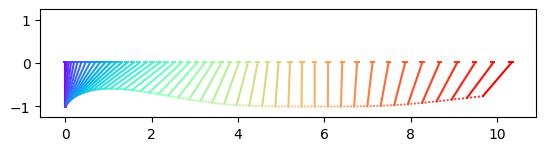

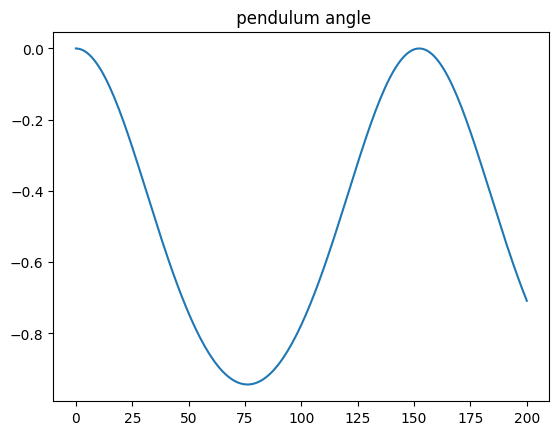

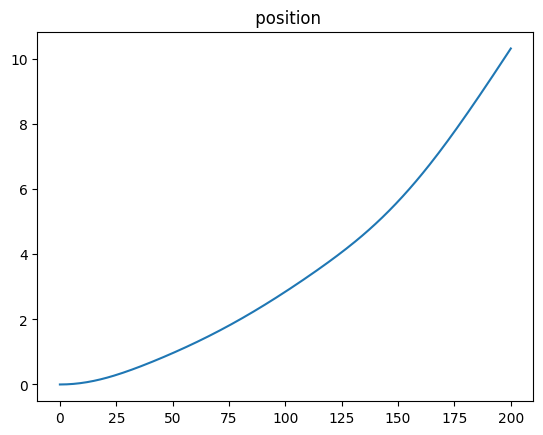

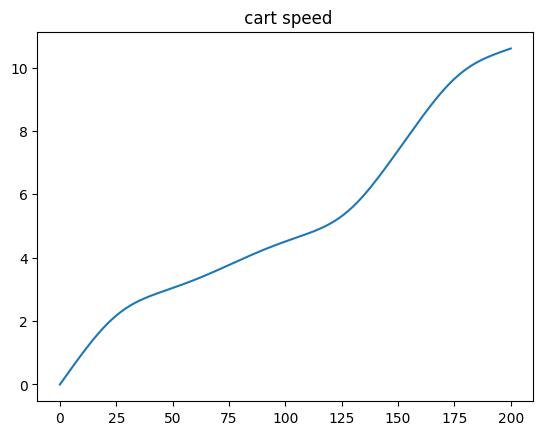

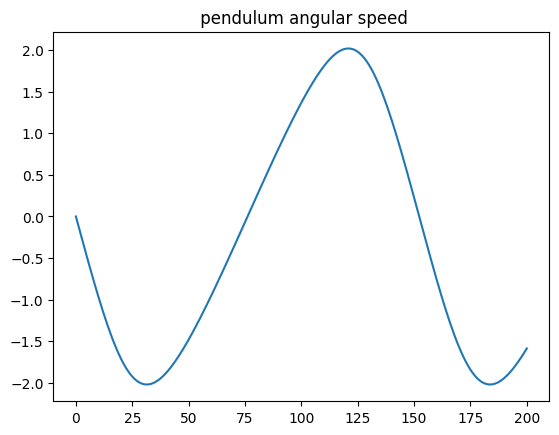

In [19]:
cartpole_demo(np.array([0.0, 0.0, 0.0, 0.0]), 10.0, 2, u_max=10.0)

The dynamics of a system are governed by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u)$

where $t$ is time, $\mathbf{z}$ is the system's state, and $u$ is a control input applied to the system. Then the system's linearized dynamics are given by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u) \approx f(t_0, \mathbf{z}_0, u_0) + \nabla_{\mathbf{z}}f(t_0, \mathbf{z}_0, u_0)^T (\mathbf{z} - \mathbf{z}_0) + \nabla_uf(t_0, \mathbf{z}_0, u_0)^T(u - u_0)$

or, using the terms from the following function,

$\dot{\mathbf{z}} = \mathbf{r}(t_0, \mathbf{z}_0, u_0) + A \mathbf{z} + \mathbf{b}u$

for some initial time, state, and control input.

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + e^{At}\int_{t_0}^{t}e^{A\tau} \left( b u(\tau) + f \right) d\tau
\end{equation}

When $u(\tau) = u_0$ for $t_0 \leq t \leq t$ the convolution integral becomes

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + \left( e^{A(t - t_0)} - \mathbb{I} \right)A^{-1}(b u_0 + f)
\end{equation}

$A \in \mathbb{R}^{n \times n}$ is the Jacobian of the nonlinear system dynamics with respect to $x \in \mathbb{R}^n$

$b \in \mathbb{R}^n$ is the Jacobian of the nonlinear system dynamics with respect to $u \in \mathbb{R}$

$f \in \mathbb{R}^n$ is the constant term that comes from linearizing the system dynamics about a non-fixed point

The state transition matrix is defined as

\begin{equation}
\Phi(t) = e^{At}
\end{equation}

and transitioning from one state to the next state is done via

\begin{equation}
\mathbf{x}_{t+\delta t} = \Phi(t + \delta t, t) \mathbf{x}_{t}
\end{equation}

In [20]:
def plot_control_input(us: List[np.ndarray], dt: float, title_prefix: str | None=None, filename: str = None):
   '''
   Plots a sequence of control inputs

   - us = A sequence of control inputs
   - dt = Time duration over which the LTI system is simulated
   - filename = Name of the file the plot should be saved to
   '''

   title_prefix = "" if title_prefix is None else title_prefix

   t_vals = [dt * n for n in range(len(us))]
   plt.title(title_prefix + " control input")
   plt.plot(t_vals, [u for u in us])
   # plt.plot([u for u in us])
   plt.xlabel("Time (s)")
   plt.ylabel("Control effort")
   plt.show()
   if filename is not None:
      plt.savefig(filename, dpi=800.0, bbox_inches='tight')


## Trajectory Optimization

In [21]:
def cartpole_trajectory_optimizer_linear(
   N: int,
   T: float,
   dynamics: CartpoleDynamics,
   z_0: np.ndarray,
   z_f: np.ndarray | None=None,
   z_f_penalty: float | None=None,
   ref_trajectory: List[np.ndarray] | None=None,
   ref_trajectory_weight: float | None=None,
   relinearization_sequence: List[np.ndarray] | None=None,
) -> Tuple[List[np.ndarray], List[np.ndarray], bool]:
   effort_weights = np.ones(N * dynamics.control_size)

   state_weights = None
   if ref_trajectory is not None:
      if ref_trajectory_weight is None:
         state_weights = 100.0 * np.tile([1.0, 1.0, 0.0, 0.0], N)
      else:
         state_weights = ref_trajectory_weight * np.tile([1.0, 1.0, 0.0, 0.0], N)

   to = TrajectoryOptimizer(
      effort_weights,
      N,
      T,
      z_0,
      dynamics,
      final_state=z_f,
      reference_trajectory=ref_trajectory,
      state_weights=state_weights,
      final_state_penalty=z_f_penalty,
      relinearization_sequence=relinearization_sequence,
   )

   # zs for warm-starting infeasible newton
   delta_tau = (1.0 / N)
   warm_zs = None
   if z_f is not None and z_f_penalty is None:
      warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_f for i in range(N)]
   else:
      warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * np.zeros(dynamics.state_size) for i in range(N)]
   warm_us = [0.000,] * (N)

   print("z_0: ", warm_zs[0])
   print("z_f: ", warm_zs[-1])

   x_init = np.hstack(warm_us + warm_zs)
   v_init = None
   if z_f is not None and z_f_penalty is None:
      v_init = np.ones(dynamics.state_size * (N + 1)) * 0.01
   else:
      v_init = np.ones(dynamics.state_size * N) * 0.01

   x_out, v_out, feasible = to.gogogo(x_init, v_init, max_num_newton_iters=200)

   dense_zs = to.get_states(x_out)
   dense_zs.insert(0, z_0)
   dense_us = to.get_inputs(x_out)

   return dense_zs, dense_us, feasible

In [22]:
# def cartpole_trajectory_optimizer_relinearization(
#    N: int,
#    T: float,
#    dynamics: CartpoleDynamics,
#    z_0: np.ndarray,
#    z_f: np.ndarray | None=None,
#    z_f_penalty: float | None=None,
#    ref_trajectory: List[np.ndarray] | None=None,
#    ref_trajectory_weight: float | None=None,
#    plot_stuff: bool=True,
#    filename: str | None=None
# ):
#    effort_weights = np.ones(N * dynamics.control_size)

#    state_weights = None
#    if ref_trajectory is not None:
#       if ref_trajectory_weight is None:
#          state_weights = 100.0 * np.tile([1.0, 1.0, 0.0, 0.0], N)
#       else:
#          state_weights = ref_trajectory_weight * np.tile([1.0, 1.0, 0.0, 0.0], N)

#    to = TrajectoryOptimizer(
#       effort_weights,
#       N,
#       T,
#       z_0,
#       dynamics,
#       final_state=z_f,
#       reference_trajectory=ref_trajectory,
#       state_weights=state_weights,
#       final_state_penalty=z_f_penalty
#    )

#    # zs for warm-starting infeasible newton
#    delta_tau = (1.0 / N)
#    warm_zs = None
#    if z_f is not None and z_f_penalty is None:
#       warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_f for i in range(N)]
#    else:
#       warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * np.zeros(dynamics.state_size) for i in range(N)]
#    warm_us = [0.000,] * (N)

#    print("z_0: ", warm_zs[0])
#    print("z_f: ", warm_zs[-1])

#    x_init = np.hstack(warm_us + warm_zs)
#    v_init = None
#    if z_f is not None and z_f_penalty is None:
#       v_init = np.ones(dynamics.state_size * (N + 1)) * 0.01
#    else:
#       v_init = np.ones(dynamics.state_size * N) * 0.01

#    x_out, v_out, feasible = to.gogogo(x_init, v_init, max_num_newton_iters=100)

#    if not feasible:
#       print("problem isn't feasible")
#       return

#    dense_zs = to.get_states(x_out)
#    dense_zs.insert(0, z_0)
#    dense_us = to.get_inputs(x_out)

#    print("last control input:", dense_us[-1])

#    if plot_stuff:

#       control_input_filename = None
#       trajectory_filename = None
#       if filename is not None:
#          z_0_str = "_".join([str(v) for v in z_0.tolist()])
#          if z_f is not None:
#             z_f_str = "_".join([str(v) for v in z_f.tolist()])
#          else:
#             z_f_str = "_".join([str(v) for v in np.zeros(dynamics.state_size).tolist()])
#          config_str = f'_T={T}_N={N}_z0={z_0_str}_zf={z_f_str}_'
#          control_input_filename = filename + config_str + "_control_inputty.png"
#          trajectory_filename = filename + config_str + "_cartpole_swingy.png"
      
#       plot_pendulum_time_sequence(dense_zs, dynamics._l_pend, 2, trajectory_filename)
#       plot_control_input(dense_us, T / N, control_input_filename)

#    nonlinear_states = [z_0]
#    dt = T / N
#    num_substeps = 100
#    temp_state = nonlinear_states[-1]
#    for control_input in dense_us:
#       for i in range(num_substeps):
#          print("temp state:", temp_state)
#          temp_state = dynamics.step(
#             temp_state, control_input, dt / num_substeps, 0.0
#          )

#       nonlinear_states.append(temp_state)

#    print("applying control inputs to nonliner dynamics")

#    if plot_stuff:
#       plot_pendulum_time_sequence(nonlinear_states, dynamics._l_pend, 2)
#       plot_control_input(dense_us, T / N)


## Modifiable parameters

Some configurations might make the problem infeasible.

In [23]:
# Number of timesteps
N = 128
# Total amount of time
T = 1.0

u_min = -15.0
u_max = 15.0

m_pend = 0.3
m_cart = 0.3
l_pend = 0.5

dynamics = CartpoleDynamics(l_pend, m_pend, m_cart, u_min, u_max)

z_0 = np.array([0.0, 0.0, 0.0, 0.0])
z_final = np.array([1.0, np.pi, 0.0, 0.0])

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 214734.73811599024 line search param: 0.34867844010000015
ifsnm num iters: 1 residual norm: 211560.76912216627 line search param: 0.014780882941434608
ifsnm num iters: 2 residual norm: 208433.71485336282 line search param: 0.014780882941434608
ifsnm num iters: 3 residual norm: 205938.23908230884 line search param: 0.011972515182562033
ifsnm num iters: 4 residual norm: 203472.64086243007 line search param: 0.011972515182562033
ifsnm num iters: 5 residual norm: 201036.56187624278 line search param: 0.011972515182562033
ifsnm num iters: 6 residual norm: 198629.64885809232 line search param: 0.011972515182562033
ifsnm num iters: 7 residual norm: 196489.36206320304 line search param: 0.01077526366430583
ifsnm num iters: 8 residual norm: 194136.8942791399 line search param: 0.011972515182562033
ifsnm num iters: 9 residual norm: 192045.01837310885 line search param: 0.0

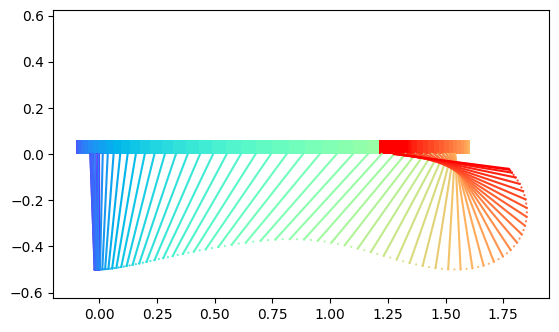

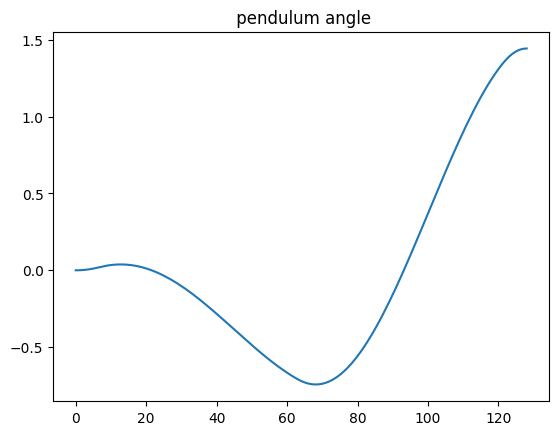

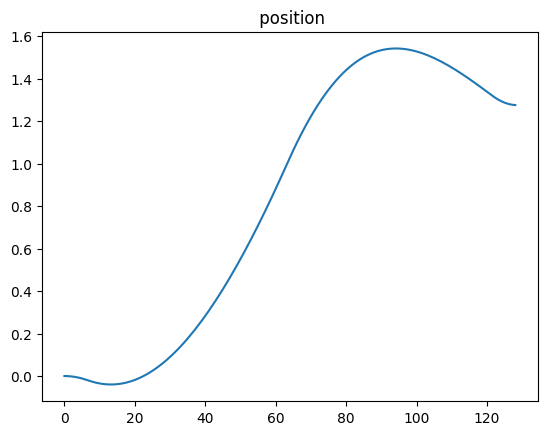

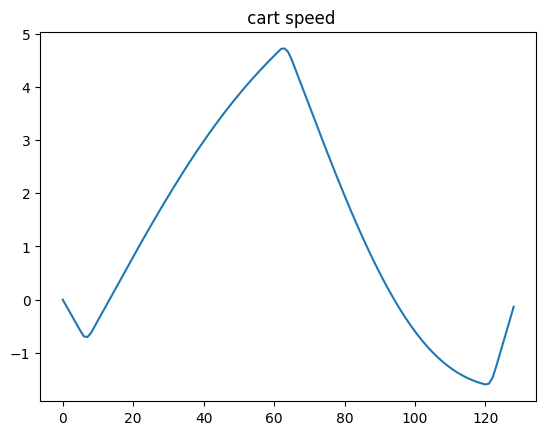

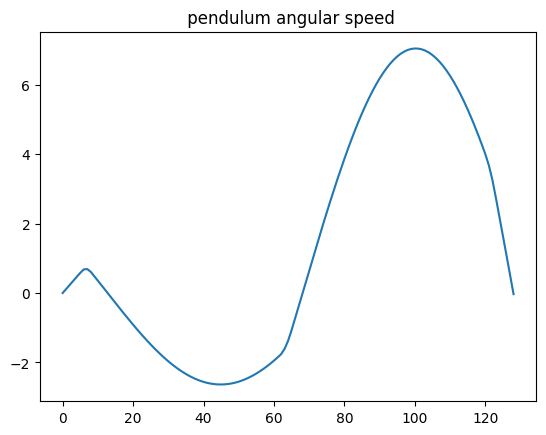

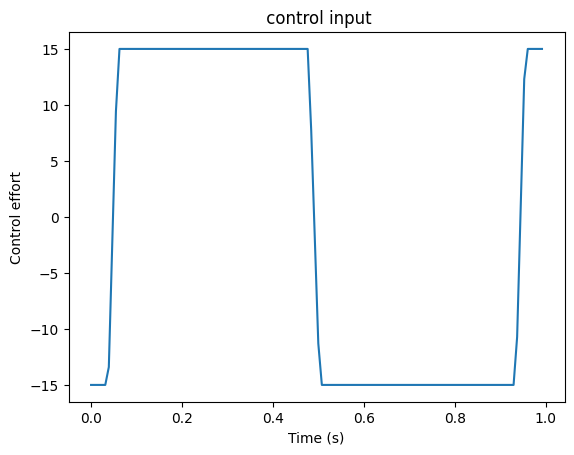

============ step 0 ============
applying control inputs to nonliner dynamics


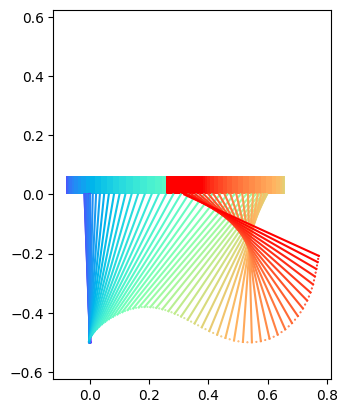

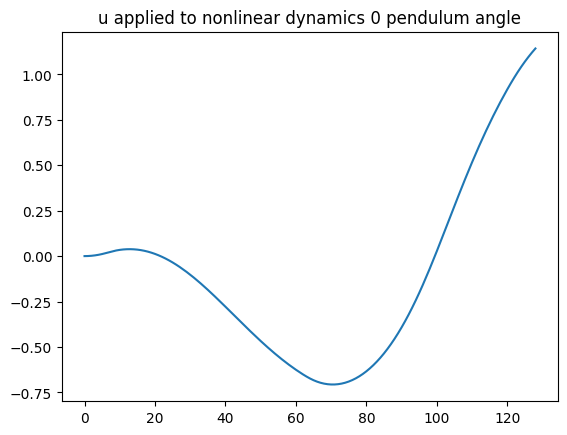

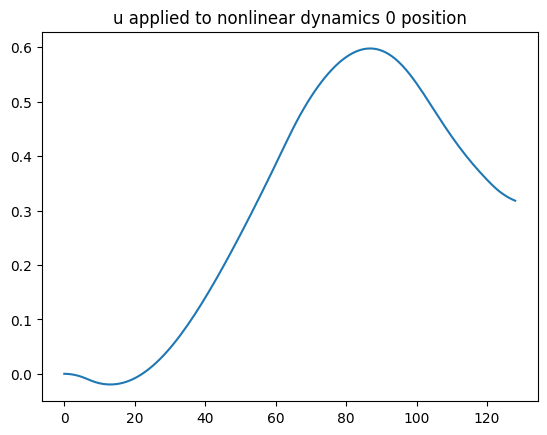

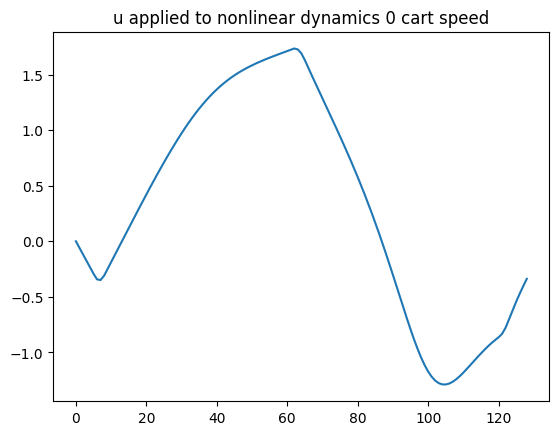

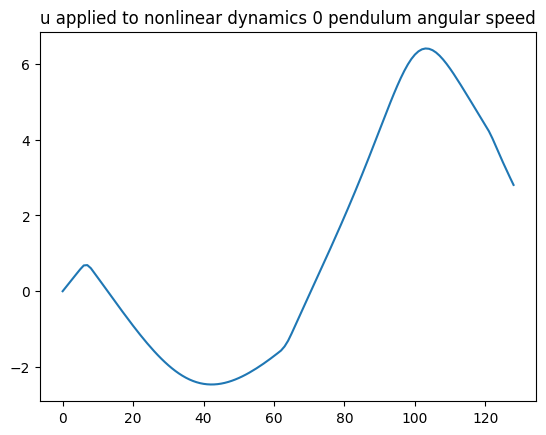

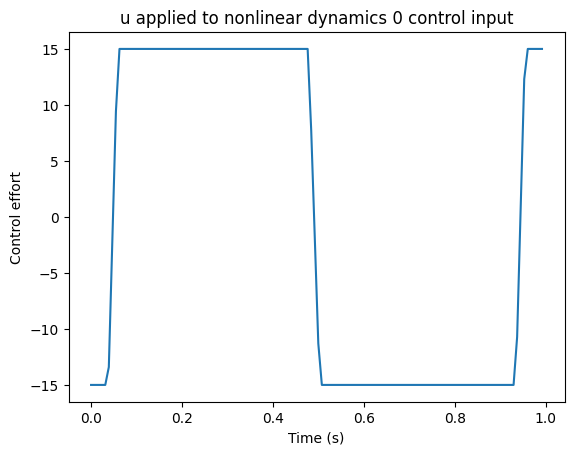

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 236576.39336835642 line search param: 0.28242953648100017
ifsnm num iters: 1 residual norm: 229996.53224272843 line search param: 0.02781283894436938
ifsnm num iters: 2 residual norm: 227518.2590224631 line search param: 0.01077526366430583
ifsnm num iters: 3 residual norm: 225311.84674563643 line search param: 0.009697737297875247
ifsnm num iters: 4 residual norm: 223126.8319167304 line search param: 0.009697737297875247
ifsnm num iters: 5 residual norm: 221179.38908945044 line search param: 0.008727963568087723
ifsnm num iters: 6 residual norm: 219248.94351236612 line search param: 0.008727963568087723
ifsnm num iters: 7 residual norm: 217335.3494282915 line search param: 0.008727963568087723
ifsnm num iters: 8 residual norm: 215628.14394253553 line search param: 0.00785516721127895
ifsnm num iters: 9 residual norm: 213934.34884704975 line search param: 0.00785

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.49256e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 12 line search: 1.0 newton decrement: 1.80247181599584e-06
nd prev: 1.80247181599584e-06 nd: 7.433209605574843e-10
entering fsnm loop
newton decrement: 0.21201787970617933
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.21201787970617933
nd prev: 0.21201787970617933 nd: 13.877107979624762
fsnm num iters: 1 line search: 1.0 newton decrement: 13.877107979624762
nd prev: 13.877107979624762 nd: 0.010803340026227322


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.781e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.97365e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.010803340026227322
nd prev: 0.010803340026227322 nd: 0.00984072892215748
fsnm num iters: 3 line search: 1.0 newton decrement: 0.00984072892215748
nd prev: 0.00984072892215748 nd: 0.00800594941668994


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.82938e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.34044e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.00800594941668994
nd prev: 0.00800594941668994 nd: 0.004939801963549712
fsnm num iters: 5 line search: 1.0 newton decrement: 0.004939801963549712
nd prev: 0.004939801963549712 nd: 0.0015540065362758435


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.15066e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.46741e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0022185312344622636 newton decrement: 0.0015540065362758435
nd prev: 0.0015540065362758435 nd: 0.00011803931049980707


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.46746e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.4675e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0014555783429306911 newton decrement: 0.00011803931049980707
nd prev: 0.00011803931049980707 nd: 0.00011777915234207838
fsnm num iters: 8 line search: 1.0 newton decrement: 0.00011777915234207838
nd prev: 0.00011777915234207838 nd: 0.00011702234097356029


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.49243e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 6.85596132412799e-05 newton decrement: 0.00011702234097356029
nd prev: 0.00011702234097356029 nd: 5.900916001728855e-07
fsnm num iters: 10 line search: 0.02781283894436938 newton decrement: 5.900916001728855e-07
nd prev: 5.900916001728855e-07 nd: 5.90086761133614e-07
fsnm num iters: 11 line search: 1.0 newton decrement: 5.90086761133614e-07
nd prev: 5.90086761133614e-07 nd: 5.736737482999262e-07
fsnm num iters: 12 line search: 1.0 newton decrement: 5.736737482999262e-07
nd prev: 5.736737482999262e-07 nd: 8.155966931007706e-10


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.49255e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=2.49256e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.06704823360570375
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06704823360570375
nd prev: 0.06704823360570375 nd: 4.400572432218474


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.78088e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.97361e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 4.400572432218474
nd prev: 4.400572432218474 nd: 0.003417744945552629
fsnm num iters: 2 line search: 1.0 newton decrement: 0.003417744945552629
nd prev: 0.003417744945552629 nd: 0.0031147133159118746


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.8293e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.34043e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.0031147133159118746
nd prev: 0.0031147133159118746 nd: 0.0025364099530709593
fsnm num iters: 4 line search: 1.0 newton decrement: 0.0025364099530709593
nd prev: 0.0025364099530709593 nd: 0.0015675559857282306


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.15065e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.46741e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 0.0015675559857282306
nd prev: 0.0015675559857282306 nd: 0.0004940109908350216
fsnm num iters: 6 line search: 1.0 newton decrement: 0.0004940109908350216
nd prev: 0.0004940109908350216 nd: 3.739796604457396e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.49242e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0002996906728784534 newton decrement: 3.739796604457396e-05
nd prev: 3.739796604457396e-05 nd: 1.8985101953815438e-07
fsnm num iters: 8 line search: 4.048376602284338e-05 newton decrement: 1.8985101953815438e-07
nd prev: 1.8985101953815438e-07 nd: 1.8983683026322287e-07
fsnm num iters: 9 line search: 4.048376602284338e-05 newton decrement: 1.8983683026322287e-07
nd prev: 1.8983683026322287e-07 nd: 1.8983689438510556e-07
entering fsnm loop
newton decrement: 0.021201986224566045
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=2.49242e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.49242e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.021201986224566045
nd prev: 0.021201986224566045 nd: 1.3895927019192498
fsnm num iters: 1 line search: 1.0 newton decrement: 1.3895927019192498
nd prev: 1.3895927019192498 nd: 0.0010806404639750373


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.80232e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.9803e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0010806404639750373
nd prev: 0.0010806404639750373 nd: 0.0009846782139869526
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0009846782139869526
nd prev: 0.0009846782139869526 nd: 0.0008015635543765906


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.84586e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.34302e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0008015635543765906
nd prev: 0.0008015635543765906 nd: 0.000494929741441072
fsnm num iters: 5 line search: 1.0 newton decrement: 0.000494929741441072
nd prev: 0.000494929741441072 nd: 0.00015563178686717148


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.15242e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.46766e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0007735540101454295 newton decrement: 0.00015563178686717148
nd prev: 0.00015563178686717148 nd: 1.1787461068865124e-05
fsnm num iters: 7 line search: 1.0 newton decrement: 1.1787461068865124e-05
nd prev: 1.1787461068865124e-05 nd: 1.1720244427533551e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.4924e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.00033298963653161486 newton decrement: 1.1720244427533551e-05
nd prev: 1.1720244427533551e-05 nd: 5.874002124521923e-08
fsnm num iters: 9 line search: 4.4981962247603756e-05 newton decrement: 5.874002124521923e-08
nd prev: 5.874002124521923e-08 nd: 5.874572873805086e-08
fsnm num iters: 10 line search: 4.997995805289306e-05 newton decrement: 5.874572873805086e-08
nd prev: 5.874572873805086e-08 nd: 5.874563739838307e-08
fsnm num iters: 11 line search: 4.997995805289306e-05 newton decrement: 5.874563739838307e-08
nd prev: 5.874563739838307e-08 nd: 5.874568219062131e-08
entering fsnm loop
newton decrement: 0.006704663446459751
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=2.4924e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.4924e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.006704663446459751
nd prev: 0.006704663446459751 nd: 0.439463461983249
fsnm num iters: 1 line search: 1.0 newton decrement: 0.439463461983249
nd prev: 0.439463461983249 nd: 0.0003417340363638913


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.80379e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.98071e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0003417340363638913
nd prev: 0.0003417340363638913 nd: 0.0003113892800645335
fsnm num iters: 3 line search: 0.6561000000000001 newton decrement: 0.0003113892800645335
nd prev: 0.0003113892800645335 nd: 0.0002870805308116542


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.84749e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.04745e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 0.00045677590745077476 newton decrement: 0.0002870805308116542
nd prev: 0.0002870805308116542 nd: 0.0002621095978678376
fsnm num iters: 5 line search: 0.34867844010000015 newton decrement: 0.0002621095978678376
nd prev: 0.0002621095978678376 nd: 0.0002334418882441927


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.04776e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32059e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0002334418882441927
nd prev: 0.0002334418882441927 nd: 0.00015943193438234
fsnm num iters: 7 line search: 1.0 newton decrement: 0.00015943193438234
nd prev: 0.00015943193438234 nd: 5.1416751794056645e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.13727e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.46526e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.00017696434542799794 newton decrement: 5.1416751794056645e-05
nd prev: 5.1416751794056645e-05 nd: 4.09482786933972e-06
fsnm num iters: 9 line search: 0.00024274944503154723 newton decrement: 4.09482786933972e-06
nd prev: 4.09482786933972e-06 nd: 4.094770690827059e-06
fsnm num iters: 10 line search: 3.6435389420559045e-05 newton decrement: 4.094770690827059e-06
nd prev: 4.094770690827059e-06 nd: 4.09467043447605e-06
fsnm num iters: 11 line search: 4.4981962247603756e-05 newton decrement: 4.09467043447605e-06
nd prev: 4.09467043447605e-06 nd: 4.094668948128952e-06
entering fsnm loop
newton decrement: 0.002107310991460478
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=2.46526e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.46526e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.002107310991460478
nd prev: 0.002107310991460478 nd: 0.09920964247876064


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.11644e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 3.6435389420559045e-05 newton decrement: 0.09920964247876064
nd prev: 0.09920964247876064 nd: 0.00018581875953309763
fsnm num iters: 2 line search: 3.6435389420559045e-05 newton decrement: 0.00018581875953309763
nd prev: 0.00018581875953309763 nd: 0.0001858187219899468
entering fsnm loop
newton decrement: 8.28743362332364e-05
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.11644e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.11644e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 3.279185047850314e-05 newton decrement: 8.28743362332364e-05
nd prev: 8.28743362332364e-05 nd: 8.287450814155648e-05
fsnm num iters: 1 line search: 2.615689274578838e-06 newton decrement: 8.287450814155648e-05
nd prev: 8.287450814155648e-05 nd: 8.287401340424388e-05
fsnm num iters: 2 line search: 0.81 newton decrement: 8.287401340424388e-05
nd prev: 8.287401340424388e-05 nd: 0.0008374342068928725


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.02656e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.36136e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008374342068928725
nd prev: 0.0008374342068928725 nd: 3.288986270287418e-05
fsnm num iters: 4 line search: 1.0 newton decrement: 3.288986270287418e-05
nd prev: 3.288986270287418e-05 nd: 2.8664054148847975e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=8.9481e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 3.6435389420559045e-05 newton decrement: 2.8664054148847975e-05
nd prev: 2.8664054148847975e-05 nd: 2.9141794254086153e-05
fsnm num iters: 6 line search: 3.6435389420559045e-05 newton decrement: 2.9141794254086153e-05
nd prev: 2.9141794254086153e-05 nd: 2.914178742919764e-05
entering fsnm loop
newton decrement: 0.00011989774054824009
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=8.9481e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=8.9481e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.1853020188851842 newton decrement: 0.00011989774054824009
nd prev: 0.00011989774054824009 nd: 0.0023995136741871807
fsnm num iters: 1 line search: 1.0 newton decrement: 0.0023995136741871807
nd prev: 0.0023995136741871807 nd: 9.28294301360727e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.32781e-26): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=9.31124e-26): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 0.004638397686588107 newton decrement: 9.28294301360727e-06
nd prev: 9.28294301360727e-06 nd: 1.039181705473293e-05
fsnm num iters: 3 line search: 0.00010449567633177853 newton decrement: 1.039181705473293e-05
nd prev: 1.039181705473293e-05 nd: 1.0391385215207647e-05
fsnm num iters: 4 line search: 8.464149782874061e-05 newton decrement: 1.0391385215207647e-05
nd prev: 1.0391385215207647e-05 nd: 1.0391385215338585e-05


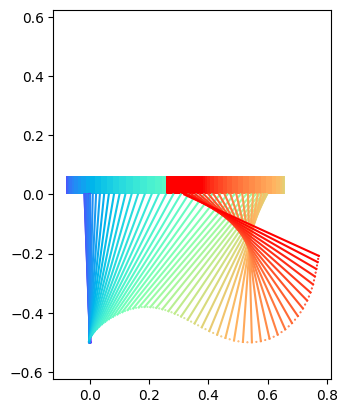

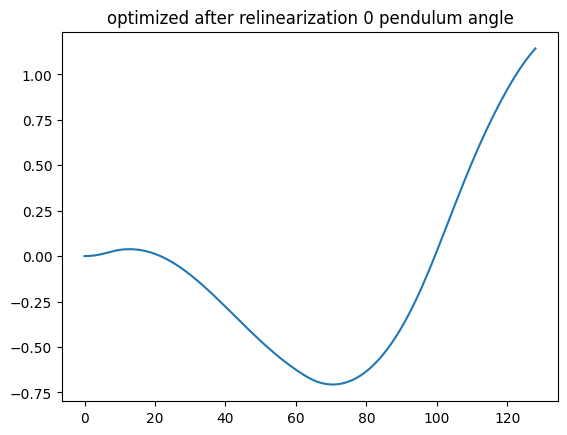

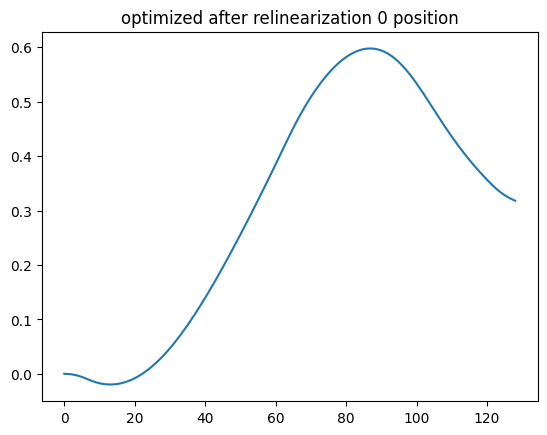

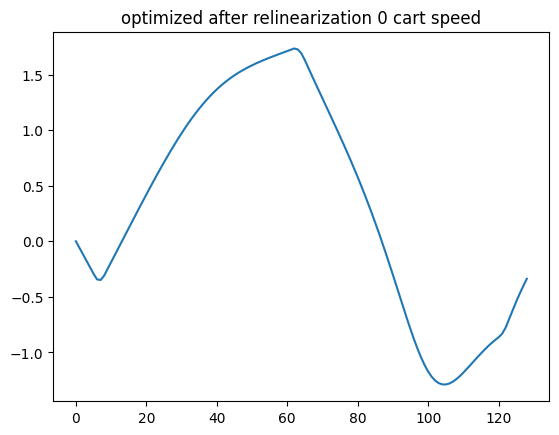

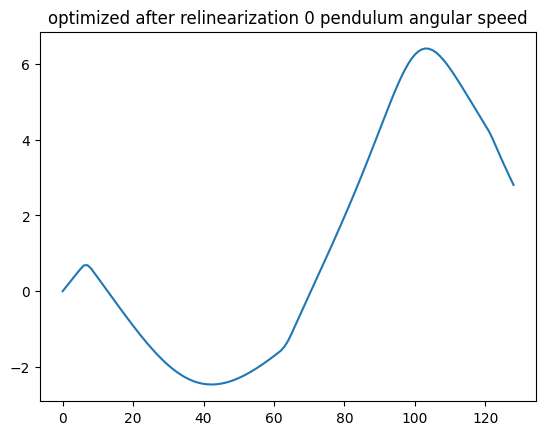

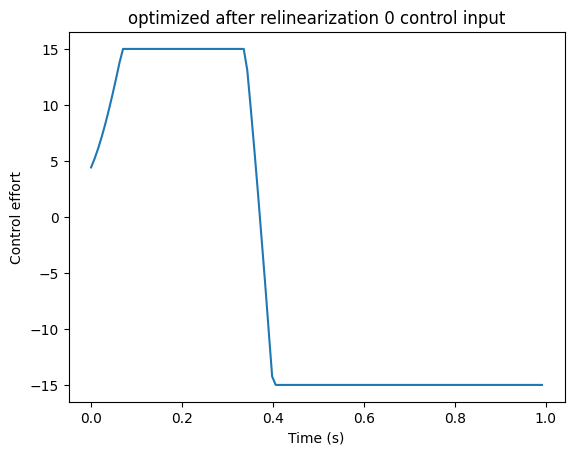

============ step 1 ============
applying control inputs to nonliner dynamics


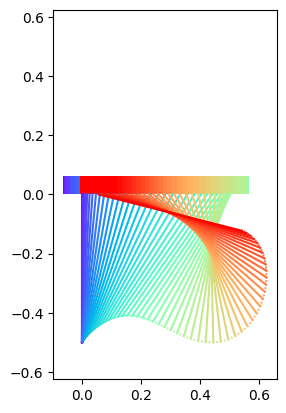

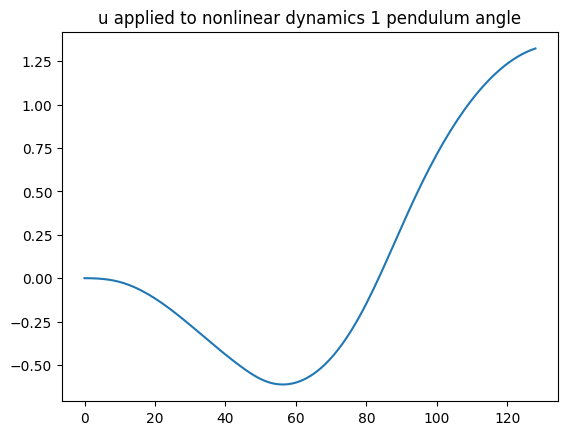

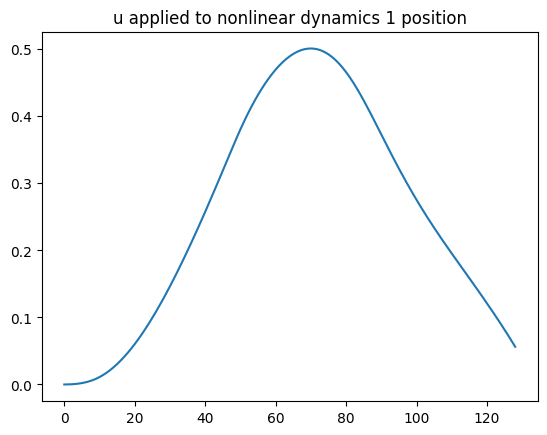

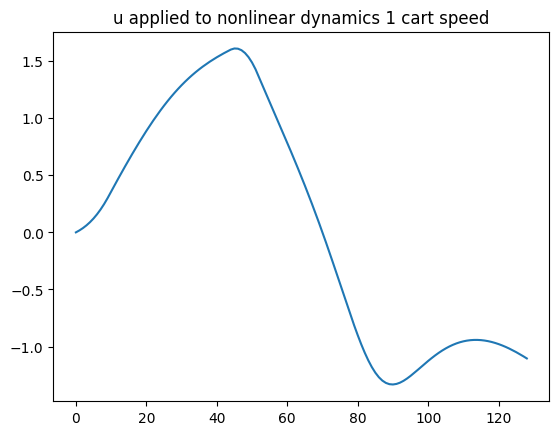

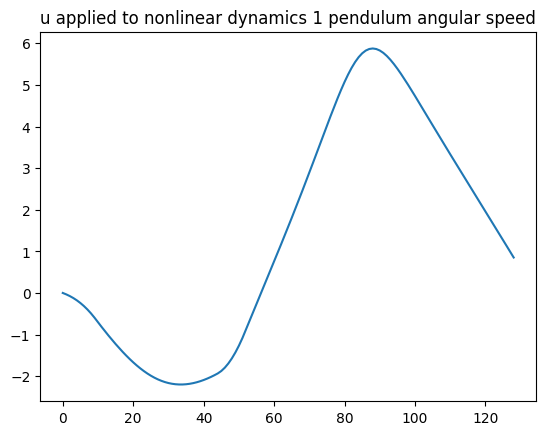

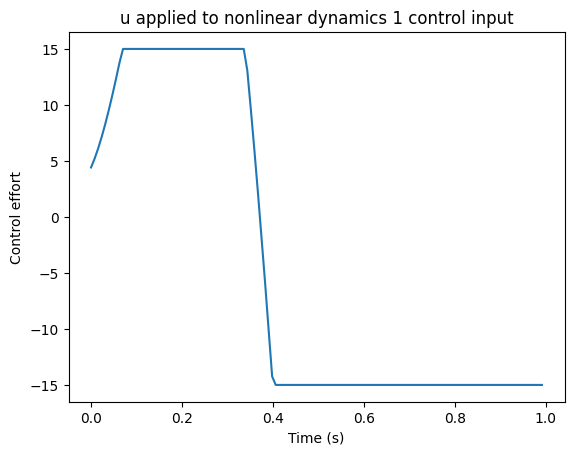

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 236576.3933683408 line search param: 0.28242953648100017
ifsnm num iters: 1 residual norm: 234027.2206745177 line search param: 0.01077526366430583
ifsnm num iters: 2 residual norm: 231757.68618671087 line search param: 0.009697737297875247
ifsnm num iters: 3 residual norm: 229510.1614487992 line search param: 0.009697737297875247
ifsnm num iters: 4 residual norm: 227507.00514856318 line search param: 0.008727963568087723
ifsnm num iters: 5 residual norm: 225521.3323272622 line search param: 0.008727963568087723
ifsnm num iters: 6 residual norm: 223552.99168294808 line search param: 0.008727963568087723
ifsnm num iters: 7 residual norm: 221385.03380193838 line search param: 0.009697737297875247
ifsnm num iters: 8 residual norm: 218999.55172384082 line search param: 0.01077526366430583
ifsnm num iters: 9 residual norm: 217279.273668374 line search param: 0.0078551

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.03845e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.12073e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 1.4450280880587756
nd prev: 1.4450280880587756 nd: 0.2955239103122667
fsnm num iters: 3 line search: 1.0 newton decrement: 0.2955239103122667
nd prev: 0.2955239103122667 nd: 0.2482954617238302


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.77372e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.2482954617238302
nd prev: 0.2482954617238302 nd: 0.16906708272967372
fsnm num iters: 5 line search: 1.0 newton decrement: 0.16906708272967372
nd prev: 0.16906708272967372 nd: 0.06937543545115418
fsnm num iters: 6 line search: 1.0 newton decrement: 0.06937543545115418
nd prev: 0.06937543545115418 nd: 0.009481868141045053
fsnm num iters: 7 line search: 0.0006265787482177979 newton decrement: 0.009481868141045053
nd prev: 0.009481868141045053 nd: 0.00016472838671152817
fsnm num iters: 8 line search: 4.997995805289306e-05 newton decrement: 0.00016472838671152817
nd prev: 0.00016472838671152817 nd: 0.00016462524006199028
fsnm num iters: 9 line search: 1.0 newton decrement: 0.00016462524006199028
nd prev: 0.00016462524006199028 nd: 0.00016456049761138603
fsnm num iters: 10 line search: 1.0 newton decrement: 0.00016456049761138603
nd prev: 0.00016456049761138603 nd: 5.9003708719953074e-08
fsnm num iters: 11 line search: 0.0002184745005283

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.07453e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.69683e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 3.507201753280093
nd prev: 3.507201753280093 nd: 0.09813596031388422
fsnm num iters: 3 line search: 1.0 newton decrement: 0.09813596031388422
nd prev: 0.09813596031388422 nd: 0.08613056574698111


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.5498e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.51772e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.08613056574698111
nd prev: 0.08613056574698111 nd: 0.06452062231331397
fsnm num iters: 5 line search: 1.0 newton decrement: 0.06452062231331397
nd prev: 0.06452062231331397 nd: 0.03279577880789248


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.0922e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.32534e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.03279577880789248
nd prev: 0.03279577880789248 nd: 0.00720980348253782
fsnm num iters: 7 line search: 0.5904900000000002 newton decrement: 0.00720980348253782
nd prev: 0.00720980348253782 nd: 0.0006800534208678634


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.61935e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62553e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.38742048900000015 newton decrement: 0.0006800534208678634
nd prev: 0.0006800534208678634 nd: 0.00029229682294403295


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.6272e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.0006961986091308866 newton decrement: 0.00029229682294403295
nd prev: 0.00029229682294403295 nd: 0.00018112379784690258
fsnm num iters: 10 line search: 6.5474770070138e-08 newton decrement: 0.00018112379784690258
nd prev: 0.00018112379784690258 nd: 0.00018099946133764912
fsnm num iters: 11 line search: 0.00045677590745077476 newton decrement: 0.00018099946133764912
nd prev: 0.00018099946133764912 nd: 0.00018099887353574496
fsnm num iters: 12 line search: 0.00019662705047555326 newton decrement: 0.00018099887353574496
nd prev: 0.00018099887353574496 nd: 0.00018091710375308
fsnm num iters: 13 line search: 1.0 newton decrement: 0.00018091710375308
nd prev: 0.00018091710375308 nd: 0.0001796303081349532


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62984e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 14 line search: 1.0 newton decrement: 0.0001796303081349532
nd prev: 0.0001796303081349532 nd: 1.3119632131944093e-06
fsnm num iters: 15 line search: 0.0010611166119964739 newton decrement: 1.3119632131944093e-06
nd prev: 1.3119632131944093e-06 nd: 6.208005331531145e-10
entering fsnm loop
newton decrement: 0.6294774117908564
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6294774117908564
nd prev: 0.6294774117908564 nd: 40.8640144114913
fsnm num iters: 1 line search: 1.0 newton decrement: 40.8640144114913
nd prev: 40.8640144114913 nd: 0.033618900788414896


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.07044e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.65459e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.033618900788414896
nd prev: 0.033618900788414896 nd: 0.029129010045207637
fsnm num iters: 3 line search: 1.0 newton decrement: 0.029129010045207637
nd prev: 0.029129010045207637 nd: 0.023639465340691713


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.07987e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.4847e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.023639465340691713
nd prev: 0.023639465340691713 nd: 0.01453876841532613
fsnm num iters: 5 line search: 1.0 newton decrement: 0.01453876841532613
nd prev: 0.01453876841532613 nd: 0.004545521797383704


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.98962e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.57943e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0016173092699229901 newton decrement: 0.004545521797383704
nd prev: 0.004545521797383704 nd: 0.0003419172030199471
fsnm num iters: 7 line search: 0.43046721000000016 newton decrement: 0.0003419172030199471
nd prev: 0.0003419172030199471 nd: 0.000340643209873422


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5795e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.59957e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.0005639208733960181 newton decrement: 0.000340643209873422
nd prev: 0.000340643209873422 nd: 0.00019514895770952778


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.59959e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 8.20831010441805e-07 newton decrement: 0.00019514895770952778
nd prev: 0.00019514895770952778 nd: 0.00019503954963748913
fsnm num iters: 10 line search: 9.404610869860067e-05 newton decrement: 0.00019503954963748913
nd prev: 0.00019503954963748913 nd: 0.00019503936527391925
entering fsnm loop
newton decrement: 0.19859425543319595
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=4.60311e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.60311e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.19859425543319595
nd prev: 0.19859425543319595 nd: 10.826122405935157
fsnm num iters: 1 line search: 1.0 newton decrement: 10.826122405935157
nd prev: 10.826122405935157 nd: 0.009947411191057064


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.55815e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.14125e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009947411191057064
nd prev: 0.009947411191057064 nd: 0.008851379058590878
fsnm num iters: 3 line search: 1.0 newton decrement: 0.008851379058590878
nd prev: 0.008851379058590878 nd: 0.006813425454585695


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.42806e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.97933e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.006813425454585695
nd prev: 0.006813425454585695 nd: 0.003669348257691091
fsnm num iters: 5 line search: 0.5904900000000002 newton decrement: 0.003669348257691091
nd prev: 0.003669348257691091 nd: 0.0008613431177042006


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.27228e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.47132e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0017970102999144335 newton decrement: 0.0008613431177042006
nd prev: 0.0008613431177042006 nd: 0.000382131748933567


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.47159e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0010611166119964739 newton decrement: 0.000382131748933567
nd prev: 0.000382131748933567 nd: 0.00038146201099766047


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.47175e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 6.170365191715192e-05 newton decrement: 0.00038146201099766047
nd prev: 0.00038146201099766047 nd: 0.00038107102867633065
fsnm num iters: 9 line search: 0.31381059609000017 newton decrement: 0.00038107102867633065
nd prev: 0.00038107102867633065 nd: 0.00037897253431232707


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.47176e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51909e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0005075287860564164 newton decrement: 0.00037897253431232707
nd prev: 0.00037897253431232707 nd: 0.00026355717468424226


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51914e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 11 line search: 0.001310020508637622 newton decrement: 0.00026355717468424226
nd prev: 0.00026355717468424226 nd: 0.0002634225145197571


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51928e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51932e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 12 line search: 0.0003699884850351276 newton decrement: 0.0002634225145197571
nd prev: 0.0002634225145197571 nd: 0.00026308464421016315
fsnm num iters: 13 line search: 0.38742048900000015 newton decrement: 0.00026308464421016315
nd prev: 0.00026308464421016315 nd: 0.00026176766025096386


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56005e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 14 line search: 0.0002996906728784534 newton decrement: 0.00026176766025096386
nd prev: 0.00026176766025096386 nd: 0.00016232959414803384


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56007e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56011e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 15 line search: 0.0005639208733960181 newton decrement: 0.00016232959414803384
nd prev: 0.00016232959414803384 nd: 0.0001622809887317425
fsnm num iters: 16 line search: 0.001310020508637622 newton decrement: 0.0001622809887317425
nd prev: 0.0001622809887317425 nd: 0.00016218926867600834
fsnm num iters: 17 line search: 9.404610869860067e-05 newton decrement: 0.00016218926867600834
nd prev: 0.00016218926867600834 nd: 0.00016197983082470038


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56019e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5602e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 18 line search: 2.354120347120954e-06 newton decrement: 0.00016197983082470038
nd prev: 0.00016197983082470038 nd: 0.00016196482510717858
fsnm num iters: 19 line search: 2.354120347120954e-06 newton decrement: 0.00016196482510717858
nd prev: 0.00016196482510717858 nd: 0.0001619645539510833
fsnm num iters: 20 line search: 4.4981962247603756e-05 newton decrement: 0.0001619645539510833
nd prev: 0.0001619645539510833 nd: 0.00016196423116309513
fsnm num iters: 21 line search: 0.00011610630703530947 newton decrement: 0.00016196423116309513
nd prev: 0.00016196423116309513 nd: 0.00016195696697911258


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56021e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56025e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 22 line search: 0.0006265787482177979 newton decrement: 0.00016195696697911258
nd prev: 0.00016195696697911258 nd: 0.0001619376560766748
fsnm num iters: 23 line search: 4.997995805289306e-05 newton decrement: 0.0001619376560766748
nd prev: 0.0001619376560766748 nd: 0.00016183755305440781
fsnm num iters: 24 line search: 0.0016173092699229901 newton decrement: 0.00016183755305440781
nd prev: 0.00016183755305440781 nd: 0.00016182766543366788


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56036e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 25 line search: 0.0003699884850351276 newton decrement: 0.00016182766543366788
nd prev: 0.00016182766543366788 nd: 0.0001615693039002219


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56038e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 26 line search: 8.464149782874061e-05 newton decrement: 0.0001615693039002219
nd prev: 0.0001615693039002219 nd: 0.0001615103160506514


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56039e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 27 line search: 0.0005639208733960181 newton decrement: 0.0001615103160506514
nd prev: 0.0001615103160506514 nd: 0.00016149619027161312


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56043e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56045e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 28 line search: 0.0003699884850351276 newton decrement: 0.00016149619027161312
nd prev: 0.00016149619027161312 nd: 0.0001614060152313153
fsnm num iters: 29 line search: 4.997995805289306e-05 newton decrement: 0.0001614060152313153
nd prev: 0.0001614060152313153 nd: 0.0001613470998233267
fsnm num iters: 30 line search: 1.0 newton decrement: 0.0001613470998233267
nd prev: 0.0001613470998233267 nd: 0.00016015506852185165


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62561e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 31 line search: 0.0010611166119964739 newton decrement: 0.00016015506852185165
nd prev: 0.00016015506852185165 nd: 1.1985874584181773e-06
fsnm num iters: 32 line search: 2.9512665430652825e-05 newton decrement: 1.1985874584181773e-06
nd prev: 1.1985874584181773e-06 nd: 1.1973938852684024e-06
fsnm num iters: 33 line search: 8.335248417898115e-06 newton decrement: 1.1973938852684024e-06
nd prev: 1.1973938852684024e-06 nd: 1.1973881287448245e-06
fsnm num iters: 34 line search: 7.501723576108304e-06 newton decrement: 1.1973881287448245e-06
nd prev: 1.1973881287448245e-06 nd: 1.1973871227784542e-06
entering fsnm loop
newton decrement: 0.06299565899048895
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=4.62597e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62597e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06299565899048895
nd prev: 0.06299565899048895 nd: 4.116231637920701
fsnm num iters: 1 line search: 1.0 newton decrement: 4.116231637920701
nd prev: 4.116231637920701 nd: 0.003209951151449679


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.08058e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.68699e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.003209951151449679
nd prev: 0.003209951151449679 nd: 0.0029238613114044216
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0029238613114044216
nd prev: 0.0029238613114044216 nd: 0.002378154179809606


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.08783e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.49705e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.002378154179809606
nd prev: 0.002378154179809606 nd: 0.0014654732748344737


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.99775e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.11446e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.2058911320946491 newton decrement: 0.0014654732748344737
nd prev: 0.0014654732748344737 nd: 0.0004840535151248318
fsnm num iters: 6 line search: 0.81 newton decrement: 0.0004840535151248318
nd prev: 0.0004840535151248318 nd: 0.0003795907871332526


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50256e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.00033298963653161486 newton decrement: 0.0003795907871332526
nd prev: 0.0003795907871332526 nd: 9.369952407300164e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5026e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.00026972160559060804 newton decrement: 9.369952407300164e-05
nd prev: 9.369952407300164e-05 nd: 9.366888154753538e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50263e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.00017696434542799794 newton decrement: 9.366888154753538e-05
nd prev: 9.366888154753538e-05 nd: 9.364395515940419e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50266e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 8.335248417898115e-06 newton decrement: 9.364395515940419e-05
nd prev: 9.364395515940419e-05 nd: 9.362763195215692e-05
fsnm num iters: 11 line search: 0.00024274944503154723 newton decrement: 9.362763195215692e-05
nd prev: 9.362763195215692e-05 nd: 9.362698253615678e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50268e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 12 line search: 0.0030432527221704573 newton decrement: 9.362698253615678e-05
nd prev: 9.362698253615678e-05 nd: 9.360126084266369e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50305e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 13 line search: 0.00019662705047555326 newton decrement: 9.360126084266369e-05
nd prev: 9.360126084266369e-05 nd: 9.332391323779555e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50308e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 14 line search: 6.751551218497473e-06 newton decrement: 9.332391323779555e-05
nd prev: 9.332391323779555e-05 nd: 9.330598850259181e-05
fsnm num iters: 15 line search: 0.00019662705047555326 newton decrement: 9.330598850259181e-05
nd prev: 9.330598850259181e-05 nd: 9.330551469685969e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5031e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 16 line search: 8.335248417898115e-06 newton decrement: 9.330551469685969e-05
nd prev: 9.330551469685969e-05 nd: 9.328762034855976e-05
fsnm num iters: 17 line search: 0.00014334111979667834 newton decrement: 9.328762034855976e-05
nd prev: 9.328762034855976e-05 nd: 9.328709507982908e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50312e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 18 line search: 0.0003699884850351276 newton decrement: 9.328709507982908e-05
nd prev: 9.328709507982908e-05 nd: 9.327370089390894e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50316e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 19 line search: 8.335248417898115e-06 newton decrement: 9.327370089390894e-05
nd prev: 9.327370089390894e-05 nd: 9.32401827414633e-05
fsnm num iters: 20 line search: 0.00017696434542799794 newton decrement: 9.32401827414633e-05
nd prev: 9.32401827414633e-05 nd: 9.323961286226024e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50319e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 21 line search: 8.335248417898115e-06 newton decrement: 9.323961286226024e-05
nd prev: 9.323961286226024e-05 nd: 9.322341268887611e-05
fsnm num iters: 22 line search: 0.00017696434542799794 newton decrement: 9.322341268887611e-05
nd prev: 9.322341268887611e-05 nd: 9.322284285404998e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50321e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 23 line search: 6.076396096647726e-06 newton decrement: 9.322284285404998e-05
nd prev: 9.322284285404998e-05 nd: 9.320664474817565e-05
fsnm num iters: 24 line search: 6.076396096647726e-06 newton decrement: 9.320664474817565e-05
nd prev: 9.320664474817565e-05 nd: 9.320644582876327e-05
fsnm num iters: 25 line search: 0.00015926791088519815 newton decrement: 9.320644582876327e-05
nd prev: 9.320644582876327e-05 nd: 9.320605119338981e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50323e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 26 line search: 8.335248417898115e-06 newton decrement: 9.320605119338981e-05
nd prev: 9.320605119338981e-05 nd: 9.319156224073717e-05
fsnm num iters: 27 line search: 0.00017696434542799794 newton decrement: 9.319156224073717e-05
nd prev: 9.319156224073717e-05 nd: 9.319099282136759e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50325e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 28 line search: 0.0006265787482177979 newton decrement: 9.319099282136759e-05
nd prev: 9.319099282136759e-05 nd: 9.317404146820632e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50333e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 29 line search: 6.85596132412799e-05 newton decrement: 9.317404146820632e-05
nd prev: 9.317404146820632e-05 nd: 9.311701724683891e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50335e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 30 line search: 0.0003699884850351276 newton decrement: 9.311701724683891e-05
nd prev: 9.311701724683891e-05 nd: 9.311007652114777e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50339e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 31 line search: 8.335248417898115e-06 newton decrement: 9.311007652114777e-05
nd prev: 9.311007652114777e-05 nd: 9.307663873693516e-05
fsnm num iters: 32 line search: 0.00015926791088519815 newton decrement: 9.307663873693516e-05
nd prev: 9.307663873693516e-05 nd: 9.307609302034013e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5034e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 33 line search: 8.335248417898115e-06 newton decrement: 9.307609302034013e-05
nd prev: 9.307609302034013e-05 nd: 9.306162822300576e-05
fsnm num iters: 34 line search: 0.00017696434542799794 newton decrement: 9.306162822300576e-05
nd prev: 9.306162822300576e-05 nd: 9.306106432691834e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50343e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 35 line search: 8.335248417898115e-06 newton decrement: 9.306106432691834e-05
nd prev: 9.306106432691834e-05 nd: 9.30448911859973e-05
fsnm num iters: 36 line search: 8.335248417898115e-06 newton decrement: 9.30448911859973e-05
nd prev: 9.30448911859973e-05 nd: 9.304454372587318e-05
fsnm num iters: 37 line search: 8.335248417898115e-06 newton decrement: 9.304454372587318e-05
nd prev: 9.304454372587318e-05 nd: 9.304419627242882e-05
fsnm num iters: 38 line search: 0.00017696434542799794 newton decrement: 9.304419627242882e-05
nd prev: 9.304419627242882e-05 nd: 9.304363242411425e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50346e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 39 line search: 8.464149782874061e-05 newton decrement: 9.304363242411425e-05
nd prev: 9.304363242411425e-05 nd: 9.302735811699462e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50347e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 40 line search: 8.464149782874061e-05 newton decrement: 9.302735811699462e-05
nd prev: 9.302735811699462e-05 nd: 9.301951059928823e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50348e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 41 line search: 8.335248417898115e-06 newton decrement: 9.301951059928823e-05
nd prev: 9.301951059928823e-05 nd: 9.301176423727638e-05
fsnm num iters: 42 line search: 8.335248417898115e-06 newton decrement: 9.301176423727638e-05
nd prev: 9.301176423727638e-05 nd: 9.301141678181531e-05
fsnm num iters: 43 line search: 8.464149782874061e-05 newton decrement: 9.301141678181531e-05
nd prev: 9.301141678181531e-05 nd: 9.301096818461143e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5035e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 44 line search: 8.464149782874061e-05 newton decrement: 9.301096818461143e-05
nd prev: 9.301096818461143e-05 nd: 9.300312068328585e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50351e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 45 line search: 0.00017696434542799794 newton decrement: 9.300312068328585e-05
nd prev: 9.300312068328585e-05 nd: 9.299515826657145e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50354e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 46 line search: 7.501723576108304e-06 newton decrement: 9.299515826657145e-05
nd prev: 9.299515826657145e-05 nd: 9.297900223052587e-05
fsnm num iters: 47 line search: 7.501723576108304e-06 newton decrement: 9.297900223052587e-05
nd prev: 9.297900223052587e-05 nd: 9.297870102551306e-05
fsnm num iters: 48 line search: 0.0011790184577738598 newton decrement: 9.297870102551306e-05
nd prev: 9.297870102551306e-05 nd: 9.297694648358756e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50367e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 49 line search: 0.00015926791088519815 newton decrement: 9.297694648358756e-05
nd prev: 9.297694648358756e-05 nd: 9.287008081456093e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50369e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 50 line search: 7.617734804586655e-05 newton decrement: 9.287008081456093e-05
nd prev: 9.287008081456093e-05 nd: 9.285556796001144e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5037e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 51 line search: 0.00026972160559060804 newton decrement: 9.285556796001144e-05
nd prev: 9.285556796001144e-05 nd: 9.284804284949255e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50373e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 52 line search: 2.390525899882879e-05 newton decrement: 9.284804284949255e-05
nd prev: 9.284804284949255e-05 nd: 9.282364352330896e-05
fsnm num iters: 53 line search: 8.335248417898115e-06 newton decrement: 9.282364352330896e-05
nd prev: 9.282364352330896e-05 nd: 9.28218843585168e-05
fsnm num iters: 54 line search: 0.00017696434542799794 newton decrement: 9.28218843585168e-05
nd prev: 9.28218843585168e-05 nd: 9.282132181179203e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50376e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 55 line search: 8.335248417898115e-06 newton decrement: 9.282132181179203e-05
nd prev: 9.282132181179203e-05 nd: 9.280520401888308e-05
fsnm num iters: 56 line search: 0.00024274944503154723 newton decrement: 9.280520401888308e-05
nd prev: 9.280520401888308e-05 nd: 9.280456401132803e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50378e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 57 line search: 8.335248417898115e-06 newton decrement: 9.280456401132803e-05
nd prev: 9.280456401132803e-05 nd: 9.278276047532158e-05
fsnm num iters: 58 line search: 0.00017696434542799794 newton decrement: 9.278276047532158e-05
nd prev: 9.278276047532158e-05 nd: 9.27821980685405e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50381e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 59 line search: 8.335248417898115e-06 newton decrement: 9.27821980685405e-05
nd prev: 9.27821980685405e-05 nd: 9.276608046057101e-05
fsnm num iters: 60 line search: 8.464149782874061e-05 newton decrement: 9.276608046057101e-05
nd prev: 9.276608046057101e-05 nd: 9.276563219609251e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50382e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 61 line search: 8.335248417898115e-06 newton decrement: 9.276563219609251e-05
nd prev: 9.276563219609251e-05 nd: 9.275788594701899e-05
fsnm num iters: 62 line search: 8.335248417898115e-06 newton decrement: 9.275788594701899e-05
nd prev: 9.275788594701899e-05 nd: 9.2757538547209e-05
fsnm num iters: 63 line search: 0.00019662705047555326 newton decrement: 9.2757538547209e-05
nd prev: 9.2757538547209e-05 nd: 9.275695256485648e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50385e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 64 line search: 0.00033298963653161486 newton decrement: 9.275695256485648e-05
nd prev: 9.275695256485648e-05 nd: 9.27386995281469e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50389e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 65 line search: 0.00012900700781701051 newton decrement: 9.27386995281469e-05
nd prev: 9.27386995281469e-05 nd: 9.27086848010497e-05
fsnm num iters: 66 line search: 0.00024274944503154723 newton decrement: 9.27086848010497e-05
nd prev: 9.27086848010497e-05 nd: 9.269695510059756e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5039e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50393e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 67 line search: 0.00026972160559060804 newton decrement: 9.269695510059756e-05
nd prev: 9.269695510059756e-05 nd: 9.267485345448215e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50396e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 68 line search: 8.335248417898115e-06 newton decrement: 9.267485345448215e-05
nd prev: 9.267485345448215e-05 nd: 9.265050293040417e-05
fsnm num iters: 69 line search: 7.617734804586655e-05 newton decrement: 9.265050293040417e-05
nd prev: 9.265050293040417e-05 nd: 9.265006251090355e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50397e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 70 line search: 2.390525899882879e-05 newton decrement: 9.265006251090355e-05
nd prev: 9.265006251090355e-05 nd: 9.264286488752886e-05
fsnm num iters: 71 line search: 7.617734804586655e-05 newton decrement: 9.264286488752886e-05
nd prev: 9.264286488752886e-05 nd: 9.264101268767117e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50399e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 72 line search: 8.335248417898115e-06 newton decrement: 9.264101268767117e-05
nd prev: 9.264101268767117e-05 nd: 9.263383431111125e-05
fsnm num iters: 73 line search: 0.00026972160559060804 newton decrement: 9.263383431111125e-05
nd prev: 9.263383431111125e-05 nd: 9.263316048935379e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50401e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 74 line search: 8.335248417898115e-06 newton decrement: 9.263316048935379e-05
nd prev: 9.263316048935379e-05 nd: 9.260883194443404e-05
fsnm num iters: 75 line search: 0.00017696434542799794 newton decrement: 9.260883194443404e-05
nd prev: 9.260883194443404e-05 nd: 9.26082699814056e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50404e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 76 line search: 7.617734804586655e-05 newton decrement: 9.26082699814056e-05
nd prev: 9.26082699814056e-05 nd: 9.259206315518338e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50405e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 77 line search: 8.335248417898115e-06 newton decrement: 9.259206315518338e-05
nd prev: 9.259206315518338e-05 nd: 9.258491297524023e-05
fsnm num iters: 78 line search: 8.335248417898115e-06 newton decrement: 9.258491297524023e-05
nd prev: 9.258491297524023e-05 nd: 9.258456558925243e-05
fsnm num iters: 79 line search: 0.00019662705047555326 newton decrement: 9.258456558925243e-05
nd prev: 9.258456558925243e-05 nd: 9.258398051508459e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50408e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 80 line search: 8.335248417898115e-06 newton decrement: 9.258398051508459e-05
nd prev: 9.258398051508459e-05 nd: 9.256616181229029e-05
fsnm num iters: 81 line search: 0.00033298963653161486 newton decrement: 9.256616181229029e-05
nd prev: 9.256616181229029e-05 nd: 9.256541348701338e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50412e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 82 line search: 8.335248417898115e-06 newton decrement: 9.256541348701338e-05
nd prev: 9.256541348701338e-05 nd: 9.253558792857721e-05
fsnm num iters: 83 line search: 8.335248417898115e-06 newton decrement: 9.253558792857721e-05
nd prev: 9.253558792857721e-05 nd: 9.253524053750428e-05
fsnm num iters: 84 line search: 8.335248417898115e-06 newton decrement: 9.253524053750428e-05
nd prev: 9.253524053750428e-05 nd: 9.253489314895416e-05
fsnm num iters: 85 line search: 0.00019662705047555326 newton decrement: 9.253489314895416e-05
nd prev: 9.253489314895416e-05 nd: 9.253430820816684e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50415e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 86 line search: 0.00026972160559060804 newton decrement: 9.253430820816684e-05
nd prev: 9.253430820816684e-05 nd: 9.251616360474116e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50418e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 87 line search: 5.5533286725436733e-05 newton decrement: 9.251616360474116e-05
nd prev: 9.251616360474116e-05 nd: 9.249177798065614e-05
fsnm num iters: 88 line search: 0.0006265787482177979 newton decrement: 9.249177798065614e-05
nd prev: 9.249177798065614e-05 nd: 9.248566581788469e-05
fsnm num iters: 89 line search: 1.0 newton decrement: 9.248566581788469e-05
nd prev: 9.248566581788469e-05 nd: 9.122303223695265e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50426e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62442e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 90 line search: 0.00024274944503154723 newton decrement: 9.122303223695265e-05
nd prev: 9.122303223695265e-05 nd: 1.222379080005847e-06
fsnm num iters: 91 line search: 4.997995805289306e-05 newton decrement: 1.222379080005847e-06
nd prev: 1.222379080005847e-06 nd: 1.2223140024989745e-06
fsnm num iters: 92 line search: 0.00024274944503154723 newton decrement: 1.2223140024989745e-06
nd prev: 1.2223140024989745e-06 nd: 1.2223110698635467e-06
fsnm num iters: 93 line search: 0.00026972160559060804 newton decrement: 1.2223110698635467e-06
nd prev: 1.2223110698635467e-06 nd: 1.2222465818911155e-06
fsnm num iters: 94 line search: 0.0010611166119964739 newton decrement: 1.2222465818911155e-06
nd prev: 1.2222465818911155e-06 nd: 1.2221677023982627e-06
fsnm num iters: 95 line search: 9.261387130997904e-06 newton decrement: 1.2221677023982627e-06
nd prev: 1.2221677023982627e-06 nd: 1.2211842027754404e-06
fsnm num iters: 96 line search: 6.076396096647726e-06 newton decrement: 1.2211

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=4.62445e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62445e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.01991847359857913
nd prev: 0.01991847359857913 nd: 1.2915934211468612
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2915934211468612
nd prev: 1.2915934211468612 nd: 0.0010143409508710337


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.09967e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.74664e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0010143409508710337
nd prev: 0.0010143409508710337 nd: 0.0009231667675016977
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0009231667675016977
nd prev: 0.0009231667675016977 nd: 0.0007493747069904049


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.10249e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.51984e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 0.47829690000000014 newton decrement: 0.0007493747069904049
nd prev: 0.0007493747069904049 nd: 0.0005152557768142653
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0005152557768142653
nd prev: 0.0005152557768142653 nd: 0.00032076690996617966


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.19081e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.36402e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 2.9512665430652825e-05 newton decrement: 0.00032076690996617966
nd prev: 0.00032076690996617966 nd: 6.35709160565726e-05
fsnm num iters: 7 line search: 0.0008595044557171439 newton decrement: 6.35709160565726e-05
nd prev: 6.35709160565726e-05 nd: 6.35687114541944e-05
fsnm num iters: 8 line search: 1.0 newton decrement: 6.35687114541944e-05
nd prev: 6.35687114541944e-05 nd: 6.174505864468323e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.36429e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.61838e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 1.0 newton decrement: 6.174505864468323e-05
nd prev: 6.174505864468323e-05 nd: 1.8204611849761142e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62608e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=4.62608e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0003699884850351276 newton decrement: 1.8204611849761142e-06
nd prev: 1.8204611849761142e-06 nd: 3.848961947138481e-09
entering fsnm loop
newton decrement: 0.006299996361091314
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62608e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.07207e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.006299996361091314
nd prev: 0.006299996361091314 nd: 0.4136675369440147
fsnm num iters: 1 line search: 0.0027389274499534117 newton decrement: 0.4136675369440147
nd prev: 0.4136675369440147 nd: 0.000592016910982978
fsnm num iters: 2 line search: 0.31381059609000017 newton decrement: 0.000592016910982978
nd prev: 0.000592016910982978 nd: 0.0004685503247774013


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.07626e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.7252e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 0.5314410000000002 newton decrement: 0.0004685503247774013
nd prev: 0.0004685503247774013 nd: 0.000395267705263577


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.5219e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.75286e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 0.5314410000000002 newton decrement: 0.000395267705263577
nd prev: 0.000395267705263577 nd: 0.00036595370219822754
fsnm num iters: 5 line search: 0.31381059609000017 newton decrement: 0.00036595370219822754
nd prev: 0.00036595370219822754 nd: 0.000362184522811572


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=9.62348e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.14465e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.16677181699666577 newton decrement: 0.000362184522811572
nd prev: 0.000362184522811572 nd: 0.00034888527937808225
fsnm num iters: 7 line search: 1.0 newton decrement: 0.00034888527937808225
nd prev: 0.00034888527937808225 nd: 0.00023402065878797002


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.58471e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.5878e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.0024650347049580707 newton decrement: 0.00023402065878797002
nd prev: 0.00023402065878797002 nd: 0.0001764424483825722
fsnm num iters: 9 line search: 4.4981962247603756e-05 newton decrement: 0.0001764424483825722
nd prev: 0.0001764424483825722 nd: 0.00017622574963319803
fsnm num iters: 10 line search: 4.4981962247603756e-05 newton decrement: 0.00017622574963319803
nd prev: 0.00017622574963319803 nd: 0.00017622343501264695
fsnm num iters: 11 line search: 0.0004110983167056973 newton decrement: 0.00017622343501264695
nd prev: 0.00017622343501264695 nd: 0.00017620214082018673


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.58883e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 12 line search: 0.00045677590745077476 newton decrement: 0.00017620214082018673
nd prev: 0.00017620214082018673 nd: 0.00017614186074582747


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.58986e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 13 line search: 4.4981962247603756e-05 newton decrement: 0.00017614186074582747
nd prev: 0.00017614186074582747 nd: 0.0001760990248247526
fsnm num iters: 14 line search: 4.048376602284338e-05 newton decrement: 0.0001760990248247526
nd prev: 0.0001760990248247526 nd: 0.0001760968561820667
fsnm num iters: 15 line search: 4.048376602284338e-05 newton decrement: 0.0001760968561820667
nd prev: 0.0001760968561820667 nd: 0.0001760949758840834
fsnm num iters: 16 line search: 0.0004110983167056973 newton decrement: 0.0001760949758840834
nd prev: 0.0001760949758840834 nd: 0.00017607398993404943


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.59088e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 17 line search: 0.00012900700781701051 newton decrement: 0.00017607398993404943
nd prev: 0.00017607398993404943 nd: 0.0001760301357647177
fsnm num iters: 18 line search: 1.742693381014619e-05 newton decrement: 0.0001760301357647177
nd prev: 0.0001760301357647177 nd: 0.00017602038382706885
fsnm num iters: 19 line search: 1.5684240429131574e-05 newton decrement: 0.00017602038382706885
nd prev: 0.00017602038382706885 nd: 0.00017601999899303106
fsnm num iters: 20 line search: 4.4981962247603756e-05 newton decrement: 0.00017601999899303106
nd prev: 0.00017601999899303106 nd: 0.00017601901309977395
fsnm num iters: 21 line search: 1.1433811272836918e-05 newton decrement: 0.00017601901309977395
nd prev: 0.00017601901309977395 nd: 0.00017601740438450393
fsnm num iters: 22 line search: 7.501723576108304e-06 newton decrement: 0.00017601740438450393
nd prev: 0.00017601740438450393 nd: 0.000176017227947087
fsnm num iters: 23 line search: 4.4981962247603756e-05 newton decrement: 0.00

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=2.59088e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.59088e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.1500946352969992 newton decrement: 0.0014356281445676493
nd prev: 0.0014356281445676493 nd: 0.054054643271173965


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.86333e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0041745579179292966 newton decrement: 0.054054643271173965
nd prev: 0.054054643271173965 nd: 0.00017674223974436574
fsnm num iters: 2 line search: 0.00011610630703530947 newton decrement: 0.00017674223974436574
nd prev: 0.00017674223974436574 nd: 0.00017719642858871212
fsnm num iters: 3 line search: 2.390525899882879e-05 newton decrement: 0.00017719642858871212
nd prev: 0.00017719642858871212 nd: 0.00017719744337295663
fsnm num iters: 4 line search: 4.048376602284338e-05 newton decrement: 0.00017719744337295663
nd prev: 0.00017719744337295663 nd: 0.00017719724117961112
fsnm num iters: 5 line search: 2.9512665430652825e-05 newton decrement: 0.00017719724117961112
nd prev: 0.00017719724117961112 nd: 0.00017719733481941533
entering fsnm loop
newton decrement: 6.965919175836768e-05
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.86333e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.86333e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 3.180067514517283e-07 newton decrement: 6.965919175836768e-05
nd prev: 6.965919175836768e-05 nd: 6.965919175836768e-05
entering fsnm loop
newton decrement: 0.00041949628956115397
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.86333e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.86333e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.04710128697246249 newton decrement: 0.00041949628956115397
nd prev: 0.00041949628956115397 nd: 0.003922606683281399


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.00391e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0005639208733960181 newton decrement: 0.003922606683281399
nd prev: 0.003922606683281399 nd: 2.543002679523691e-05
fsnm num iters: 2 line search: 0.0002996906728784534 newton decrement: 2.543002679523691e-05
nd prev: 2.543002679523691e-05 nd: 2.5424666301026152e-05
fsnm num iters: 3 line search: 1.1433811272836918e-05 newton decrement: 2.5424666301026152e-05
nd prev: 2.5424666301026152e-05 nd: 2.5423209828281995e-05
fsnm num iters: 4 line search: 1.9363259789051322e-05 newton decrement: 2.5423209828281995e-05
nd prev: 2.5423209828281995e-05 nd: 2.5423191180770464e-05


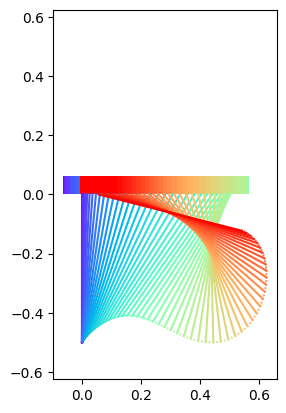

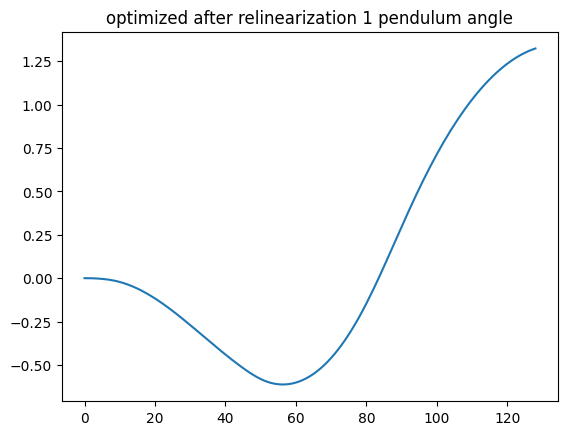

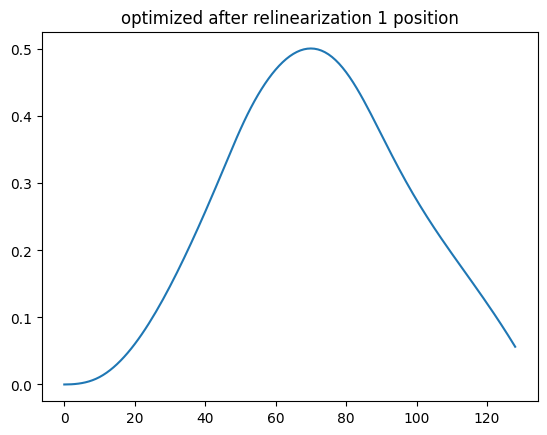

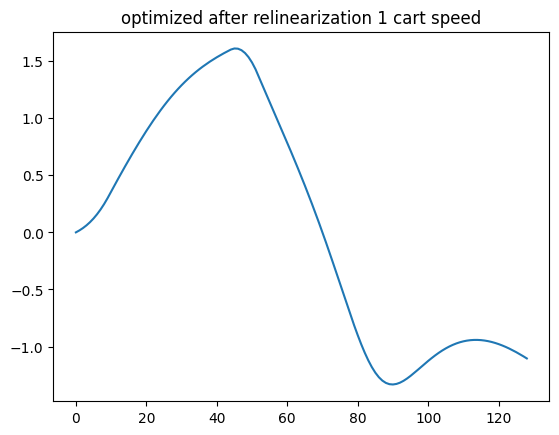

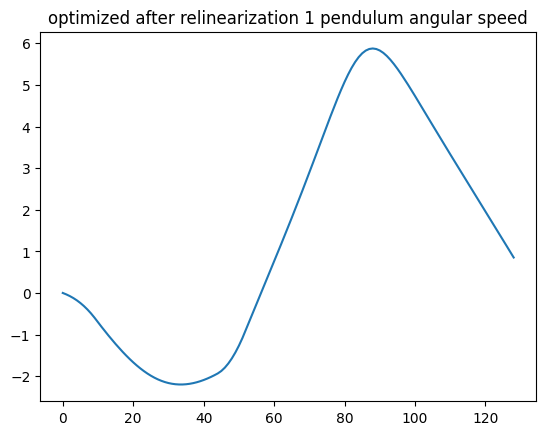

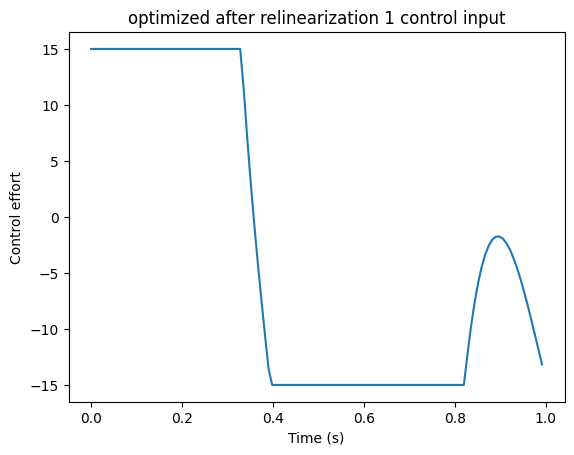

============ step 2 ============
applying control inputs to nonliner dynamics


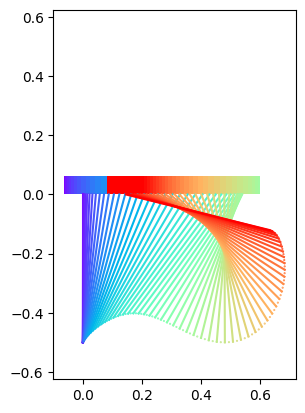

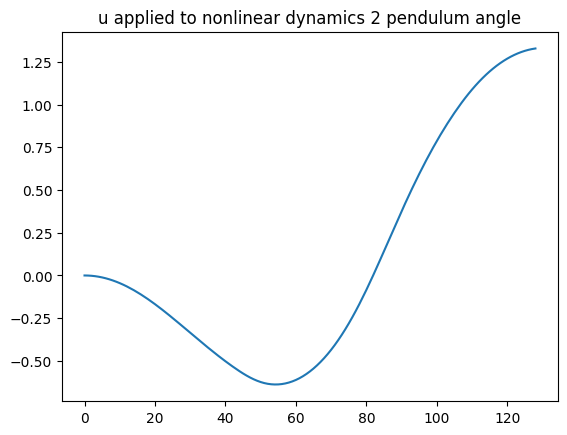

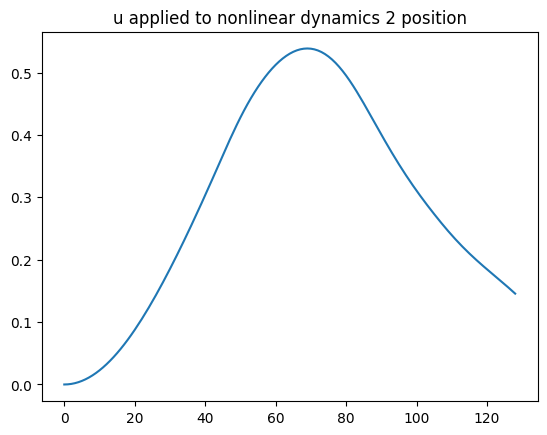

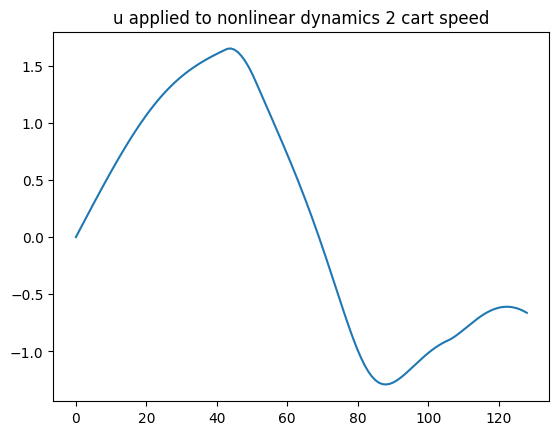

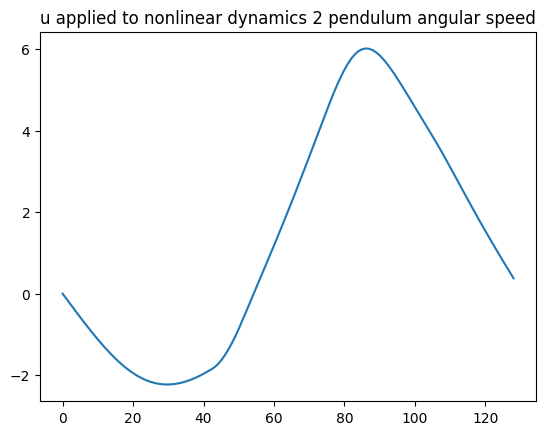

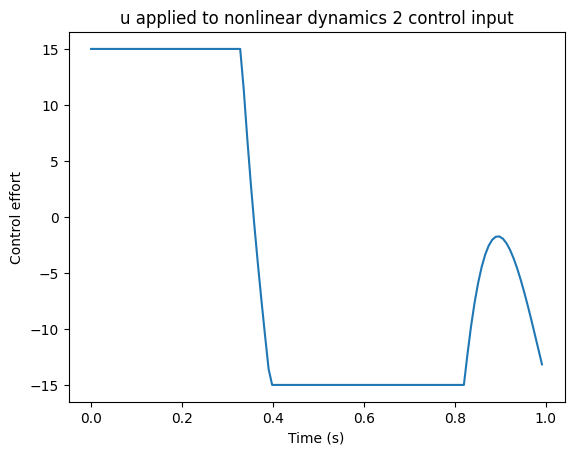

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 254268.1341217873 line search param: 0.22876792454961012
ifsnm num iters: 1 residual norm: 249628.24828913936 line search param: 0.01824800363140075
ifsnm num iters: 2 residual norm: 247667.37666892927 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 245916.45491430553 line search param: 0.007069650490151055
ifsnm num iters: 4 residual norm: 244177.91156704485 line search param: 0.007069650490151055
ifsnm num iters: 5 residual norm: 242624.28433244658 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 241080.54280302947 line search param: 0.00636268544113595
ifsnm num iters: 7 residual norm: 239700.01514337398 line search param: 0.005726416897022355
ifsnm num iters: 8 residual norm: 238327.39295014302 line search param: 0.005726416897022355
ifsnm num iters: 9 residual norm: 236962.63095266567 line search param: 0.0057

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.19403e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.08987e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 350.3777421372401
nd prev: 350.3777421372401 nd: 0.3145223180323068
fsnm num iters: 2 line search: 1.0 newton decrement: 0.3145223180323068
nd prev: 0.3145223180323068 nd: 0.26699807241115303
fsnm num iters: 3 line search: 1.0 newton decrement: 0.26699807241115303
nd prev: 0.26699807241115303 nd: 0.21007424844837608
fsnm num iters: 4 line search: 1.0 newton decrement: 0.21007424844837608
nd prev: 0.21007424844837608 nd: 0.12155375076965905
fsnm num iters: 5 line search: 1.0 newton decrement: 0.12155375076965905
nd prev: 0.12155375076965905 nd: 0.03433129223042631
fsnm num iters: 6 line search: 0.9 newton decrement: 0.03433129223042631
nd prev: 0.03433129223042631 nd: 0.0022630162097530323
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0022630162097530323
nd prev: 0.0022630162097530323 nd: 0.00023590857445396886
fsnm num iters: 8 line search: 1.0 newton decrement: 0.00023590857445396886
nd prev: 0.00023590857445396886 nd: 1.10

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.23861e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.23011e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09770368783807688
nd prev: 0.09770368783807688 nd: 0.08809823842193197
fsnm num iters: 3 line search: 1.0 newton decrement: 0.08809823842193197
nd prev: 0.08809823842193197 nd: 0.07120145579325815


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25021e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.87782e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.07120145579325815
nd prev: 0.07120145579325815 nd: 0.04335151378389937
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04335151378389937
nd prev: 0.04335151378389937 nd: 0.013330941608531498


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62327e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30851e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.013330941608531498
nd prev: 0.013330941608531498 nd: 0.0009735254498660652
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0009735254498660652
nd prev: 0.0009735254498660652 nd: 4.676648299231353e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.363e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36328e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 4.676648299231353e-06
nd prev: 4.676648299231353e-06 nd: 2.519341734809373e-10
entering fsnm loop
newton decrement: 0.6037236360222329
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6037236360222329
nd prev: 0.6037236360222329 nd: 39.516033535859016
fsnm num iters: 1 line search: 1.0 newton decrement: 39.516033535859016
nd prev: 39.516033535859016 nd: 0.030789561742642326


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24339e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24512e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.030789561742642326
nd prev: 0.030789561742642326 nd: 0.028029959152994544
fsnm num iters: 3 line search: 1.0 newton decrement: 0.028029959152994544
nd prev: 0.028029959152994544 nd: 0.022808857482425823


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25393e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88368e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.022808857482425823
nd prev: 0.022808857482425823 nd: 0.014071056019156642
fsnm num iters: 5 line search: 1.0 newton decrement: 0.014071056019156642
nd prev: 0.014071056019156642 nd: 0.0044168698083923135


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62733e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30928e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0044168698083923135
nd prev: 0.0044168698083923135 nd: 0.0003320390945708016


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36319e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0006265787482177979 newton decrement: 0.0003320390945708016
nd prev: 0.0003320390945708016 nd: 1.6661126846808015e-06
fsnm num iters: 8 line search: 0.0003699884850351276 newton decrement: 1.6661126846808015e-06
nd prev: 1.6661126846808015e-06 nd: 1.6650770603924428e-06
fsnm num iters: 9 line search: 2.1514733098945913e-05 newton decrement: 1.6650770603924428e-06
nd prev: 1.6650770603924428e-06 nd: 1.664426811844297e-06
fsnm num iters: 10 line search: 0.0016173092699229901 newton decrement: 1.664426811844297e-06
nd prev: 1.664426811844297e-06 nd: 1.6644169392525389e-06
fsnm num iters: 11 line search: 6.170365191715192e-05 newton decrement: 1.6644169392525389e-06
nd prev: 1.6644169392525389e-06 nd: 1.661725958651241e-06
fsnm num iters: 12 line search: 6.076396096647726e-06 newton decrement: 1.661725958651241e-06
nd prev: 1.661725958651241e-06 nd: 1.6616578423505752e-06
fsnm num iters: 13 line search: 8.335248417898115e-06 newton decrement: 1.661657842350

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36324e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36324e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.190913130318203
nd prev: 0.190913130318203 nd: 12.509727263398636
fsnm num iters: 1 line search: 1.0 newton decrement: 12.509727263398636
nd prev: 12.509727263398636 nd: 0.009731150916144241


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24838e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.26076e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009731150916144241
nd prev: 0.009731150916144241 nd: 0.00886611881468982
fsnm num iters: 3 line search: 1.0 newton decrement: 0.00886611881468982
nd prev: 0.00886611881468982 nd: 0.007216910375184846


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25779e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88973e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.007216910375184846
nd prev: 0.007216910375184846 nd: 0.004455458372520908
fsnm num iters: 5 line search: 1.0 newton decrement: 0.004455458372520908
nd prev: 0.004455458372520908 nd: 0.0014005467797849347


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.63141e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30992e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0005075287860564164 newton decrement: 0.0014005467797849347
nd prev: 0.0014005467797849347 nd: 0.00010600342075929232
fsnm num iters: 7 line search: 1.0 newton decrement: 0.00010600342075929232
nd prev: 0.00010600342075929232 nd: 0.00010542362149142721


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30995e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36321e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.01077526366430583 newton decrement: 0.00010542362149142721
nd prev: 0.00010542362149142721 nd: 5.291622502706597e-07
fsnm num iters: 9 line search: 0.0008595044557171439 newton decrement: 5.291622502706597e-07
nd prev: 5.291622502706597e-07 nd: 5.234474681793796e-07
fsnm num iters: 10 line search: 0.00033298963653161486 newton decrement: 5.234474681793796e-07
nd prev: 5.234474681793796e-07 nd: 5.230752770587916e-07
fsnm num iters: 11 line search: 0.00014334111979667834 newton decrement: 5.230752770587916e-07
nd prev: 5.230752770587916e-07 nd: 5.23008375858543e-07
fsnm num iters: 12 line search: 1.0 newton decrement: 5.23008375858543e-07
nd prev: 5.23008375858543e-07 nd: 5.22981854544867e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36348e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36348e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 13 line search: 1.0 newton decrement: 5.22981854544867e-07
nd prev: 5.22981854544867e-07 nd: 4.1933676507968545e-10
entering fsnm loop
newton decrement: 0.06037382066069403
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36348e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24392e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06037382066069403
nd prev: 0.06037382066069403 nd: 3.9642398765391866
fsnm num iters: 1 line search: 1.0 newton decrement: 3.9642398765391866
nd prev: 3.9642398765391866 nd: 0.0030776648957153772


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24676e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25433e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0030776648957153772
nd prev: 0.0030776648957153772 nd: 0.0028049127940822658
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0028049127940822658
nd prev: 0.0028049127940822658 nd: 0.0022844019162263324


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88432e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62777e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0022844019162263324
nd prev: 0.0022844019162263324 nd: 0.0014122147863245903
fsnm num iters: 5 line search: 0.0010611166119964739 newton decrement: 0.0014122147863245903
nd prev: 0.0014122147863245903 nd: 0.00047695872176622294


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62847e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.6287e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.00033298963653161486 newton decrement: 0.00047695872176622294
nd prev: 0.00047695872176622294 nd: 0.0004765131114679242
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0004765131114679242
nd prev: 0.0004765131114679242 nd: 0.0004447906580925964


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30951e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.3632e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 0.0004447906580925964
nd prev: 0.0004447906580925964 nd: 3.365992753466995e-05
fsnm num iters: 9 line search: 0.0010611166119964739 newton decrement: 3.365992753466995e-05
nd prev: 3.365992753466995e-05 nd: 1.7049759162763693e-07
fsnm num iters: 10 line search: 1.0 newton decrement: 1.7049759162763693e-07
nd prev: 1.7049759162763693e-07 nd: 1.704685174911765e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36348e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36348e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 11 line search: 1.0 newton decrement: 1.704685174911765e-07
nd prev: 1.704685174911765e-07 nd: 1.4114943229130657e-09
entering fsnm loop
newton decrement: 0.019091882304233854
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.019091882304233854
nd prev: 0.019091882304233854 nd: 1.2536405844040701
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2536405844040701
nd prev: 1.2536405844040701 nd: 0.0009732399144243171


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24385e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24653e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0009732399144243171
nd prev: 0.0009732399144243171 nd: 0.0008869971576828894
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008869971576828894
nd prev: 0.0008869971576828894 nd: 0.0007224018625630782


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25426e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88416e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0007224018625630782
nd prev: 0.0007224018625630782 nd: 0.0004465970787496501


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62772e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.63237e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.007069650490151055 newton decrement: 0.0004465970787496501
nd prev: 0.0004465970787496501 nd: 0.00015077626560388912
fsnm num iters: 6 line search: 0.0017970102999144335 newton decrement: 0.00015077626560388912
nd prev: 0.00015077626560388912 nd: 0.00014984214150504324
fsnm num iters: 7 line search: 1.0 newton decrement: 0.00014984214150504324
nd prev: 0.00014984214150504324 nd: 0.00013975404783252138


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.63356e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.31029e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 0.00013975404783252138
nd prev: 0.00013975404783252138 nd: 1.0499147255214152e-05
fsnm num iters: 9 line search: 1.0 newton decrement: 1.0499147255214152e-05
nd prev: 1.0499147255214152e-05 nd: 5.2691343114579065e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.3632e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36353e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0022185312344622636 newton decrement: 5.2691343114579065e-08
nd prev: 5.2691343114579065e-08 nd: 3.889731566447709e-09
entering fsnm loop
newton decrement: 0.006037384167057357
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36353e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36353e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.006037384167057357
nd prev: 0.006037384167057357 nd: 0.39644043844562116
fsnm num iters: 1 line search: 1.0 newton decrement: 0.39644043844562116
nd prev: 0.39644043844562116 nd: 0.0003077627194230191


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24335e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24608e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0003077627194230191
nd prev: 0.0003077627194230191 nd: 0.0002804926665794187
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0002804926665794187
nd prev: 0.0002804926665794187 nd: 0.00022844377744429934


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25394e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88428e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.00022844377744429934
nd prev: 0.00022844377744429934 nd: 0.0001412268190253834
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0001412268190253834
nd prev: 0.0001412268190253834 nd: 4.453715378366075e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62757e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30997e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 4.453715378366075e-05
nd prev: 4.453715378366075e-05 nd: 3.3750705486981766e-06
fsnm num iters: 7 line search: 1.0 newton decrement: 3.3750705486981766e-06
nd prev: 3.3750705486981766e-06 nd: 2.1959158241078695e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36304e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 2.1959158241078695e-08
nd prev: 2.1959158241078695e-08 nd: 1.3129412666120367e-08
entering fsnm loop
newton decrement: 0.0019091903351189383
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36304e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36304e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0019091903351189383
nd prev: 0.0019091903351189383 nd: 0.12536421967922406
fsnm num iters: 1 line search: 1.0 newton decrement: 0.12536421967922406
nd prev: 0.12536421967922406 nd: 9.732898324823134e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.2606e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.28245e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 9.732898324823134e-05
nd prev: 9.732898324823134e-05 nd: 8.869884131698248e-05
fsnm num iters: 3 line search: 1.0 newton decrement: 8.869884131698248e-05
nd prev: 8.869884131698248e-05 nd: 7.22432119884903e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.2641e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.8973e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 7.22432119884903e-05
nd prev: 7.22432119884903e-05 nd: 4.466285660203205e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.64256e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.0007735540101454295 newton decrement: 4.466285660203205e-05
nd prev: 4.466285660203205e-05 nd: 1.5083870419851289e-05
fsnm num iters: 6 line search: 4.4981962247603756e-05 newton decrement: 1.5083870419851289e-05
nd prev: 1.5083870419851289e-05 nd: 1.5081106958640431e-05
fsnm num iters: 7 line search: 1.5684240429131574e-05 newton decrement: 1.5081106958640431e-05
nd prev: 1.5081106958640431e-05 nd: 1.5081106957676448e-05
entering fsnm loop
newton decrement: 0.0005560489589358773
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=4.64256e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.64256e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0005560489589358773
nd prev: 0.0005560489589358773 nd: 0.005976764103713599
fsnm num iters: 1 line search: 1.0 newton decrement: 0.005976764103713599
nd prev: 0.005976764103713599 nd: 8.019886358577233e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.93664e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.11921e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 8.019886358577233e-06
nd prev: 8.019886358577233e-06 nd: 1.2194636990078891e-06
fsnm num iters: 3 line search: 1.0 newton decrement: 1.2194636990078891e-06
nd prev: 1.2194636990078891e-06 nd: 9.911854102380441e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.27794e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.43908e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 9.911854102380441e-08
nd prev: 9.911854102380441e-08 nd: 9.471272779838414e-08
fsnm num iters: 5 line search: 1.0 newton decrement: 9.471272779838414e-08
nd prev: 9.471272779838414e-08 nd: 9.471278307267326e-08


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.43908e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.43908e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.00019093919487132412
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.0984770902183612 newton decrement: 0.00019093919487132412
nd prev: 0.00019093919487132412 nd: 0.001683621908129528


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.93707e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 0.001683621908129528
nd prev: 0.001683621908129528 nd: 3.3633697397235003e-06
fsnm num iters: 2 line search: 1.0 newton decrement: 3.3633697397235003e-06
nd prev: 3.3633697397235003e-06 nd: 5.137619813668294e-07
fsnm num iters: 3 line search: 1.0 newton decrement: 5.137619813668294e-07
nd prev: 5.137619813668294e-07 nd: 3.3834901744332565e-07
fsnm num iters: 4 line search: 1.0 newton decrement: 3.3834901744332565e-07
nd prev: 3.3834901744332565e-07 nd: 3.383095905687192e-07
fsnm num iters: 5 line search: 1.0 newton decrement: 3.383095905687192e-07
nd prev: 3.383095905687192e-07 nd: 3.383096230699471e-07


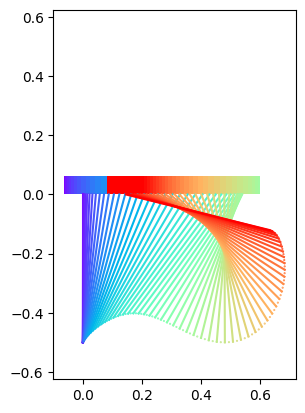

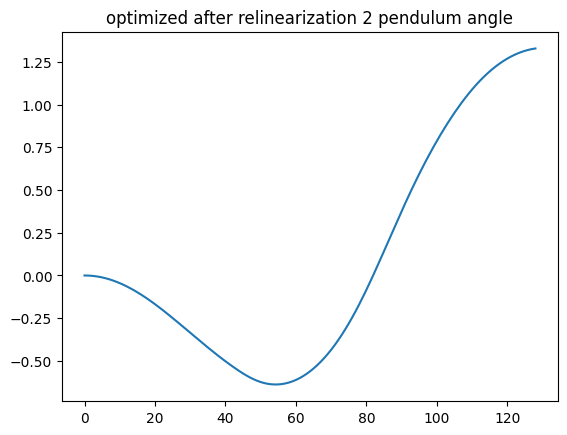

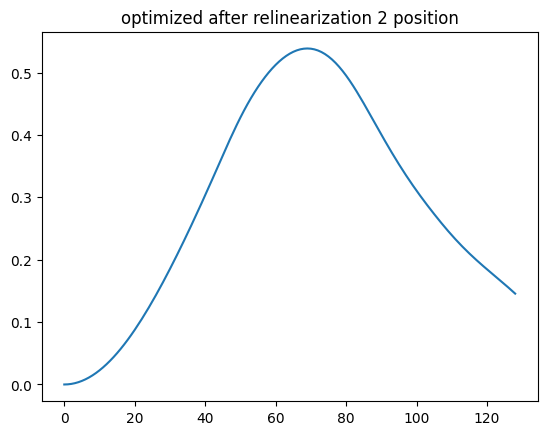

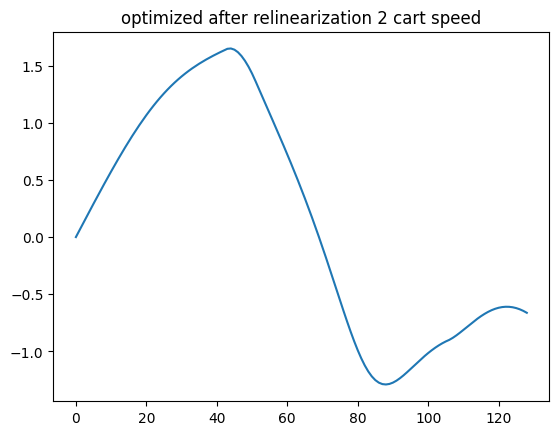

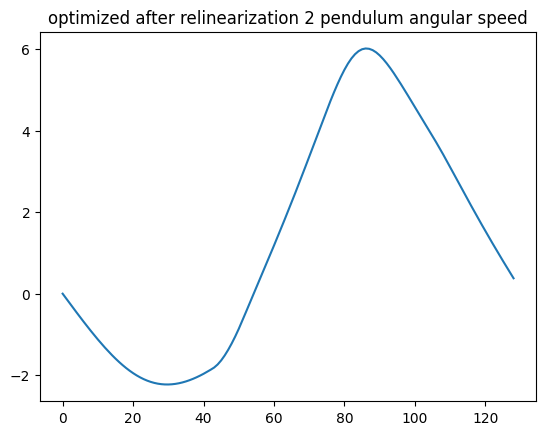

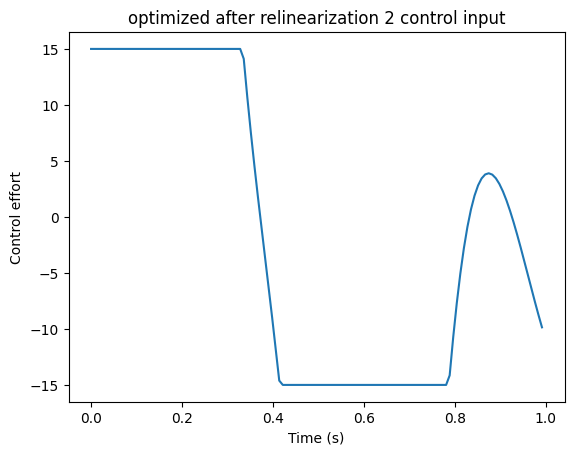

============ step 3 ============
applying control inputs to nonliner dynamics


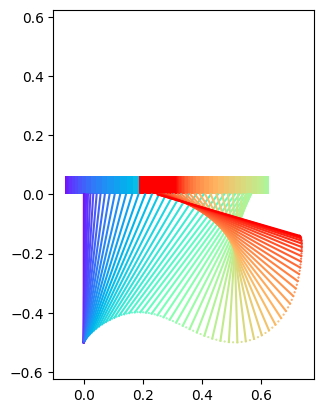

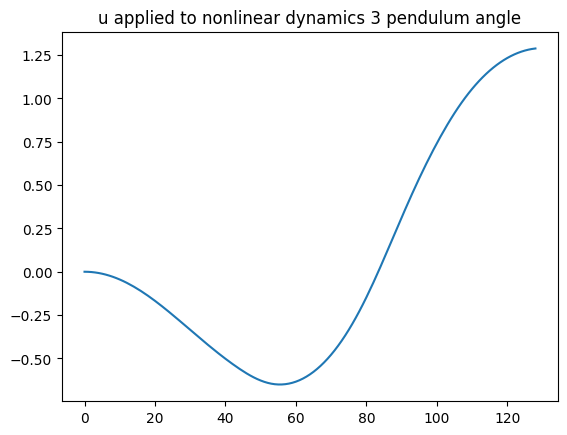

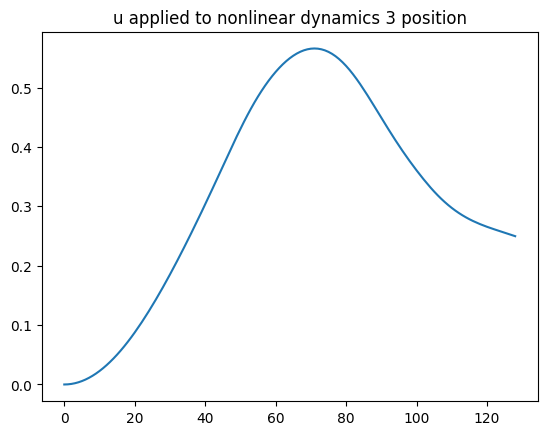

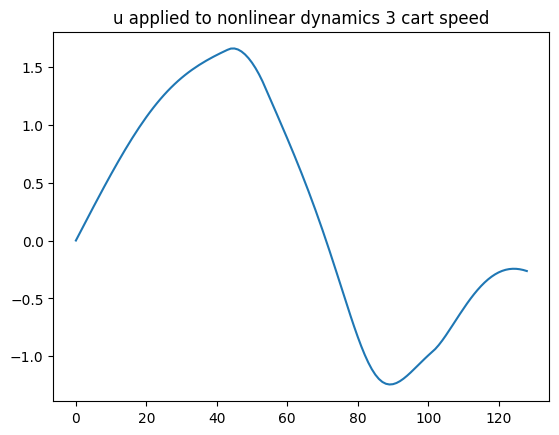

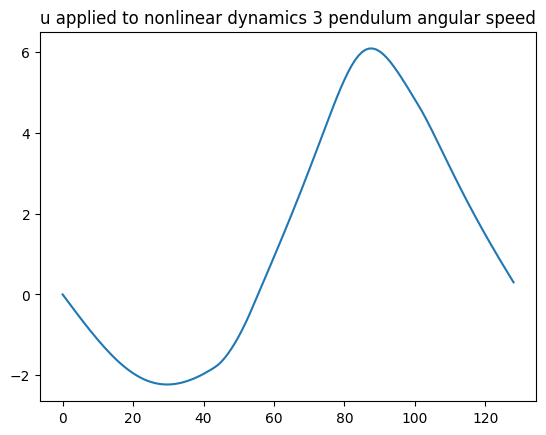

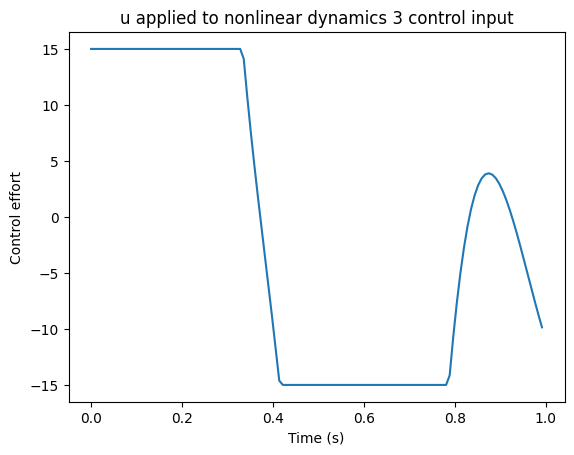

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.4025485403 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 255256.88104806736 line search param: 0.025031555049932444
ifsnm num iters: 2 residual norm: 253251.79557290653 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 251461.39393826155 line search param: 0.007069650490151055
ifsnm num iters: 4 residual norm: 249861.42422815654 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 248430.613557315 line search param: 0.005726416897022355
ifsnm num iters: 6 residual norm: 247007.99630602796 line search param: 0.005726416897022355
ifsnm num iters: 7 residual norm: 245593.5255507224 line search param: 0.005726416897022355
ifsnm num iters: 8 residual norm: 244030.8912204267 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 242478.199435752 line search param: 0.0063626854

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.19703e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.52185e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.5314410000000002 newton decrement: 342.5713171517084
nd prev: 342.5713171517084 nd: 12.300559518899675
fsnm num iters: 2 line search: 1.0 newton decrement: 12.300559518899675
nd prev: 12.300559518899675 nd: 0.28666067102702003


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=8.01237e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.28666067102702003
nd prev: 0.28666067102702003 nd: 0.23693093180307528
fsnm num iters: 4 line search: 1.0 newton decrement: 0.23693093180307528
nd prev: 0.23693093180307528 nd: 0.16065899496141314
fsnm num iters: 5 line search: 1.0 newton decrement: 0.16065899496141314
nd prev: 0.16065899496141314 nd: 0.0698803654116996
fsnm num iters: 6 line search: 1.0 newton decrement: 0.0698803654116996
nd prev: 0.0698803654116996 nd: 0.027852255787002046
fsnm num iters: 7 line search: 1.0 newton decrement: 0.027852255787002046
nd prev: 0.027852255787002046 nd: 0.018881818253443712
fsnm num iters: 8 line search: 1.0 newton decrement: 0.018881818253443712
nd prev: 0.018881818253443712 nd: 0.008246530287525032
fsnm num iters: 9 line search: 0.9 newton decrement: 0.008246530287525032
nd prev: 0.008246530287525032 nd: 0.001205570302896865
fsnm num iters: 10 line search: 1.0 newton decrement: 0.001205570302896865
nd prev: 0.001205570302896865 nd: 0.

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.23871e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.23029e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09725370811334987
nd prev: 0.09725370811334987 nd: 0.0874255083881199
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0874255083881199
nd prev: 0.0874255083881199 nd: 0.07058148447431502


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.87758e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62244e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.07058148447431502
nd prev: 0.07058148447431502 nd: 0.04296843911070643
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04296843911070643
nd prev: 0.04296843911070643 nd: 0.013161101632532127


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30723e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.3562e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.9 newton decrement: 0.013161101632532127
nd prev: 0.013161101632532127 nd: 0.0009535828820651641
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0009535828820651641
nd prev: 0.0009535828820651641 nd: 9.976763604323346e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36194e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.00017696434542799794 newton decrement: 9.976763604323346e-05
nd prev: 9.976763604323346e-05 nd: 4.9219788170343565e-08
fsnm num iters: 9 line search: 0.00026972160559060804 newton decrement: 4.9219788170343565e-08
nd prev: 4.9219788170343565e-08 nd: 4.922019247508513e-08
fsnm num iters: 10 line search: 6.751551218497473e-06 newton decrement: 4.922019247508513e-08
nd prev: 4.922019247508513e-08 nd: 4.922752999749324e-08
fsnm num iters: 11 line search: 6.751551218497473e-06 newton decrement: 4.922752999749324e-08
nd prev: 4.922752999749324e-08 nd: 4.922753485655052e-08
entering fsnm loop
newton decrement: 0.6036997915562933
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6036997915562933
nd prev: 0.6036997915562933 nd: 39.37644569685748
fsnm num iters: 1 line search: 1.0 newton decrement: 39.37644569685748
nd prev: 39.37644569685748 nd: 0.030776009926165162


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24346e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24533e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.030776009926165162
nd prev: 0.030776009926165162 nd: 0.028001241847490095
fsnm num iters: 3 line search: 1.0 newton decrement: 0.028001241847490095
nd prev: 0.028001241847490095 nd: 0.022759027451513956


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25398e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88374e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.022759027451513956
nd prev: 0.022759027451513956 nd: 0.014009001122930239
fsnm num iters: 5 line search: 1.0 newton decrement: 0.014009001122930239
nd prev: 0.014009001122930239 nd: 0.004385306358863886


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62732e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30921e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.00024274944503154723 newton decrement: 0.004385306358863886
nd prev: 0.004385306358863886 nd: 0.0003307958621651387


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30922e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0007735540101454295 newton decrement: 0.0003307958621651387
nd prev: 0.0003307958621651387 nd: 0.0003307150951530764
fsnm num iters: 8 line search: 0.5904900000000002 newton decrement: 0.0003307150951530764
nd prev: 0.0003307150951530764 nd: 0.0003294928083417419


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30926e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34102e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.00017696434542799794 newton decrement: 0.0003294928083417419
nd prev: 0.0003294928083417419 nd: 0.0001362992129266185
fsnm num iters: 10 line search: 0.0003699884850351276 newton decrement: 0.0001362992129266185
nd prev: 0.0001362992129266185 nd: 0.0001362750654091297


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34103e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 11 line search: 4.4981962247603756e-05 newton decrement: 0.0001362750654091297
nd prev: 0.0001362750654091297 nd: 0.00013622483044375248
fsnm num iters: 12 line search: 0.00045677590745077476 newton decrement: 0.00013622483044375248
nd prev: 0.00013622483044375248 nd: 0.00013621859948362332


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34104e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 13 line search: 1.1433811272836918e-05 newton decrement: 0.00013621859948362332
nd prev: 0.00013621859948362332 nd: 0.00013615663739692375
fsnm num iters: 14 line search: 8.464149782874061e-05 newton decrement: 0.00013615663739692375
nd prev: 0.00013615663739692375 nd: 0.000136155034864031
fsnm num iters: 15 line search: 0.00015926791088519815 newton decrement: 0.000136155034864031
nd prev: 0.000136155034864031 nd: 0.0001361435164437352


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34105e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 16 line search: 1.0133716178293888e-06 newton decrement: 0.0001361435164437352
nd prev: 0.0001361435164437352 nd: 0.00013612191092700237
fsnm num iters: 17 line search: 1.0133716178293888e-06 newton decrement: 0.00013612191092700237
nd prev: 0.00013612191092700237 nd: 0.00013612180318976747
entering fsnm loop
newton decrement: 0.19049021334956154
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.34123e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34123e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.19049021334956154
nd prev: 0.19049021334956154 nd: 10.921190983204514
fsnm num iters: 1 line search: 1.0 newton decrement: 10.921190983204514
nd prev: 10.921190983204514 nd: 0.009595973756437849


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.6373e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.45491e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009595973756437849
nd prev: 0.009595973756437849 nd: 0.008602027203517925
fsnm num iters: 3 line search: 1.0 newton decrement: 0.008602027203517925
nd prev: 0.008602027203517925 nd: 0.006735859399900896


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.54159e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.30356e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.006735859399900896
nd prev: 0.006735859399900896 nd: 0.00377554123910078
fsnm num iters: 5 line search: 1.0 newton decrement: 0.00377554123910078
nd prev: 0.00377554123910078 nd: 0.0009508787479375865


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.87829e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34054e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0016173092699229901 newton decrement: 0.0009508787479375865
nd prev: 0.0009508787479375865 nd: 4.695713768730305e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34058e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.00014334111979667834 newton decrement: 4.695713768730305e-05
nd prev: 4.695713768730305e-05 nd: 4.688152423096739e-05
fsnm num iters: 8 line search: 0.00021847450052839252 newton decrement: 4.688152423096739e-05
nd prev: 4.688152423096739e-05 nd: 4.687484514518632e-05
fsnm num iters: 9 line search: 0.00014334111979667834 newton decrement: 4.687484514518632e-05
nd prev: 4.687484514518632e-05 nd: 4.6864623078793385e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34059e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.3406e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0006961986091308866 newton decrement: 4.6864623078793385e-05
nd prev: 4.6864623078793385e-05 nd: 4.685789632052096e-05
fsnm num iters: 11 line search: 7.501723576108304e-06 newton decrement: 4.685789632052096e-05
nd prev: 4.685789632052096e-05 nd: 4.682539458519247e-05
fsnm num iters: 12 line search: 0.00010449567633177853 newton decrement: 4.682539458519247e-05
nd prev: 4.682539458519247e-05 nd: 4.682508469739957e-05
fsnm num iters: 13 line search: 1.0 newton decrement: 4.682508469739957e-05
nd prev: 4.682508469739957e-05 nd: 4.6715050314088456e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.34061e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36347e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 14 line search: 0.014780882941434608 newton decrement: 4.6715050314088456e-05
nd prev: 4.6715050314088456e-05 nd: 1.0657713644408781e-07
fsnm num iters: 15 line search: 5.5533286725436733e-05 newton decrement: 1.0657713644408781e-07
nd prev: 1.0657713644408781e-07 nd: 1.049678371225217e-07
fsnm num iters: 16 line search: 1.742693381014619e-05 newton decrement: 1.049678371225217e-07
nd prev: 1.049678371225217e-07 nd: 1.0496702991977167e-07
fsnm num iters: 17 line search: 2.390525899882879e-05 newton decrement: 1.0496702991977167e-07
nd prev: 1.0496702991977167e-07 nd: 1.0496484140986755e-07
fsnm num iters: 18 line search: 2.390525899882879e-05 newton decrement: 1.0496484140986755e-07
nd prev: 1.0496484140986755e-07 nd: 1.0496433112587621e-07
fsnm num iters: 19 line search: 1.742693381014619e-05 newton decrement: 1.0496433112587621e-07
nd prev: 1.0496433112587621e-07 nd: 1.0496531560889002e-07
fsnm num iters: 20 line search: 1.742693381014619e-05 newton decrement: 1.04965

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24474e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24933e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0030775499069368543
nd prev: 0.0030775499069368543 nd: 0.002804684666929031
fsnm num iters: 3 line search: 1.0 newton decrement: 0.002804684666929031
nd prev: 0.002804684666929031 nd: 0.0022839806817505355


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25497e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88533e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0022839806817505355
nd prev: 0.0022839806817505355 nd: 0.0014115915492809129
fsnm num iters: 5 line search: 0.9 newton decrement: 0.0014115915492809129
nd prev: 0.0014115915492809129 nd: 0.00044783465705082443


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.23931e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36208e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.00044783465705082443
nd prev: 0.00044783465705082443 nd: 7.720475124853362e-05
fsnm num iters: 7 line search: 0.0010611166119964739 newton decrement: 7.720475124853362e-05
nd prev: 7.720475124853362e-05 nd: 9.091508674126922e-07
fsnm num iters: 8 line search: 1.0 newton decrement: 9.091508674126922e-07
nd prev: 9.091508674126922e-07 nd: 9.083535616734627e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36354e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 7.501723576108304e-06 newton decrement: 9.083535616734627e-07
nd prev: 9.083535616734627e-07 nd: 2.243956305184227e-09
entering fsnm loop
newton decrement: 0.01909188183629573
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36354e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36354e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.01909188183629573
nd prev: 0.01909188183629573 nd: 1.2536349007056453
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2536349007056453
nd prev: 1.2536349007056453 nd: 0.000973238359578528


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24387e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.24683e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.000973238359578528
nd prev: 0.000973238359578528 nd: 0.0008869967182469066
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008869967182469066
nd prev: 0.0008869967182469066 nd: 0.0007223999482071971


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25433e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.88432e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0007223999482071971
nd prev: 0.0007223999482071971 nd: 0.00044659454772512293


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.6278e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62983e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.0030432527221704573 newton decrement: 0.00044659454772512293
nd prev: 0.00044659454772512293 nd: 0.0001508181881118269
fsnm num iters: 6 line search: 1.0 newton decrement: 0.0001508181881118269
nd prev: 0.0001508181881118269 nd: 0.00014046351030574833


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.30969e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.31019e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.00785516721127895 newton decrement: 0.00014046351030574833
nd prev: 0.00014046351030574833 nd: 1.0666549120381084e-05
fsnm num iters: 8 line search: 1.0 newton decrement: 1.0666549120381084e-05
nd prev: 1.0666549120381084e-05 nd: 1.0530197284282404e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36322e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36356e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 1.0 newton decrement: 1.0530197284282404e-05
nd prev: 1.0530197284282404e-05 nd: 5.27893588197267e-08
fsnm num iters: 10 line search: 1.0 newton decrement: 5.27893588197267e-08
nd prev: 5.27893588197267e-08 nd: 4.202696184674197e-09


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.36356e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.36356e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.0060373832499722455
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0060373832499722455
nd prev: 0.0060373832499722455 nd: 0.39643349755448615


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.24361e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.2473e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 0.39643349755448615
nd prev: 0.39643349755448615 nd: 0.00030776164755310286
fsnm num iters: 2 line search: 1.0 newton decrement: 0.00030776164755310286
nd prev: 0.00030776164755310286 nd: 0.0002804935555319536


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25409e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 0.00026972160559060804 newton decrement: 0.0002804935555319536
nd prev: 0.0002804935555319536 nd: 0.0003463601954032369
fsnm num iters: 4 line search: 0.0006265787482177979 newton decrement: 0.0003463601954032369
nd prev: 0.0003463601954032369 nd: 0.0003462526622491387


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.2549e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.00026972160559060804 newton decrement: 0.0003462526622491387
nd prev: 0.0003462526622491387 nd: 0.00034621090510402895
fsnm num iters: 6 line search: 8.335248417898115e-06 newton decrement: 0.00034621090510402895
nd prev: 0.00034621090510402895 nd: 0.0003462137734658784
fsnm num iters: 7 line search: 0.00033298963653161486 newton decrement: 0.0003462137734658784
nd prev: 0.0003462137734658784 nd: 0.0003461486286872773


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25571e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.9363259789051322e-05 newton decrement: 0.0003461486286872773
nd prev: 0.0003461486286872773 nd: 0.00034615175558495924
fsnm num iters: 9 line search: 1.0290430145553226e-05 newton decrement: 0.00034615175558495924
nd prev: 0.00034615175558495924 nd: 0.0003461515069131551
entering fsnm loop
newton decrement: 0.0008145611016824304
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.25571e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25571e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.22876792454961012 newton decrement: 0.0008145611016824304
nd prev: 0.0008145611016824304 nd: 0.0067010839511989955


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.86316e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0016173092699229901 newton decrement: 0.0067010839511989955
nd prev: 0.0067010839511989955 nd: 8.72831619437735e-05
fsnm num iters: 2 line search: 3.986723479010574e-06 newton decrement: 8.72831619437735e-05
nd prev: 8.72831619437735e-05 nd: 8.726281353380914e-05
fsnm num iters: 3 line search: 3.986723479010574e-06 newton decrement: 8.726281353380914e-05
nd prev: 8.726281353380914e-05 nd: 8.726281353380352e-05
entering fsnm loop
newton decrement: 0.00032779021157953775
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.86316e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.86316e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.1853020188851842 newton decrement: 0.00032779021157953775
nd prev: 0.00032779021157953775 nd: 0.0034693630962913807


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.60585e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0009550049507968265 newton decrement: 0.0034693630962913807
nd prev: 0.0034693630962913807 nd: 2.976003853534635e-05
fsnm num iters: 2 line search: 3.5880511311095166e-06 newton decrement: 2.976003853534635e-05
nd prev: 2.976003853534635e-05 nd: 2.9759536698813817e-05
fsnm num iters: 3 line search: 3.5880511311095166e-06 newton decrement: 2.9759536698813817e-05
nd prev: 2.9759536698813817e-05 nd: 2.9759536698803134e-05
entering fsnm loop
newton decrement: 9.684814639119617e-05
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.60585e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.60585e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 3.5880511311095166e-06 newton decrement: 9.684814639119617e-05
nd prev: 9.684814639119617e-05 nd: 9.684814639119617e-05


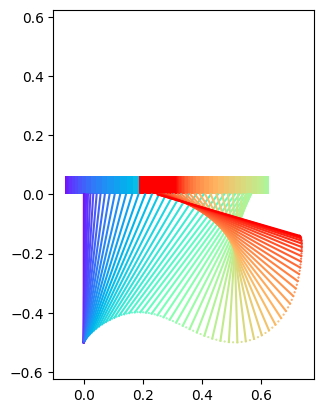

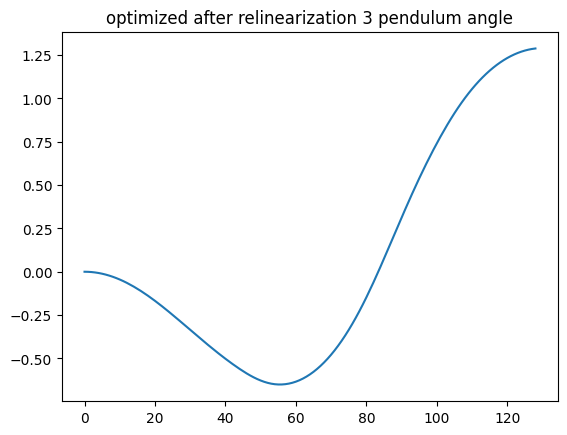

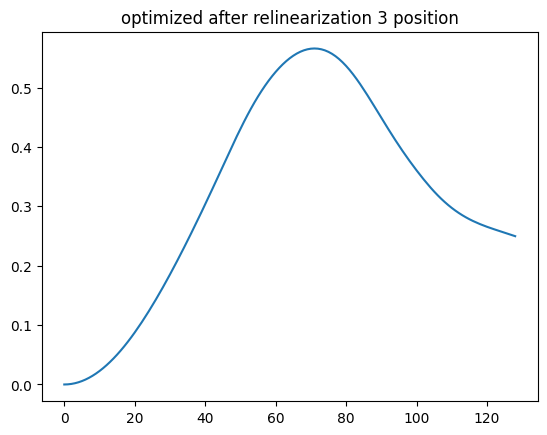

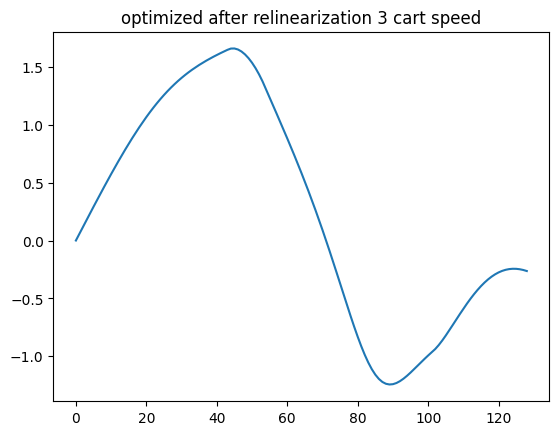

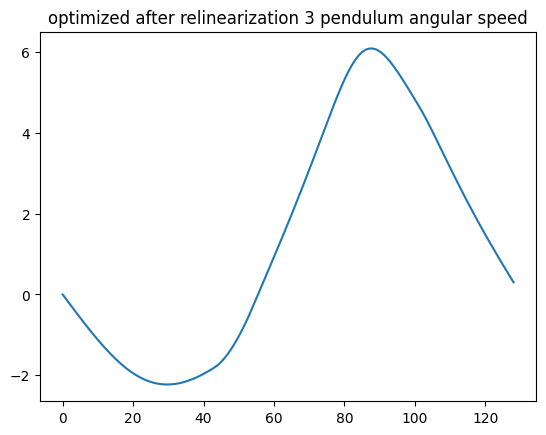

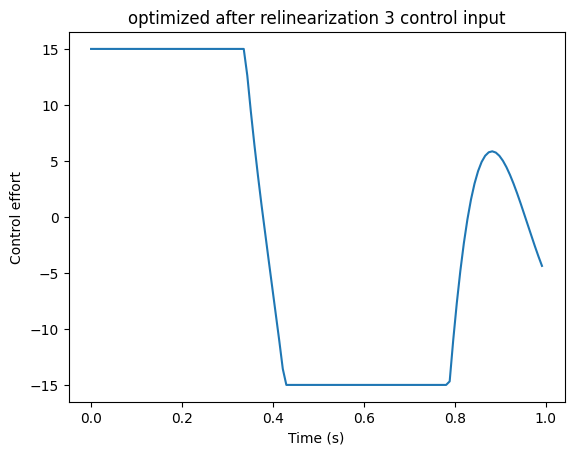

============ step 4 ============
applying control inputs to nonliner dynamics


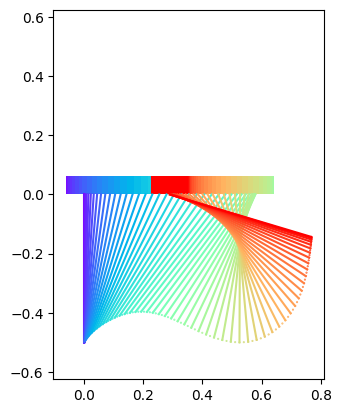

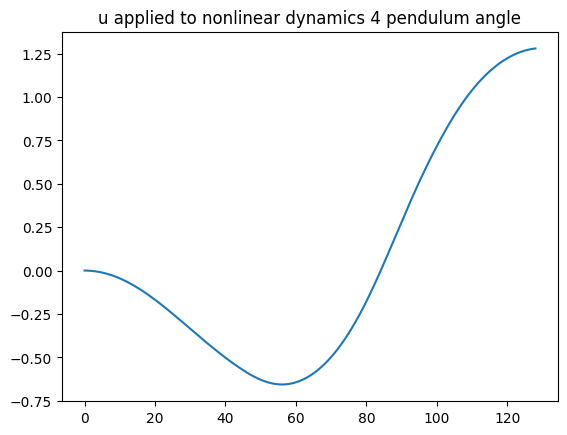

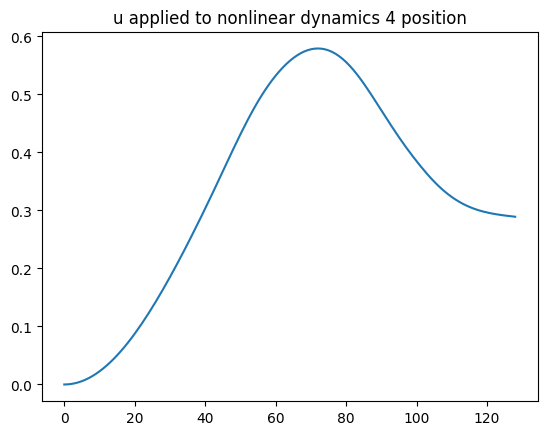

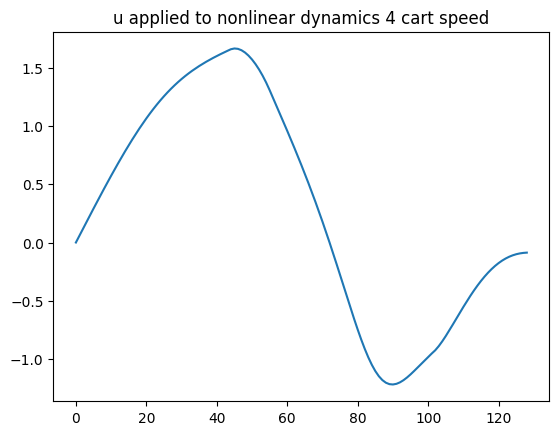

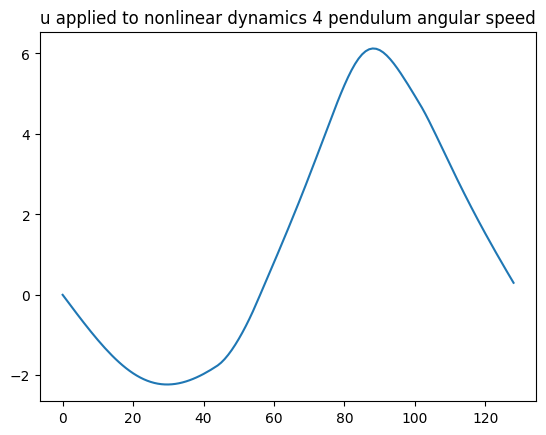

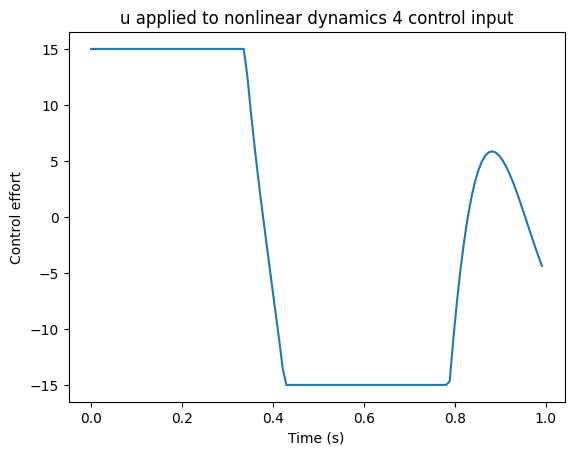

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.4025486592 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 257510.63846299407 line search param: 0.016423203268260675
ifsnm num iters: 2 residual norm: 255487.84966896323 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 253862.26085469854 line search param: 0.00636268544113595
ifsnm num iters: 4 residual norm: 252247.01516747143 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 250642.04730988937 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 249206.7664628714 line search param: 0.005726416897022355
ifsnm num iters: 7 residual norm: 247621.14221625667 line search param: 0.00636268544113595
ifsnm num iters: 8 residual norm: 246045.60679172192 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 244306.15038264063 line search param: 0.00706965

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.25544e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.29715e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.7492052745209934
nd prev: 0.7492052745209934 nd: 0.2651500850275373
fsnm num iters: 3 line search: 1.0 newton decrement: 0.2651500850275373
nd prev: 0.2651500850275373 nd: 0.20709908115310294
fsnm num iters: 4 line search: 1.0 newton decrement: 0.20709908115310294
nd prev: 0.20709908115310294 nd: 0.11903870161041125
fsnm num iters: 5 line search: 1.0 newton decrement: 0.11903870161041125
nd prev: 0.11903870161041125 nd: 0.034455047314932354
fsnm num iters: 6 line search: 1.0 newton decrement: 0.034455047314932354
nd prev: 0.034455047314932354 nd: 0.0035172322344870044
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0035172322344870044
nd prev: 0.0035172322344870044 nd: 0.00012323595873452365
fsnm num iters: 8 line search: 0.0011790184577738598 newton decrement: 0.00012323595873452365
nd prev: 0.00012323595873452365 nd: 2.136397423193459e-07
fsnm num iters: 9 line search: 4.048376602284338e-05 newton decrement: 2.136397423193

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.29503e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.42253e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09662709480825472
nd prev: 0.09662709480825472 nd: 0.08725344264021119
fsnm num iters: 3 line search: 1.0 newton decrement: 0.08725344264021119
nd prev: 0.08725344264021119 nd: 0.07034958848562996


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.30693e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.00782e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.07034958848562996
nd prev: 0.07034958848562996 nd: 0.04275466907767166
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04275466907767166
nd prev: 0.04275466907767166 nd: 0.013094208140896136


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.831e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.54622e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.013094208140896136
nd prev: 0.013094208140896136 nd: 0.0009480622093246699
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0009480622093246699
nd prev: 0.0009480622093246699 nd: 4.494981984516683e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60302e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60331e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 4.494981984516683e-06
nd prev: 4.494981984516683e-06 nd: 5.284747805127194e-10
entering fsnm loop
newton decrement: 0.6003492646119015
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6003492646119015
nd prev: 0.6003492646119015 nd: 39.22447916799345
fsnm num iters: 1 line search: 1.0 newton decrement: 39.22447916799345
nd prev: 39.22447916799345 nd: 0.03060047633713337


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.2992e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.43563e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.03060047633713337
nd prev: 0.03060047633713337 nd: 0.027861229638208994
fsnm num iters: 3 line search: 1.0 newton decrement: 0.027861229638208994
nd prev: 0.027861229638208994 nd: 0.022659293474686384


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31019e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.013e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.022659293474686384
nd prev: 0.022659293474686384 nd: 0.013962209271289739
fsnm num iters: 5 line search: 1.0 newton decrement: 0.013962209271289739
nd prev: 0.013962209271289739 nd: 0.004373828325633188


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.83473e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.54717e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.004373828325633188
nd prev: 0.004373828325633188 nd: 0.0003280759716605754
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0003280759716605754
nd prev: 0.0003280759716605754 nd: 1.6430221589588139e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60347e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60376e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 1.6430221589588139e-06
nd prev: 1.6430221589588139e-06 nd: 4.931618335370078e-10
entering fsnm loop
newton decrement: 0.1898543968776273
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.60385e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60385e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.1898543968776273
nd prev: 0.1898543968776273 nd: 12.459732259314155
fsnm num iters: 1 line search: 1.0 newton decrement: 12.459732259314155
nd prev: 12.459732259314155 nd: 0.009678025782755714


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.29962e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.43695e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009678025782755714
nd prev: 0.009678025782755714 nd: 0.008819548844440217
fsnm num iters: 3 line search: 1.0 newton decrement: 0.008819548844440217
nd prev: 0.008819548844440217 nd: 0.007181918635245361


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31051e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.01352e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.007181918635245361
nd prev: 0.007181918635245361 nd: 0.004438358737735736
fsnm num iters: 5 line search: 0.9 newton decrement: 0.004438358737735736


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.8351e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.47385e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


nd prev: 0.004438358737735736 nd: 0.001407843986040613
fsnm num iters: 6 line search: 1.0 newton decrement: 0.001407843986040613
nd prev: 0.001407843986040613 nd: 0.00024267628024284972


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60228e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0011790184577738598 newton decrement: 0.00024267628024284972
nd prev: 0.00024267628024284972 nd: 2.857420097388837e-06
fsnm num iters: 8 line search: 1.0 newton decrement: 2.857420097388837e-06
nd prev: 2.857420097388837e-06 nd: 2.853715726469384e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6038e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.001310020508637622 newton decrement: 2.853715726469384e-06
nd prev: 2.853715726469384e-06 nd: 1.2672087592656653e-09
entering fsnm loop
newton decrement: 0.06003746146640985
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.60381e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60381e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06003746146640985
nd prev: 0.06003746146640985 nd: 3.9420634740550513
fsnm num iters: 1 line search: 1.0 newton decrement: 3.9420634740550513
nd prev: 3.9420634740550513 nd: 0.003060500965122297


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.29966e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.4371e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.003060500965122297
nd prev: 0.003060500965122297 nd: 0.0027892731662938898
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0027892731662938898
nd prev: 0.0027892731662938898 nd: 0.002271650880271827


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31055e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.01358e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.002271650880271827
nd prev: 0.002271650880271827 nd: 0.0014043110188737373
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0014043110188737373
nd prev: 0.0014043110188737373 nd: 0.0004428211040858654


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.83514e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.54727e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0004428211040858654
nd prev: 0.0004428211040858654 nd: 3.3554453104877793e-05
fsnm num iters: 7 line search: 1.0 newton decrement: 3.3554453104877793e-05
nd prev: 3.3554453104877793e-05 nd: 1.705822058238909e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60352e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60381e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 1.705822058238909e-07
nd prev: 1.705822058238909e-07 nd: 1.485439684883319e-09
entering fsnm loop
newton decrement: 0.018985519716064703
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.60381e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60381e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.018985519716064703
nd prev: 0.018985519716064703 nd: 1.246651113552909
fsnm num iters: 1 line search: 1.0 newton decrement: 1.246651113552909
nd prev: 1.246651113552909 nd: 0.0009678155112430029


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.29985e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.43764e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0009678155112430029
nd prev: 0.0009678155112430029 nd: 0.0008820546659347786
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008820546659347786
nd prev: 0.0008820546659347786 nd: 0.0007183754244356223


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31065e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.01376e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0007183754244356223
nd prev: 0.0007183754244356223 nd: 0.00044410640509735144
fsnm num iters: 5 line search: 1.0 newton decrement: 0.00044410640509735144
nd prev: 0.00044410640509735144 nd: 0.0001400507631728245


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.8352e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.5472e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0001400507631728245
nd prev: 0.0001400507631728245 nd: 1.0614046357850322e-05
fsnm num iters: 7 line search: 1.0 newton decrement: 1.0614046357850322e-05
nd prev: 1.0614046357850322e-05 nd: 5.359390171647299e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60352e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60388e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 5.359390171647299e-08
nd prev: 5.359390171647299e-08 nd: 4.067071225502388e-09
entering fsnm loop
newton decrement: 0.006003751199569981
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.60388e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60388e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.006003751199569981
nd prev: 0.006003751199569981 nd: 0.39424201679729903
fsnm num iters: 1 line search: 1.0 newton decrement: 0.39424201679729903
nd prev: 0.39424201679729903 nd: 0.0003060526570677222


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.29878e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.43269e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0003060526570677222
nd prev: 0.0003060526570677222 nd: 0.0002789318047371922
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0002789318047371922
nd prev: 0.0002789318047371922 nd: 0.00022717394723176262


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.30946e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.0117e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.00022717394723176262
nd prev: 0.00022717394723176262 nd: 0.00014044472957599018
fsnm num iters: 5 line search: 1.0 newton decrement: 0.00014044472957599018
nd prev: 0.00014044472957599018 nd: 4.429363937390235e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.83439e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.54668e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 4.429363937390235e-05
nd prev: 4.429363937390235e-05 nd: 3.3580326577961462e-06
fsnm num iters: 7 line search: 1.0 newton decrement: 3.3580326577961462e-06
nd prev: 3.3580326577961462e-06 nd: 2.1622009654615725e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60282e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60458e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 2.1622009654615725e-08
nd prev: 2.1622009654615725e-08 nd: 1.2766394130682834e-08
entering fsnm loop
newton decrement: 0.0018985535445901192
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.60458e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60458e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0018985535445901192
nd prev: 0.0018985535445901192 nd: 0.12466037529183041
fsnm num iters: 1 line search: 1.0 newton decrement: 0.12466037529183041
nd prev: 0.12466037529183041 nd: 9.678544460790426e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.29878e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.4228e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 9.678544460790426e-05
nd prev: 9.678544460790426e-05 nd: 8.820010539775656e-05
fsnm num iters: 3 line search: 1.0 newton decrement: 8.820010539775656e-05
nd prev: 8.820010539775656e-05 nd: 7.183885661148294e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.30946e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.01041e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 7.183885661148294e-05
nd prev: 7.183885661148294e-05 nd: 4.441264189712801e-05
fsnm num iters: 5 line search: 1.0 newton decrement: 4.441264189712801e-05
nd prev: 4.441264189712801e-05 nd: 1.4008121788070804e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.83766e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.54843e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 1.4008121788070804e-05
nd prev: 1.4008121788070804e-05 nd: 1.0588788752407529e-06
fsnm num iters: 7 line search: 1.0 newton decrement: 1.0588788752407529e-06
nd prev: 1.0588788752407529e-06 nd: 3.7524143119312785e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60106e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 3.7524143119312785e-08
nd prev: 3.7524143119312785e-08 nd: 3.711018486059827e-08
fsnm num iters: 9 line search: 1.0 newton decrement: 3.711018486059827e-08
nd prev: 3.711018486059827e-08 nd: 3.711032250804958e-08
fsnm num iters: 10 line search: 1.0 newton decrement: 3.711032250804958e-08
nd prev: 3.711032250804958e-08 nd: 3.7110162927468e-08
fsnm num iters: 11 line search: 1.0 newton decrement: 3.7110162927468e-08
nd prev: 3.7110162927468e-08 nd: 3.711033931018975e-08
fsnm num iters: 12 line search: 1.0 newton decrement: 3.711033931018975e-08
nd prev: 3.711033931018975e-08 nd: 3.711021729096959e-08
fsnm num iters: 13 line search: 1.0 newton decrement: 3.711021729096959e-08
nd prev: 3.711021729096959e-08 nd: 3.7110027797875084e-08
fsnm num iters: 14 line search: 1.0 newton decrement: 3.7110027797875084e-08
nd prev: 3.7110027797875084e-08 nd: 3.7110352034143355e-08
fsnm num iters: 15 line search: 1.0 newton decrement: 3.711035203414335

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.60106e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.60106e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0006003700158350569
nd prev: 0.0006003700158350569 nd: 0.03944418563706701


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.11809e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0006265787482177979 newton decrement: 0.03944418563706701
nd prev: 0.03944418563706701 nd: 5.654883024064179e-05
fsnm num iters: 2 line search: 9.261387130997904e-06 newton decrement: 5.654883024064179e-05
nd prev: 5.654883024064179e-05 nd: 5.655019534616937e-05
fsnm num iters: 3 line search: 9.261387130997904e-06 newton decrement: 5.655019534616937e-05
nd prev: 5.655019534616937e-05 nd: 5.6550195346169124e-05
entering fsnm loop
newton decrement: 1.1041999491320688e-05
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=1.11809e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.11809e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 1.0 newton decrement: 1.1041999491320688e-05
nd prev: 1.1041999491320688e-05 nd: 2.3408548045341554e-05
fsnm num iters: 1 line search: 1.0 newton decrement: 2.3408548045341554e-05
nd prev: 2.3408548045341554e-05 nd: 4.576401085199059e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.20857e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.45089e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 4.576401085199059e-06
nd prev: 4.576401085199059e-06 nd: 1.6089146113096398e-06
fsnm num iters: 3 line search: 1.0 newton decrement: 1.6089146113096398e-06
nd prev: 1.6089146113096398e-06 nd: 4.3446104405155685e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.96929e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 4.3446104405155685e-07
nd prev: 4.3446104405155685e-07 nd: 4.0063617529897766e-07
fsnm num iters: 5 line search: 1.0 newton decrement: 4.0063617529897766e-07
nd prev: 4.0063617529897766e-07 nd: 4.006361498248666e-07


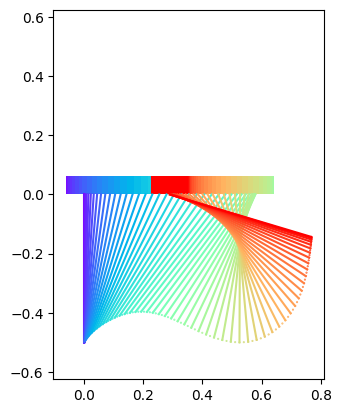

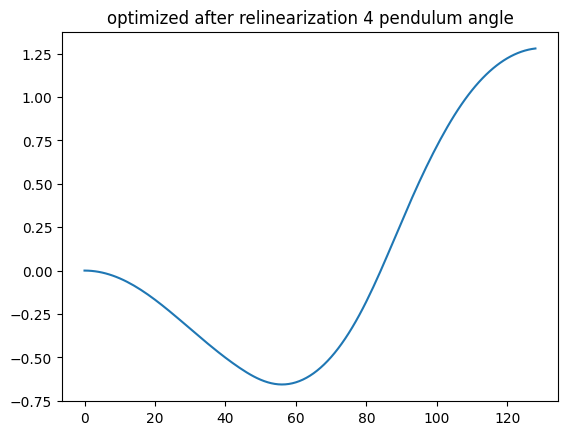

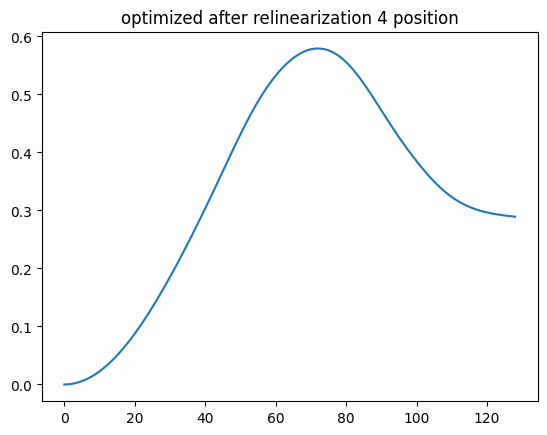

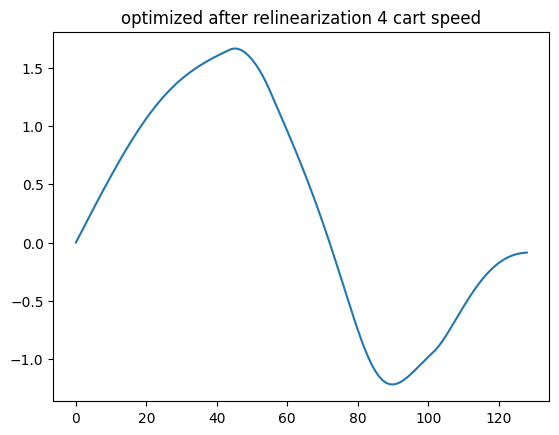

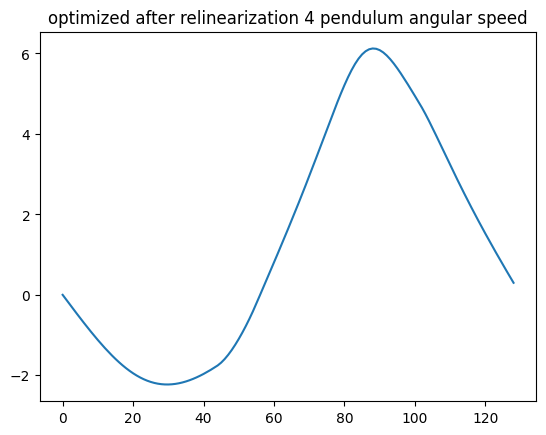

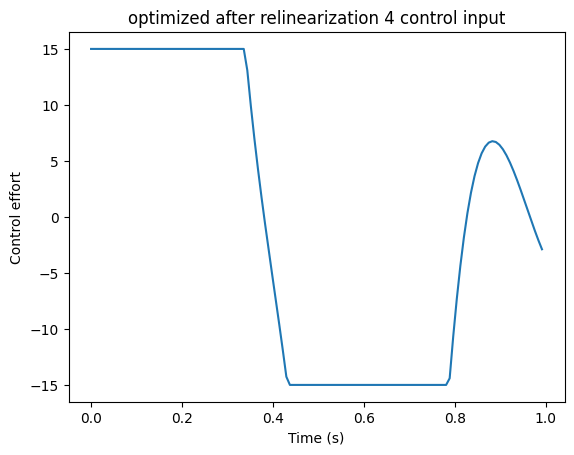

============ step 5 ============
applying control inputs to nonliner dynamics


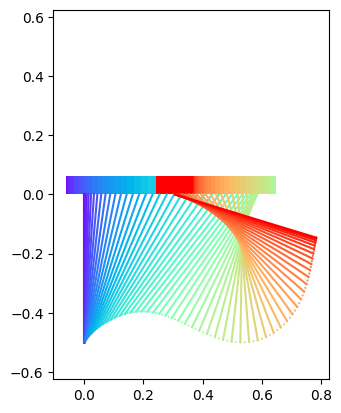

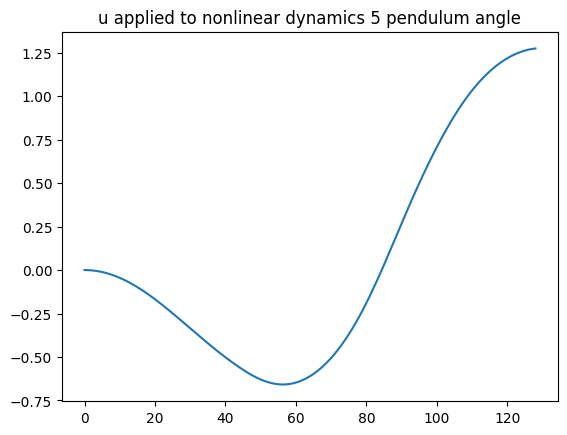

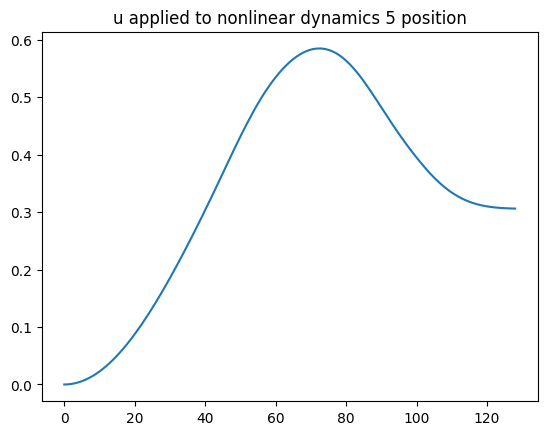

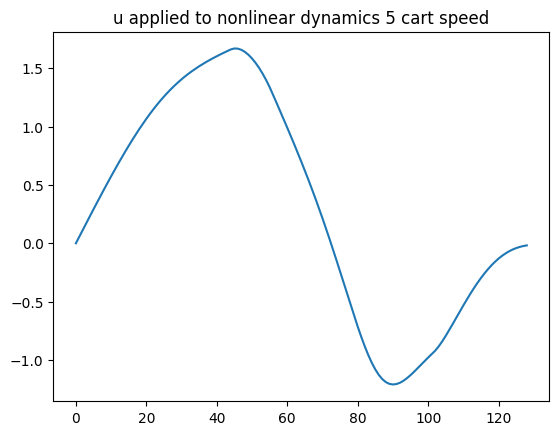

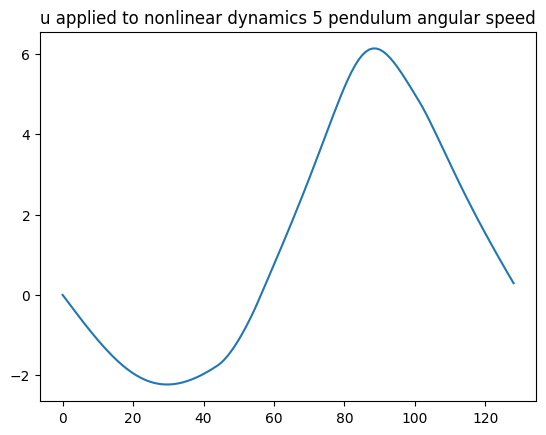

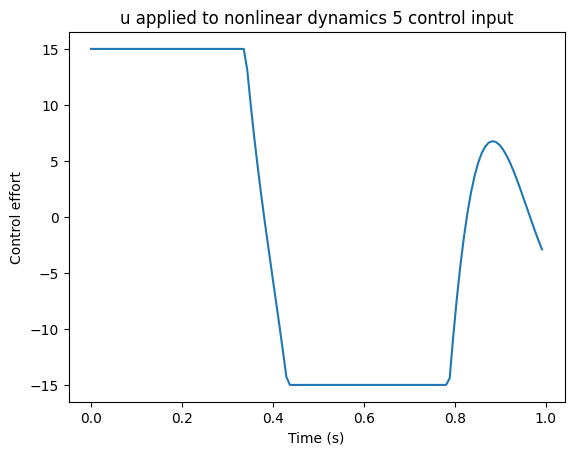

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.40254870505 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 258327.59270337984 line search param: 0.013302794647291147
ifsnm num iters: 2 residual norm: 256298.41124823035 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 254667.66508679136 line search param: 0.00636268544113595
ifsnm num iters: 4 residual norm: 253047.2948648685 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 251437.23465759068 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 249837.41960604832 line search param: 0.00636268544113595
ifsnm num iters: 7 residual norm: 248247.78279242656 line search param: 0.00636268544113595
ifsnm num iters: 8 residual norm: 246668.26025205824 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 244924.40190714665 line search param: 0.00706965

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.26676e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.67051e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.5314410000000002 newton decrement: 338.8148487864172
nd prev: 338.8148487864172 nd: 12.194325200573212
fsnm num iters: 2 line search: 1.0 newton decrement: 12.194325200573212
nd prev: 12.194325200573212 nd: 0.281999427699435


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=8.48868e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.281999427699435
nd prev: 0.281999427699435 nd: 0.23450458999806703
fsnm num iters: 4 line search: 1.0 newton decrement: 0.23450458999806703
nd prev: 0.23450458999806703 nd: 0.15883134917346042
fsnm num iters: 5 line search: 1.0 newton decrement: 0.15883134917346042
nd prev: 0.15883134917346042 nd: 0.0690382953710141
fsnm num iters: 6 line search: 1.0 newton decrement: 0.0690382953710141
nd prev: 0.0690382953710141 nd: 0.027751960493669493
fsnm num iters: 7 line search: 1.0 newton decrement: 0.027751960493669493
nd prev: 0.027751960493669493 nd: 0.01875701302321931
fsnm num iters: 8 line search: 1.0 newton decrement: 0.01875701302321931
nd prev: 0.01875701302321931 nd: 0.008113748605928384
fsnm num iters: 9 line search: 0.9 newton decrement: 0.008113748605928384
nd prev: 0.008113748605928384 nd: 0.0011624003858919881
fsnm num iters: 10 line search: 1.0 newton decrement: 0.0011624003858919881
nd prev: 0.0011624003858919881 nd: 0.0001

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.30998e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.47383e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09636971033554194
nd prev: 0.09636971033554194 nd: 0.0870788506287794
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0870788506287794
nd prev: 0.0870788506287794 nd: 0.07025402645020666


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32223e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.04352e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.07025402645020666
nd prev: 0.07025402645020666 nd: 0.04269976631812719
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04269976631812719
nd prev: 0.04269976631812719 nd: 0.01306971953309068


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.88932e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61389e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.01306971953309068
nd prev: 0.01306971953309068 nd: 0.0009461317215094064


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6715e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.01077526366430583 newton decrement: 0.0009461317215094064
nd prev: 0.0009461317215094064 nd: 4.4881811183401015e-06
fsnm num iters: 8 line search: 0.001310020508637622 newton decrement: 4.4881811183401015e-06
nd prev: 4.4881811183401015e-06 nd: 4.439825696607486e-06
fsnm num iters: 9 line search: 1.0 newton decrement: 4.439825696607486e-06
nd prev: 4.439825696607486e-06 nd: 4.43389694151367e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6718e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 1.0 newton decrement: 4.43389694151367e-06
nd prev: 4.43389694151367e-06 nd: 1.1843297799166945e-09
entering fsnm loop
newton decrement: 0.6003413702164803
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6003413702164803
nd prev: 0.6003413702164803 nd: 39.18592958232455
fsnm num iters: 1 line search: 1.0 newton decrement: 39.18592958232455
nd prev: 39.18592958232455 nd: 0.03059228073495308


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31498e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.48954e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.03059228073495308
nd prev: 0.03059228073495308 nd: 0.027851836891326472
fsnm num iters: 3 line search: 1.0 newton decrement: 0.027851836891326472
nd prev: 0.027851836891326472 nd: 0.022643519145404915


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32612e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.0497e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.022643519145404915
nd prev: 0.022643519145404915 nd: 0.013944337061636955
fsnm num iters: 5 line search: 1.0 newton decrement: 0.013944337061636955
nd prev: 0.013944337061636955 nd: 0.004366556827574449


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.89373e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61494e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.004366556827574449
nd prev: 0.004366556827574449 nd: 0.00032760235529819454


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67195e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0006961986091308866 newton decrement: 0.00032760235529819454
nd prev: 0.00032760235529819454 nd: 1.6408983206726145e-06
fsnm num iters: 8 line search: 0.00017696434542799794 newton decrement: 1.6408983206726145e-06
nd prev: 1.6408983206726145e-06 nd: 1.6397750301662673e-06
fsnm num iters: 9 line search: 8.335248417898115e-06 newton decrement: 1.6397750301662673e-06
nd prev: 1.6397750301662673e-06 nd: 1.639515913711003e-06
fsnm num iters: 10 line search: 8.335248417898115e-06 newton decrement: 1.639515913711003e-06
nd prev: 1.639515913711003e-06 nd: 1.6395148222764007e-06
entering fsnm loop
newton decrement: 0.189849011472081
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.67203e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67203e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.189849011472081
nd prev: 0.189849011472081 nd: 12.435664658502112
fsnm num iters: 1 line search: 1.0 newton decrement: 12.435664658502112
nd prev: 12.435664658502112 nd: 0.009676144426350555


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32027e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50611e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009676144426350555
nd prev: 0.009676144426350555 nd: 0.008816063968397049
fsnm num iters: 3 line search: 1.0 newton decrement: 0.008816063968397049
nd prev: 0.008816063968397049 nd: 0.00717549078022267


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33022e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.05611e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.00717549078022267
nd prev: 0.00717549078022267 nd: 0.004428869035137915
fsnm num iters: 5 line search: 0.9 newton decrement: 0.004428869035137915
nd prev: 0.004428869035137915 nd: 0.0014007188869085713


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.89808e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.54168e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0014007188869085713
nd prev: 0.0014007188869085713 nd: 0.00024089068504830826


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67076e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0006265787482177979 newton decrement: 0.00024089068504830826
nd prev: 0.00024089068504830826 nd: 2.815446737259824e-06
fsnm num iters: 8 line search: 0.0010611166119964739 newton decrement: 2.815446737259824e-06
nd prev: 2.815446737259824e-06 nd: 2.8135416352012794e-06
fsnm num iters: 9 line search: 1.0 newton decrement: 2.8135416352012794e-06
nd prev: 2.8135416352012794e-06 nd: 2.8101985604969124e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67077e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67228e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 1.0 newton decrement: 2.8101985604969124e-06
nd prev: 2.8101985604969124e-06 nd: 1.4296878856922547e-09
entering fsnm loop
newton decrement: 0.06003745463581689
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.67229e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67229e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06003745463581689
nd prev: 0.06003745463581689 nd: 3.9420022711213547
fsnm num iters: 1 line search: 1.0 newton decrement: 3.9420022711213547
nd prev: 3.9420022711213547 nd: 0.003060493211828247


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31554e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.49131e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.003060493211828247
nd prev: 0.003060493211828247 nd: 0.0027892642897509616
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0027892642897509616
nd prev: 0.0027892642897509616 nd: 0.002271634360602422


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32656e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.0504e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.002271634360602422
nd prev: 0.002271634360602422 nd: 0.0014042867167717867
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0014042867167717867
nd prev: 0.0014042867167717867 nd: 0.0004428033464429461


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.89423e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61506e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0007735540101454295 newton decrement: 0.0004428033464429461
nd prev: 0.0004428033464429461 nd: 3.37210794294923e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61509e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 3.279185047850314e-05 newton decrement: 3.37210794294923e-05
nd prev: 3.37210794294923e-05 nd: 3.3695173456941866e-05
fsnm num iters: 8 line search: 3.279185047850314e-05 newton decrement: 3.3695173456941866e-05
nd prev: 3.3695173456941866e-05 nd: 3.369429679241597e-05
fsnm num iters: 9 line search: 0.00024274944503154723 newton decrement: 3.369429679241597e-05
nd prev: 3.369429679241597e-05 nd: 3.369338289752262e-05
fsnm num iters: 10 line search: 0.00015926791088519815 newton decrement: 3.369338289752262e-05
nd prev: 3.369338289752262e-05 nd: 3.368519804968216e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61511e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61513e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 11 line search: 0.0005639208733960181 newton decrement: 3.368519804968216e-05
nd prev: 3.368519804968216e-05 nd: 3.367927527867865e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61516e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 12 line search: 0.0005639208733960181 newton decrement: 3.367927527867865e-05
nd prev: 3.367927527867865e-05 nd: 3.366030369350731e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6152e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 13 line search: 3.6435389420559045e-05 newton decrement: 3.366030369350731e-05
nd prev: 3.366030369350731e-05 nd: 3.3641434945627724e-05
fsnm num iters: 14 line search: 3.279185047850314e-05 newton decrement: 3.3641434945627724e-05
nd prev: 3.3641434945627724e-05 nd: 3.36404995380677e-05
fsnm num iters: 15 line search: 3.279185047850314e-05 newton decrement: 3.36404995380677e-05
nd prev: 3.36404995380677e-05 nd: 3.363962284437644e-05
fsnm num iters: 16 line search: 3.279185047850314e-05 newton decrement: 3.363962284437644e-05
nd prev: 3.363962284437644e-05 nd: 3.3638746185729395e-05
fsnm num iters: 17 line search: 1.0290430145553226e-05 newton decrement: 3.3638746185729395e-05
nd prev: 3.3638746185729395e-05 nd: 3.3637873514013e-05
fsnm num iters: 18 line search: 2.390525899882879e-05 newton decrement: 3.3637873514013e-05
nd prev: 3.3637873514013e-05 nd: 3.363777438868216e-05
fsnm num iters: 19 line search: 3.6435389420559045e-05 newton decrement: 3.363777438868216e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61522e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 21 line search: 0.0006961986091308866 newton decrement: 3.36363503566606e-05
nd prev: 3.36363503566606e-05 nd: 3.363040690810581e-05
fsnm num iters: 22 line search: 1.0 newton decrement: 3.363040690810581e-05
nd prev: 3.363040690810581e-05 nd: 3.343880380519399e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61525e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67201e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 23 line search: 0.003757102126136367 newton decrement: 3.343880380519399e-05
nd prev: 3.343880380519399e-05 nd: 1.6917591057692282e-07
fsnm num iters: 24 line search: 5.5533286725436733e-05 newton decrement: 1.6917591057692282e-07
nd prev: 1.6917591057692282e-07 nd: 1.688715722176696e-07
fsnm num iters: 25 line search: 1.9363259789051322e-05 newton decrement: 1.688715722176696e-07
nd prev: 1.688715722176696e-07 nd: 1.688715719794106e-07
entering fsnm loop
newton decrement: 0.018984985736902854
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.67201e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67201e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.018984985736902854
nd prev: 0.018984985736902854 nd: 1.2443527650282737
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2443527650282737
nd prev: 1.2443527650282737 nd: 0.000967649127043725


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.3202e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50572e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.000967649127043725
nd prev: 0.000967649127043725 nd: 0.0008817237313318791
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008817237313318791
nd prev: 0.0008817237313318791 nd: 0.0007177651545791903


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33008e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.05588e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 0.47829690000000014 newton decrement: 0.0007177651545791903
nd prev: 0.0007177651545791903 nd: 0.0004977630462464301
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0004977630462464301
nd prev: 0.0004977630462464301 nd: 0.0003105079648945469


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.88299e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.33923e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0005639208733960181 newton decrement: 0.0003105079648945469
nd prev: 0.0003105079648945469 nd: 6.284367238356539e-05
fsnm num iters: 7 line search: 1.0 newton decrement: 6.284367238356539e-05
nd prev: 6.284367238356539e-05 nd: 6.0994528700025667e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.3394e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66214e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.0011790184577738598 newton decrement: 6.0994528700025667e-05
nd prev: 6.0994528700025667e-05 nd: 1.8703717770444001e-06
fsnm num iters: 9 line search: 0.00021847450052839252 newton decrement: 1.8703717770444001e-06
nd prev: 1.8703717770444001e-06 nd: 1.8692127149658494e-06
fsnm num iters: 10 line search: 0.00045677590745077476 newton decrement: 1.8692127149658494e-06
nd prev: 1.8692127149658494e-06 nd: 1.8691579299853888e-06
fsnm num iters: 11 line search: 9.404610869860067e-05 newton decrement: 1.8691579299853888e-06
nd prev: 1.8691579299853888e-06 nd: 1.8689673314689276e-06
fsnm num iters: 12 line search: 1.742693381014619e-05 newton decrement: 1.8689673314689276e-06
nd prev: 1.8689673314689276e-06 nd: 1.8689578083462824e-06
fsnm num iters: 13 line search: 1.742693381014619e-05 newton decrement: 1.8689578083462824e-06
nd prev: 1.8689578083462824e-06 nd: 1.8689578113571305e-06
entering fsnm loop
newton decrement: 0.0059978386529029645
stupid feasible n

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.66214e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66214e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0059978386529029645
nd prev: 0.0059978386529029645 nd: 0.3702720348445248
fsnm num iters: 1 line search: 1.0 newton decrement: 0.3702720348445248
nd prev: 0.3702720348445248 nd: 0.0003041741142025524


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.48635e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.02324e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0003041741142025524
nd prev: 0.0003041741142025524 nd: 0.00027525999342645224


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.4557e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.24685e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.00027525999342645224
nd prev: 0.00027525999342645224 nd: 0.00022043174518636416
fsnm num iters: 4 line search: 1.0 newton decrement: 0.00022043174518636416
nd prev: 0.00022043174518636416 nd: 0.00013065396755179077


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.01924e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.03776e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.030903154382632643 newton decrement: 0.00013065396755179077
nd prev: 0.00013065396755179077 nd: 3.950005385221664e-05
fsnm num iters: 6 line search: 0.01077526366430583 newton decrement: 3.950005385221664e-05
nd prev: 3.950005385221664e-05 nd: 3.8397829246575295e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.0445e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.63591e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 1.0 newton decrement: 3.8397829246575295e-05
nd prev: 3.8397829246575295e-05 nd: 3.597966434130712e-05
fsnm num iters: 8 line search: 1.0 newton decrement: 3.597966434130712e-05
nd prev: 3.597966434130712e-05 nd: 2.1591740362371043e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67161e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.67161e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 1.0 newton decrement: 2.1591740362371043e-06
nd prev: 2.1591740362371043e-06 nd: 1.303030770731484e-08
entering fsnm loop
newton decrement: 0.0018985524899948153
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67161e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32594e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0018985524899948153
nd prev: 0.0018985524899948153 nd: 0.12467198407272044
fsnm num iters: 1 line search: 1.0 newton decrement: 0.12467198407272044
nd prev: 0.12467198407272044 nd: 9.67816401318038e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5153e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32818e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 9.67816401318038e-05
nd prev: 9.67816401318038e-05 nd: 8.821235196409261e-05
fsnm num iters: 3 line search: 1.0 newton decrement: 8.821235196409261e-05
nd prev: 8.821235196409261e-05 nd: 7.184491362679826e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.0471e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.8889e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 7.184491362679826e-05
nd prev: 7.184491362679826e-05 nd: 4.442078878729687e-05
fsnm num iters: 5 line search: 1.0 newton decrement: 4.442078878729687e-05
nd prev: 4.442078878729687e-05 nd: 1.4011844937418273e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.61098e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66446e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 1.4011844937418273e-05
nd prev: 1.4011844937418273e-05 nd: 1.0690812413306341e-06
fsnm num iters: 7 line search: 1.0 newton decrement: 1.0690812413306341e-06
nd prev: 1.0690812413306341e-06 nd: 3.773961805966671e-08
fsnm num iters: 8 line search: 1.0 newton decrement: 3.773961805966671e-08
nd prev: 3.773961805966671e-08 nd: 3.690483072391203e-08
fsnm num iters: 9 line search: 1.0 newton decrement: 3.690483072391203e-08
nd prev: 3.690483072391203e-08 nd: 3.69048389014367e-08


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.66446e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66446e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.000600374713322921
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.000600374713322921
nd prev: 0.000600374713322921 nd: 0.039440983553959405


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.40922e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.56589e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 0.039440983553959405
nd prev: 0.039440983553959405 nd: 3.0659036218695156e-05
fsnm num iters: 2 line search: 1.0 newton decrement: 3.0659036218695156e-05
nd prev: 3.0659036218695156e-05 nd: 2.790226135498084e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.35426e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.11298e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 2.790226135498084e-05
nd prev: 2.790226135498084e-05 nd: 2.273755068653528e-05
fsnm num iters: 4 line search: 1.0 newton decrement: 2.273755068653528e-05
nd prev: 2.273755068653528e-05 nd: 1.4079369864849536e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.90551e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.59321e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 1.4079369864849536e-05
nd prev: 1.4079369864849536e-05 nd: 4.468427455883656e-06
fsnm num iters: 6 line search: 0.0016173092699229901 newton decrement: 4.468427455883656e-06
nd prev: 4.468427455883656e-06 nd: 3.636058965611181e-07
fsnm num iters: 7 line search: 0.001996678111016037 newton decrement: 3.636058965611181e-07
nd prev: 3.636058965611181e-07 nd: 3.636059178429984e-07
entering fsnm loop
newton decrement: 0.00018875997944310793
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.59321e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.59321e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.00018875997944310793
nd prev: 0.00018875997944310793 nd: 0.009501366355754626
fsnm num iters: 1 line search: 1.0 newton decrement: 0.009501366355754626
nd prev: 0.009501366355754626 nd: 9.32052932725162e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.40922e-26): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6369e-26): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 9.32052932725162e-06
nd prev: 9.32052932725162e-06 nd: 8.215018622301631e-06
fsnm num iters: 3 line search: 1.0 newton decrement: 8.215018622301631e-06
nd prev: 8.215018622301631e-06 nd: 6.030489097239298e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.2683e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.52306e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 6.030489097239298e-06
nd prev: 6.030489097239298e-06 nd: 3.0431547822454808e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.07321e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 3.0431547822454808e-06
nd prev: 3.0431547822454808e-06 nd: 8.652331497988445e-07
fsnm num iters: 6 line search: 1.0 newton decrement: 8.652331497988445e-07
nd prev: 8.652331497988445e-07 nd: 4.1030513832340567e-07
fsnm num iters: 7 line search: 1.0 newton decrement: 4.1030513832340567e-07
nd prev: 4.1030513832340567e-07 nd: 3.9031769540585676e-07
fsnm num iters: 8 line search: 1.0 newton decrement: 3.9031769540585676e-07
nd prev: 3.9031769540585676e-07 nd: 3.9031768370636055e-07


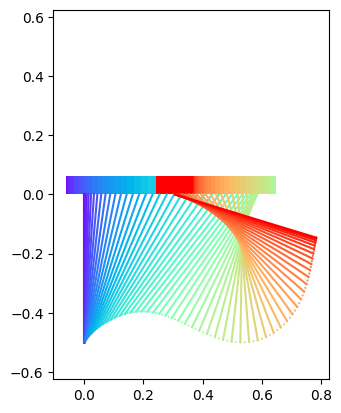

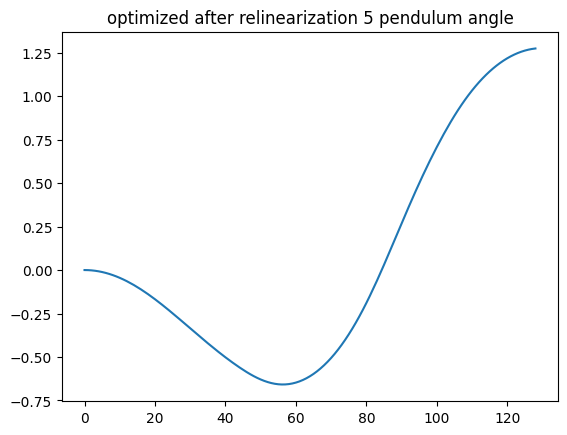

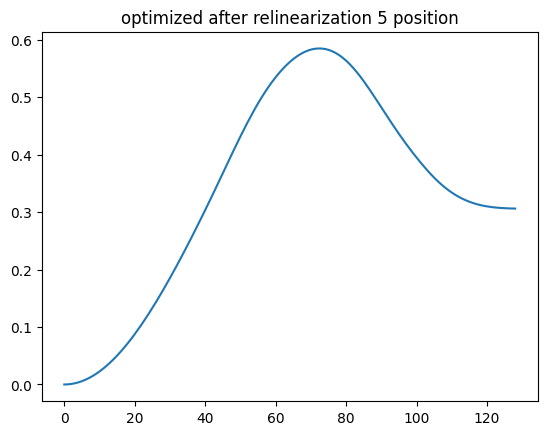

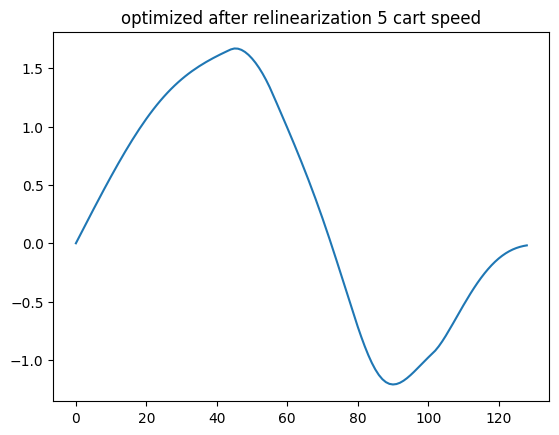

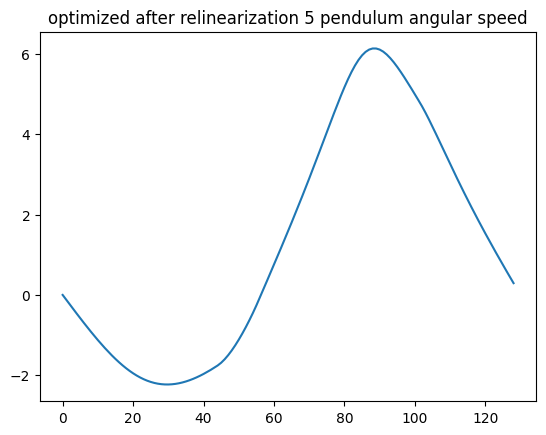

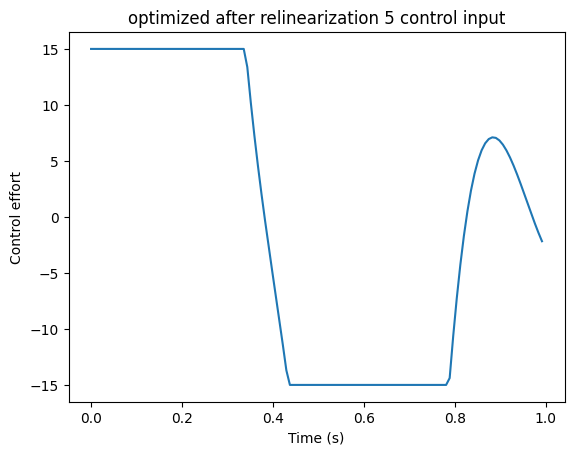

============ step 6 ============
applying control inputs to nonliner dynamics


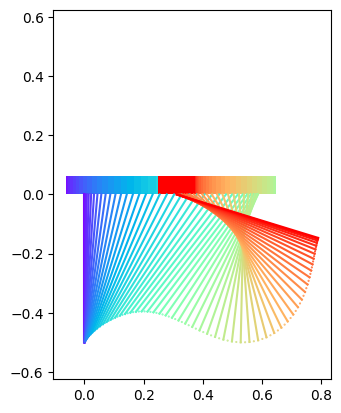

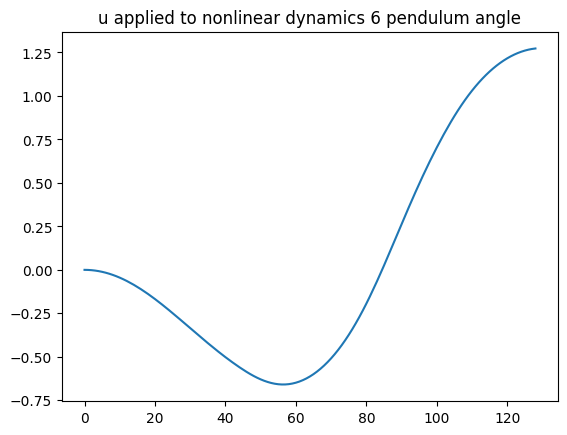

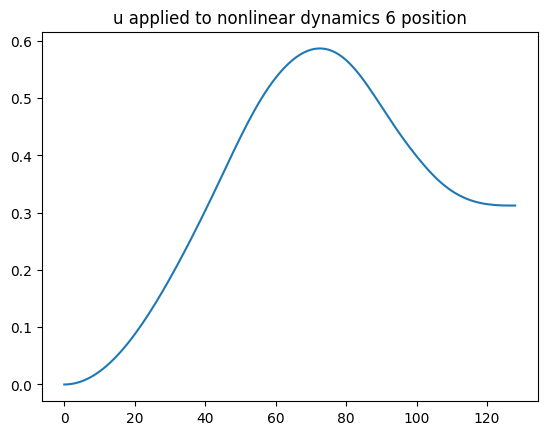

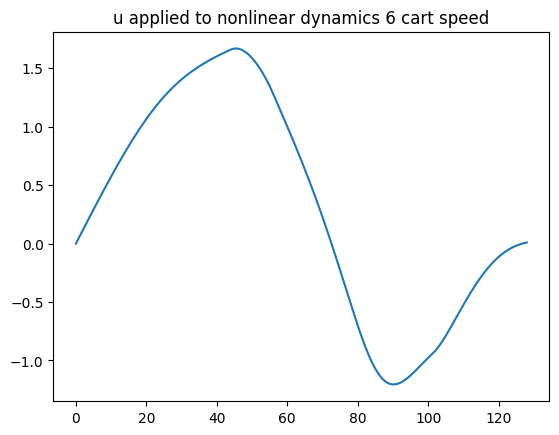

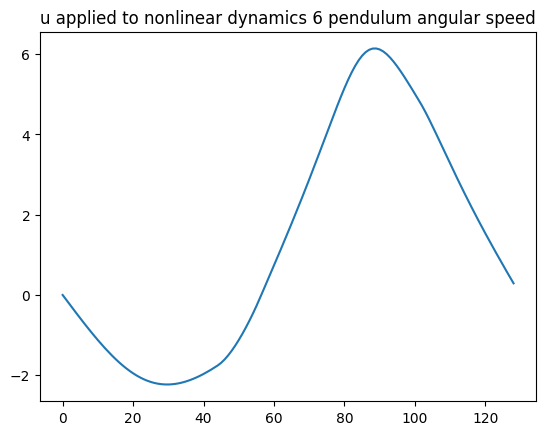

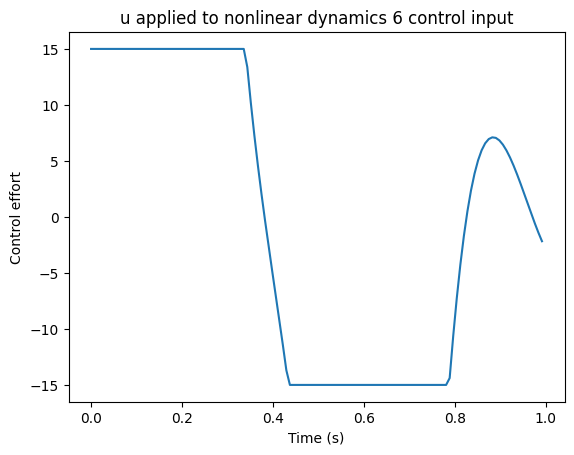

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.40254872624 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 258675.8735661419 line search param: 0.011972515182562033
ifsnm num iters: 2 residual norm: 256643.99408081998 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 255011.04908607723 line search param: 0.00636268544113595
ifsnm num iters: 4 residual norm: 253388.49401781854 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 251776.26279899897 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 250174.28973098882 line search param: 0.00636268544113595
ifsnm num iters: 7 residual norm: 248582.50944521234 line search param: 0.00636268544113595
ifsnm num iters: 8 residual norm: 247000.85714202732 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 245254.64743016823 line search param: 0.00706965

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.27223e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.13874e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 3.0654045000579493
nd prev: 3.0654045000579493 nd: 0.28867011605139775
fsnm num iters: 3 line search: 1.0 newton decrement: 0.28867011605139775
nd prev: 0.28867011605139775 nd: 0.24363665310916272


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.97761e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.24363665310916272
nd prev: 0.24363665310916272 nd: 0.1723977409097318
fsnm num iters: 5 line search: 1.0 newton decrement: 0.1723977409097318
nd prev: 0.1723977409097318 nd: 0.07798225046918156
fsnm num iters: 6 line search: 1.0 newton decrement: 0.07798225046918156
nd prev: 0.07798225046918156 nd: 0.013225067687852463
fsnm num iters: 7 line search: 0.31381059609000017 newton decrement: 0.013225067687852463
nd prev: 0.013225067687852463 nd: 0.000350468766912092
fsnm num iters: 8 line search: 0.00045677590745077476 newton decrement: 0.000350468766912092
nd prev: 0.000350468766912092 nd: 0.0002406337972142282
fsnm num iters: 9 line search: 1.0 newton decrement: 0.0002406337972142282
nd prev: 0.0002406337972142282 nd: 0.00024039424752369485
fsnm num iters: 10 line search: 1.0 newton decrement: 0.00024039424752369485
nd prev: 0.00024039424752369485 nd: 1.347789745743231e-07
fsnm num iters: 11 line search: 0.0007735540101454295 newton d

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31676e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.49719e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09614972727251209
nd prev: 0.09614972727251209 nd: 0.08700913409020448
fsnm num iters: 3 line search: 1.0 newton decrement: 0.08700913409020448
nd prev: 0.08700913409020448 nd: 0.07023758804470151


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32923e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06004e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.07023758804470151
nd prev: 0.07023758804470151 nd: 0.04266928522371308
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04266928522371308
nd prev: 0.04266928522371308 nd: 0.013055551233822075


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.91664e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64583e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.013055551233822075
nd prev: 0.013055551233822075 nd: 0.0009452008597702571
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0009452008597702571
nd prev: 0.0009452008597702571 nd: 4.4868824591226675e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70385e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70415e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.00045677590745077476 newton decrement: 4.4868824591226675e-06
nd prev: 4.4868824591226675e-06 nd: 1.2106178889097435e-09
entering fsnm loop
newton decrement: 0.6003295532708338
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6003295532708338
nd prev: 0.6003295532708338 nd: 39.14808310024619
fsnm num iters: 1 line search: 1.0 newton decrement: 39.14808310024619
nd prev: 39.14808310024619 nd: 0.030583880791449407


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32239e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51487e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.030583880791449407
nd prev: 0.030583880791449407 nd: 0.027837728439553646
fsnm num iters: 3 line search: 1.0 newton decrement: 0.027837728439553646
nd prev: 0.027837728439553646 nd: 0.022622174545235883


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33362e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06698e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.022622174545235883
nd prev: 0.022622174545235883 nd: 0.013926246773012785
fsnm num iters: 5 line search: 1.0 newton decrement: 0.013926246773012785
nd prev: 0.013926246773012785 nd: 0.0043625762507282515


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.92155e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64694e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70427e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0043625762507282515
nd prev: 0.0043625762507282515 nd: 0.00032745419403050317
fsnm num iters: 7 line search: 1.0 newton decrement: 0.00032745419403050317
nd prev: 0.00032745419403050317 nd: 1.6397380618138678e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70457e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.70465e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 1.6397380618138678e-06
nd prev: 1.6397380618138678e-06 nd: 1.592883541325474e-09
entering fsnm loop
newton decrement: 0.1898537667986001
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70465e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32298e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.1898537667986001
nd prev: 0.1898537667986001 nd: 12.454869213579197
fsnm num iters: 1 line search: 1.0 newton decrement: 12.454869213579197
nd prev: 12.454869213579197 nd: 0.009677503831551259


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51671e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33408e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009677503831551259
nd prev: 0.009677503831551259 nd: 0.008818773136786936
fsnm num iters: 3 line search: 1.0 newton decrement: 0.008818773136786936
nd prev: 0.008818773136786936 nd: 0.007180506737042077


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06771e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.92206e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.007180506737042077
nd prev: 0.007180506737042077 nd: 0.004436352632502435
fsnm num iters: 5 line search: 1.0 newton decrement: 0.004436352632502435
nd prev: 0.004436352632502435 nd: 0.0013971595617164028


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64705e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0002996906728784534 newton decrement: 0.0013971595617164028
nd prev: 0.0013971595617164028 nd: 0.00010617453171358985
fsnm num iters: 7 line search: 1.0 newton decrement: 0.00010617453171358985
nd prev: 0.00010617453171358985 nd: 0.00010561110028832536


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64707e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70432e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 0.00010561110028832536
nd prev: 0.00010561110028832536 nd: 5.346869017415986e-07
fsnm num iters: 9 line search: 1.0 newton decrement: 5.346869017415986e-07
nd prev: 5.346869017415986e-07 nd: 9.663518017376904e-10


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70461e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.70462e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.06003744268312225
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06003744268312225
nd prev: 0.06003744268312225 nd: 3.9419002711284805


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70462e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32305e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 3.9419002711284805
nd prev: 3.9419002711284805 nd: 0.0030604850424318466
fsnm num iters: 2 line search: 1.0 newton decrement: 0.0030604850424318466
nd prev: 0.0030604850424318466 nd: 0.0027892495259469532


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51695e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33414e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.0027892495259469532
nd prev: 0.0027892495259469532 nd: 0.002271606915716147
fsnm num iters: 4 line search: 1.0 newton decrement: 0.002271606915716147
nd prev: 0.002271606915716147 nd: 0.0014042463009772278


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06781e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.92214e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 0.0014042463009772278
nd prev: 0.0014042463009772278 nd: 0.00044277362571619694
fsnm num iters: 6 line search: 1.0 newton decrement: 0.00044277362571619694
nd prev: 0.00044277362571619694 nd: 3.3546959695995985e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64707e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70433e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 1.0 newton decrement: 3.3546959695995985e-05
nd prev: 3.3546959695995985e-05 nd: 1.704516467635051e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70462e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.00021847450052839252 newton decrement: 1.704516467635051e-07
nd prev: 1.704516467635051e-07 nd: 1.2249373572020108e-09
entering fsnm loop
newton decrement: 0.01898551921651697
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.70462e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70462e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.01898551921651697
nd prev: 0.01898551921651697 nd: 1.2466491053753863
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2466491053753863
nd prev: 1.2466491053753863 nd: 0.0009678159799428657


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32289e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.5166e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0009678159799428657
nd prev: 0.0009678159799428657 nd: 0.0008820543910168194
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008820543910168194
nd prev: 0.0008820543910168194 nd: 0.0007183749785156062


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33402e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06768e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 0.0006265787482177979 newton decrement: 0.0007183749785156062
nd prev: 0.0007183749785156062 nd: 0.0005624400603616135


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06873e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.21545e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.08862938119652508 newton decrement: 0.0005624400603616135
nd prev: 0.0005624400603616135 nd: 0.0005492995325063456
fsnm num iters: 6 line search: 1.0 newton decrement: 0.0005492995325063456
nd prev: 0.0005492995325063456 nd: 0.00042084333653211566


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.01794e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66062e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 1.0 newton decrement: 0.00042084333653211566
nd prev: 0.00042084333653211566 nd: 0.00012335797495207786
fsnm num iters: 8 line search: 1.0 newton decrement: 0.00012335797495207786
nd prev: 0.00012335797495207786 nd: 8.10665512146708e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70447e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.0004110983167056973 newton decrement: 8.10665512146708e-06
nd prev: 8.10665512146708e-06 nd: 3.085632195276724e-08
fsnm num iters: 10 line search: 0.0005075287860564164 newton decrement: 3.085632195276724e-08
nd prev: 3.085632195276724e-08 nd: 3.085619986594726e-08
fsnm num iters: 11 line search: 1.4115816386218418e-05 newton decrement: 3.085619986594726e-08
nd prev: 3.085619986594726e-08 nd: 3.0856461134829705e-08
fsnm num iters: 12 line search: 1.4115816386218418e-05 newton decrement: 3.0856461134829705e-08
nd prev: 3.0856461134829705e-08 nd: 3.085646093946059e-08
entering fsnm loop
newton decrement: 0.0060036518477398545
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.70447e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70447e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0060036518477398545
nd prev: 0.0060036518477398545 nd: 0.39380479719259126
fsnm num iters: 1 line search: 1.0 newton decrement: 0.39380479719259126
nd prev: 0.39380479719259126 nd: 0.00030602265362911587


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.3259e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.52725e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.00030602265362911587
nd prev: 0.00030602265362911587 nd: 0.00027886746416189373
fsnm num iters: 3 line search: 1.0 newton decrement: 0.00027886746416189373
nd prev: 0.00027886746416189373 nd: 0.00022705781009095378


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33655e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07098e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 4.048376602284338e-05 newton decrement: 0.00022705781009095378
nd prev: 0.00022705781009095378 nd: 0.00017762162040310076
fsnm num iters: 5 line search: 1.4115816386218418e-05 newton decrement: 0.00017762162040310076
nd prev: 0.00017762162040310076 nd: 0.00017762015059144724
fsnm num iters: 6 line search: 1.2704234747596576e-05 newton decrement: 0.00017762015059144724
nd prev: 0.00017762015059144724 nd: 0.00017761985663192269
fsnm num iters: 7 line search: 7.501723576108304e-06 newton decrement: 0.00017761985663192269
nd prev: 0.00017761985663192269 nd: 0.00017761967052269724
fsnm num iters: 8 line search: 9.261387130997904e-06 newton decrement: 0.00017761967052269724
nd prev: 0.00017761967052269724 nd: 0.00017761955402727472
entering fsnm loop
newton decrement: 0.001336870068524774
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=3.07098e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07098e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.1500946352969992 newton decrement: 0.001336870068524774
nd prev: 0.001336870068524774 nd: 0.027399325608463893


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.32166e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.00033298963653161486 newton decrement: 0.027399325608463893
nd prev: 0.027399325608463893 nd: 0.0001354167675755633
fsnm num iters: 2 line search: 3.5880511311095166e-06 newton decrement: 0.0001354167675755633
nd prev: 0.0001354167675755633 nd: 0.00013542199461660424
fsnm num iters: 3 line search: 3.5880511311095166e-06 newton decrement: 0.00013542199461660424
nd prev: 0.00013542199461660424 nd: 0.00013542199461660323
entering fsnm loop
newton decrement: 0.00017213352976435368
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=7.32166e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.32166e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 3.5880511311095166e-06 newton decrement: 0.00017213352976435368
nd prev: 0.00017213352976435368 nd: 0.00017213354532840945
entering fsnm loop
newton decrement: 0.0007341888081280643
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=7.32166e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.32166e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.02781283894436938 newton decrement: 0.0007341888081280643
nd prev: 0.0007341888081280643 nd: 0.023015332787966223


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.96232e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0014555783429306911 newton decrement: 0.023015332787966223
nd prev: 0.023015332787966223 nd: 3.2682317147232094e-06
fsnm num iters: 2 line search: 0.0006265787482177979 newton decrement: 3.2682317147232094e-06
nd prev: 3.2682317147232094e-06 nd: 3.2681452714230414e-06
fsnm num iters: 3 line search: 0.0005075287860564164 newton decrement: 3.2681452714230414e-06
nd prev: 3.2681452714230414e-06 nd: 3.268145262324354e-06


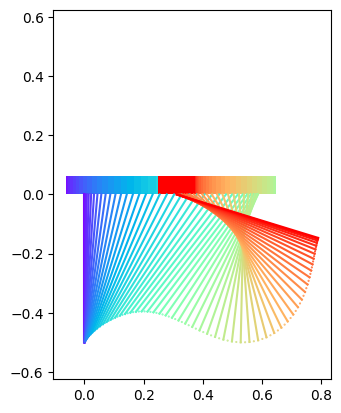

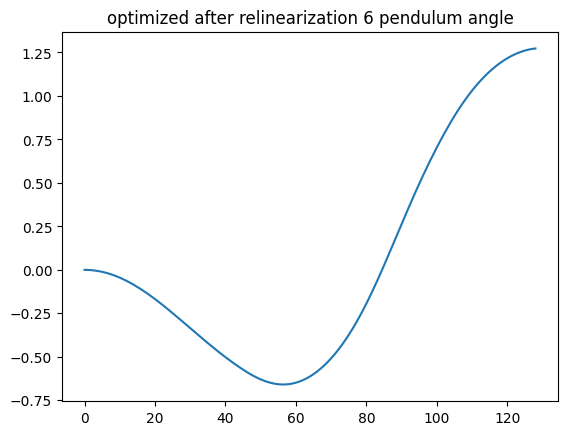

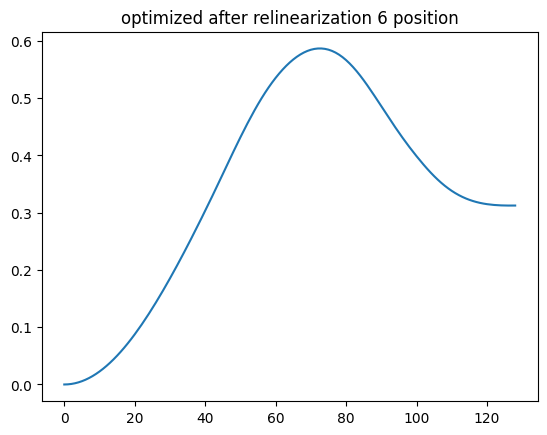

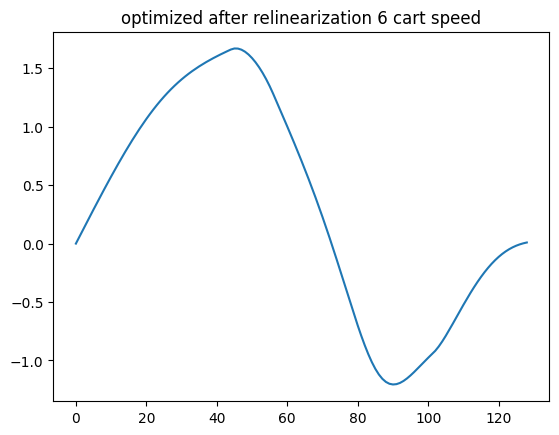

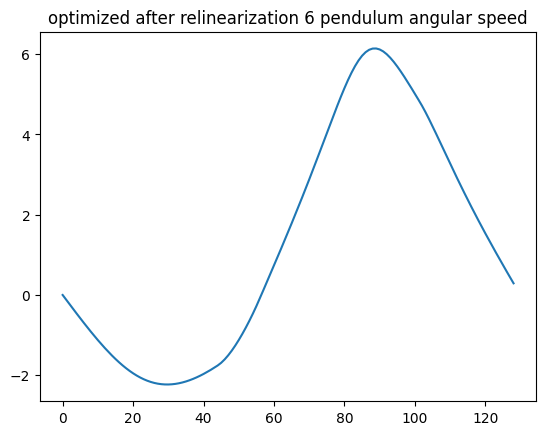

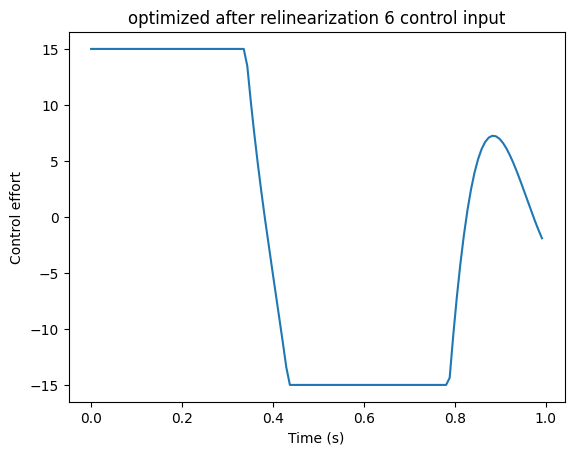

============ step 7 ============
applying control inputs to nonliner dynamics


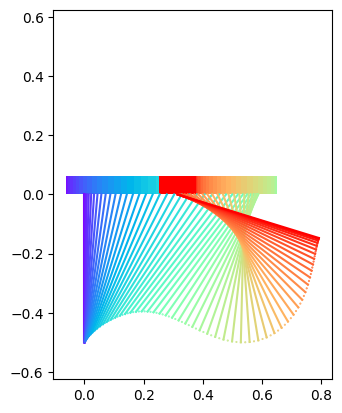

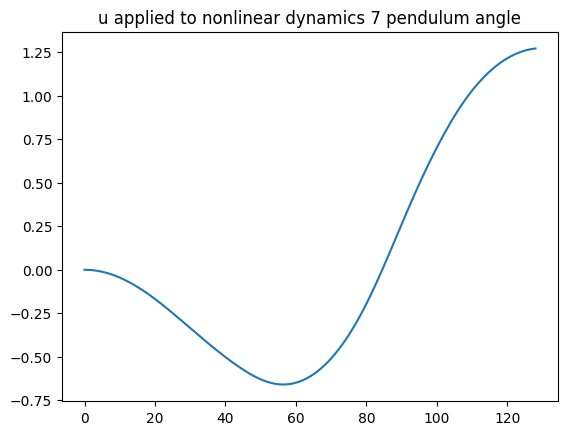

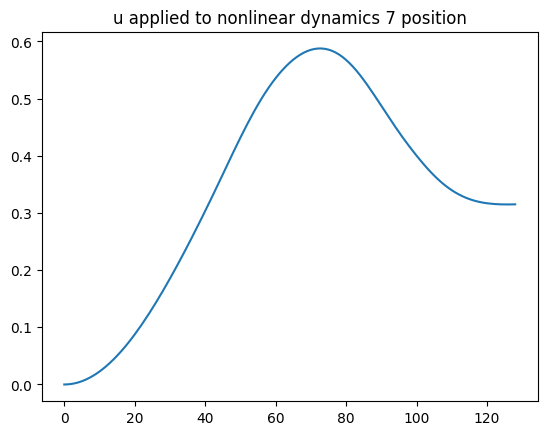

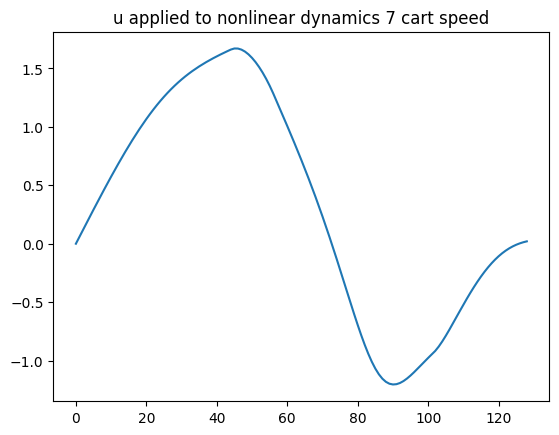

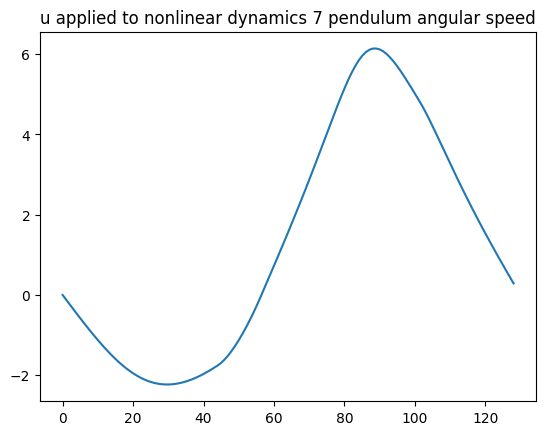

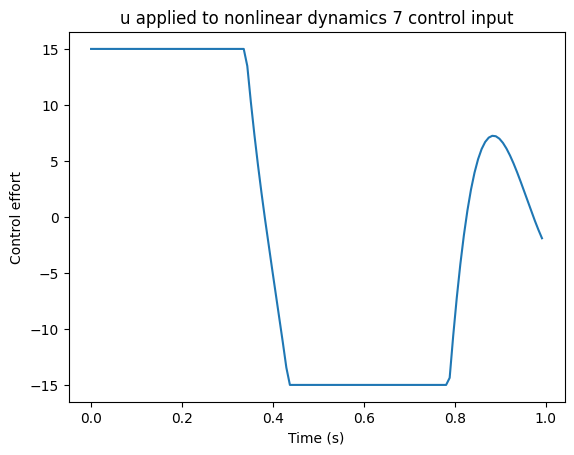

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.4025487347 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 258989.32643299276 line search param: 0.01077526366430583
ifsnm num iters: 2 residual norm: 256954.92198088087 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 255138.34058488996 line search param: 0.007069650490151055
ifsnm num iters: 4 residual norm: 253514.97560246964 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 251901.9396189207 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 250299.16688827117 line search param: 0.00636268544113595
ifsnm num iters: 7 residual norm: 248706.5920439251 line search param: 0.00636268544113595
ifsnm num iters: 8 residual norm: 247124.15024214 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 245377.06889113487 line search param: 0.0070696504901

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.27444e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.04562e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 2.820439779524144
nd prev: 2.820439779524144 nd: 0.2896763749997201
fsnm num iters: 3 line search: 1.0 newton decrement: 0.2896763749997201
nd prev: 0.2896763749997201 nd: 0.2451777733776875


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.70684e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.2451777733776875
nd prev: 0.2451777733776875 nd: 0.17505557702463706
fsnm num iters: 5 line search: 1.0 newton decrement: 0.17505557702463706
nd prev: 0.17505557702463706 nd: 0.08108890237947465
fsnm num iters: 6 line search: 1.0 newton decrement: 0.08108890237947465
nd prev: 0.08108890237947465 nd: 0.014482390949117522
fsnm num iters: 7 line search: 1.0 newton decrement: 0.014482390949117522
nd prev: 0.014482390949117522 nd: 0.0004214087039985417
fsnm num iters: 8 line search: 1.0 newton decrement: 0.0004214087039985417
nd prev: 0.0004214087039985417 nd: 4.117788639937505e-07
fsnm num iters: 9 line search: 0.0007735540101454295 newton decrement: 4.117788639937505e-07
nd prev: 4.117788639937505e-07 nd: 1.5567298931373645e-09
entering fsnm loop
newton decrement: 1.8969699848178314
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 1.8969699848178314
nd prev: 1.896969

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31921e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.50565e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09612259071218522
nd prev: 0.09612259071218522 nd: 0.08700742248985896
fsnm num iters: 3 line search: 1.0 newton decrement: 0.08700742248985896
nd prev: 0.08700742248985896 nd: 0.07023170839673887


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33179e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06613e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.07023170839673887
nd prev: 0.07023170839673887 nd: 0.04265693084172179
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04265693084172179
nd prev: 0.04265693084172179 nd: 0.013050277235756918


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.92683e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.65781e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.013050277235756918
nd prev: 0.013050277235756918 nd: 0.000944947305969656
fsnm num iters: 7 line search: 1.0 newton decrement: 0.000944947305969656
nd prev: 0.000944947305969656 nd: 4.488138476126987e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71601e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71631e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 4.488138476126987e-06
nd prev: 4.488138476126987e-06 nd: 3.2265880701649314e-10
entering fsnm loop
newton decrement: 0.6003211691428937
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6003211691428937
nd prev: 0.6003211691428937 nd: 39.12995432034961
fsnm num iters: 1 line search: 1.0 newton decrement: 39.12995432034961
nd prev: 39.12995432034961 nd: 0.030578157563020385


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32517e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.52435e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.030578157563020385
nd prev: 0.030578157563020385 nd: 0.02782797965841932
fsnm num iters: 3 line search: 1.0 newton decrement: 0.02782797965841932
nd prev: 0.02782797965841932 nd: 0.02260905522683685


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33643e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07346e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.02260905522683685
nd prev: 0.02260905522683685 nd: 0.013918183285112908
fsnm num iters: 5 line search: 1.0 newton decrement: 0.013918183285112908
nd prev: 0.013918183285112908 nd: 0.004361618081617709


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.932e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.65896e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.004361618081617709
nd prev: 0.004361618081617709 nd: 0.0003274116411308348
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0003274116411308348
nd prev: 0.0003274116411308348 nd: 1.6393209662995633e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71643e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71672e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 1.6393209662995633e-06
nd prev: 1.6393209662995633e-06 nd: 2.5345416487584674e-10
entering fsnm loop
newton decrement: 0.18985349624949818
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.7168e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.7168e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.18985349624949818
nd prev: 0.18985349624949818 nd: 12.4529145872353
fsnm num iters: 1 line search: 1.0 newton decrement: 12.4529145872353
nd prev: 12.4529145872353 nd: 0.009677324898365048


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32579e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.52632e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009677324898365048
nd prev: 0.009677324898365048 nd: 0.008818436554794007
fsnm num iters: 3 line search: 1.0 newton decrement: 0.008818436554794007
nd prev: 0.008818436554794007 nd: 0.007179901458943758


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33691e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07424e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.007179901458943758
nd prev: 0.007179901458943758 nd: 0.0044355226857139005
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0044355226857139005
nd prev: 0.0044355226857139005 nd: 0.0013966487511121982


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93254e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.65908e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0013966487511121982
nd prev: 0.0013966487511121982 nd: 0.0001055853959487714
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0001055853959487714
nd prev: 0.0001055853959487714 nd: 5.347075898918759e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71647e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71676e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 5.347075898918759e-07
nd prev: 5.347075898918759e-07 nd: 1.7001847312740653e-09


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.71677e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71677e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.06003743417556087
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06003743417556087
nd prev: 0.06003743417556087 nd: 3.9418289019603754


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32586e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.52651e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 3.9418289019603754
nd prev: 3.9418289019603754 nd: 0.0030604794150209556
fsnm num iters: 2 line search: 1.0 newton decrement: 0.0030604794150209556
nd prev: 0.0030604794150209556 nd: 0.0027892386517440314


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33696e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07431e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.0027892386517440314
nd prev: 0.0027892386517440314 nd: 0.0022715872909998534
fsnm num iters: 4 line search: 0.9 newton decrement: 0.0022715872909998534
nd prev: 0.0022715872909998534 nd: 0.0014344119738639613


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.7271e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.88727e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.1853020188851842 newton decrement: 0.0014344119738639613
nd prev: 0.0014344119738639613 nd: 0.0005946782079492412
fsnm num iters: 6 line search: 0.81 newton decrement: 0.0005946782079492412
nd prev: 0.0005946782079492412 nd: 0.0004738486354315851


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.50239e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.004638397686588107 newton decrement: 0.0004738486354315851
nd prev: 0.0004738486354315851 nd: 0.00012621094901778973


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.50337e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.0005075287860564164 newton decrement: 0.00012621094901778973
nd prev: 0.00012621094901778973 nd: 0.000125646513659684
fsnm num iters: 9 line search: 1.0 newton decrement: 0.000125646513659684
nd prev: 0.000125646513659684 nd: 0.00012326470325588117


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.50348e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71271e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0003699884850351276 newton decrement: 0.00012326470325588117
nd prev: 0.00012326470325588117 nd: 2.3645375779358027e-06
fsnm num iters: 11 line search: 0.00015926791088519815 newton decrement: 2.3645375779358027e-06
nd prev: 2.3645375779358027e-06 nd: 2.3639641677871705e-06
fsnm num iters: 12 line search: 0.00015926791088519815 newton decrement: 2.3639641677871705e-06
nd prev: 2.3639641677871705e-06 nd: 2.363837502113908e-06
fsnm num iters: 13 line search: 0.00021847450052839252 newton decrement: 2.363837502113908e-06
nd prev: 2.363837502113908e-06 nd: 2.3637109033384796e-06
fsnm num iters: 14 line search: 0.0003699884850351276 newton decrement: 2.3637109033384796e-06
nd prev: 2.3637109033384796e-06 nd: 2.3634997533634065e-06
fsnm num iters: 15 line search: 0.00015926791088519815 newton decrement: 2.3634997533634065e-06
nd prev: 2.3634997533634065e-06 nd: 2.3629273465192995e-06
fsnm num iters: 16 line search: 7.501723576108304e-06 newton decrement: 2.3

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.71271e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71271e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.018978047337688167
nd prev: 0.018978047337688167 nd: 1.2152314559667172
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2152314559667172
nd prev: 1.2152314559667172 nd: 0.0009654506850228947


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.39348e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.73747e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0009654506850228947
nd prev: 0.0009654506850228947 nd: 0.0008774209535956642
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008774209535956642
nd prev: 0.0008774209535956642 nd: 0.0007098401338465685


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.38872e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.15447e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0007098401338465685
nd prev: 0.0007098401338465685 nd: 0.00043156834983157545
fsnm num iters: 5 line search: 1.0 newton decrement: 0.00043156834983157545
nd prev: 0.00043156834983157545 nd: 0.0001308912615762028


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.98564e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66687e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0001308912615762028
nd prev: 0.0001308912615762028 nd: 9.192059086497877e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71659e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 8.464149782874061e-05 newton decrement: 9.192059086497877e-06
nd prev: 9.192059086497877e-06 nd: 4.041485420949719e-08
fsnm num iters: 8 line search: 1.742693381014619e-05 newton decrement: 4.041485420949719e-08
nd prev: 4.041485420949719e-08 nd: 4.0414545499140275e-08
fsnm num iters: 9 line search: 1.742693381014619e-05 newton decrement: 4.0414545499140275e-08
nd prev: 4.0414545499140275e-08 nd: 4.041454536957232e-08
entering fsnm loop
newton decrement: 0.006003621638756246
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.71659e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71659e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.006003621638756246
nd prev: 0.006003621638756246 nd: 0.3936856974009488
fsnm num iters: 1 line search: 1.0 newton decrement: 0.3936856974009488
nd prev: 0.3936856974009488 nd: 0.0003060097352588724


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32748e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.53185e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0003060097352588724
nd prev: 0.0003060097352588724 nd: 0.0002788534710626172
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0002788534710626172
nd prev: 0.0002788534710626172 nd: 0.0002270265853546441


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33829e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07703e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0002270265853546441
nd prev: 0.0002270265853546441 nd: 0.00014022647242441065
fsnm num iters: 5 line search: 1.0 newton decrement: 0.00014022647242441065
nd prev: 0.00014022647242441065 nd: 4.413033866785386e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93368e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.65968e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 4.413033866785386e-05
nd prev: 4.413033866785386e-05 nd: 3.3310629150879318e-06
fsnm num iters: 7 line search: 1.0 newton decrement: 3.3310629150879318e-06
nd prev: 3.3310629150879318e-06 nd: 1.9827488191795688e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71731e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.71731e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.001898549190761241
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.001898549190761241
nd prev: 0.001898549190761241 nd: 0.12466638399004125


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71731e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31376e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.01077526366430583 newton decrement: 0.12466638399004125
nd prev: 0.12466638399004125 nd: 0.0001772198901036965
fsnm num iters: 2 line search: 0.5904900000000002 newton decrement: 0.0001772198901036965
nd prev: 0.0001772198901036965 nd: 0.0001190576658695449


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.34127e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.03864e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.0001190576658695449
nd prev: 0.0001190576658695449 nd: 9.173977719466428e-05
fsnm num iters: 4 line search: 1.0 newton decrement: 9.173977719466428e-05
nd prev: 9.173977719466428e-05 nd: 7.845974146607065e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=9.48882e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.408e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.00636268544113595 newton decrement: 7.845974146607065e-05
nd prev: 7.845974146607065e-05 nd: 7.38189089243817e-05
fsnm num iters: 6 line search: 1.0 newton decrement: 7.38189089243817e-05
nd prev: 7.38189089243817e-05 nd: 5.460737696087704e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.41973e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.40679e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0009550049507968265 newton decrement: 5.460737696087704e-05
nd prev: 5.460737696087704e-05 nd: 2.573592880696352e-05
fsnm num iters: 8 line search: 6.170365191715192e-05 newton decrement: 2.573592880696352e-05
nd prev: 2.573592880696352e-05 nd: 2.5726385850547823e-05
fsnm num iters: 9 line search: 1.0 newton decrement: 2.5726385850547823e-05
nd prev: 2.5726385850547823e-05 nd: 2.2930272656705074e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.55063e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.7119e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 1.0 newton decrement: 2.2930272656705074e-05
nd prev: 2.2930272656705074e-05 nd: 3.0955631783473853e-06
fsnm num iters: 11 line search: 1.0 newton decrement: 3.0955631783473853e-06
nd prev: 3.0955631783473853e-06 nd: 5.611812521509632e-08
fsnm num iters: 12 line search: 1.0 newton decrement: 5.611812521509632e-08
nd prev: 5.611812521509632e-08 nd: 3.643703015049412e-08
fsnm num iters: 13 line search: 1.0 newton decrement: 3.643703015049412e-08
nd prev: 3.643703015049412e-08 nd: 3.6436932061956545e-08
fsnm num iters: 14 line search: 1.0 newton decrement: 3.6436932061956545e-08
nd prev: 3.6436932061956545e-08 nd: 3.6436922660494414e-08
entering fsnm loop
newton decrement: 0.0006003692990692986
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.7119e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.7119e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.0984770902183612 newton decrement: 0.0006003692990692986
nd prev: 0.0006003692990692986 nd: 0.0052794487255458915
fsnm num iters: 1 line search: 0.004638397686588107 newton decrement: 0.0052794487255458915
nd prev: 0.0052794487255458915 nd: 9.154826060821965e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.38989e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 5.5533286725436733e-05 newton decrement: 9.154826060821965e-06
nd prev: 9.154826060821965e-06 nd: 9.133511654217149e-06
fsnm num iters: 3 line search: 3.5880511311095166e-06 newton decrement: 9.133511654217149e-06
nd prev: 9.133511654217149e-06 nd: 9.133511654213739e-06
entering fsnm loop
newton decrement: 0.0002187338747390822
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=7.38989e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.38989e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.08862938119652508 newton decrement: 0.0002187338747390822
nd prev: 0.0002187338747390822 nd: 0.002706459515695108
fsnm num iters: 1 line search: 1.0 newton decrement: 0.002706459515695108
nd prev: 0.002706459515695108 nd: 1.6074764642393646e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.13187e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 0.003757102126136367 newton decrement: 1.6074764642393646e-06
nd prev: 1.6074764642393646e-06 nd: 4.0537236753280934e-07
fsnm num iters: 3 line search: 1.0 newton decrement: 4.0537236753280934e-07
nd prev: 4.0537236753280934e-07 nd: 4.0407751462173164e-07
fsnm num iters: 4 line search: 1.0 newton decrement: 4.0407751462173164e-07
nd prev: 4.0407751462173164e-07 nd: 3.9021270146895143e-07
fsnm num iters: 5 line search: 1.0 newton decrement: 3.9021270146895143e-07
nd prev: 3.9021270146895143e-07 nd: 3.902113681376672e-07
fsnm num iters: 6 line search: 1.0 newton decrement: 3.902113681376672e-07
nd prev: 3.902113681376672e-07 nd: 3.902114002955132e-07


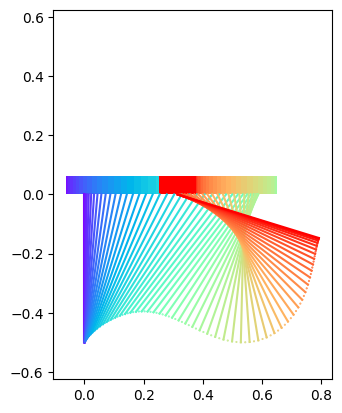

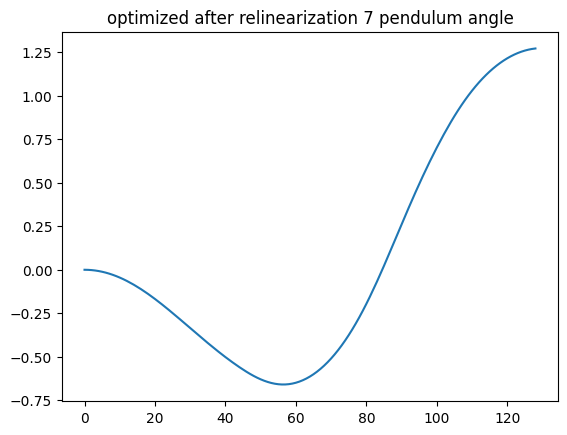

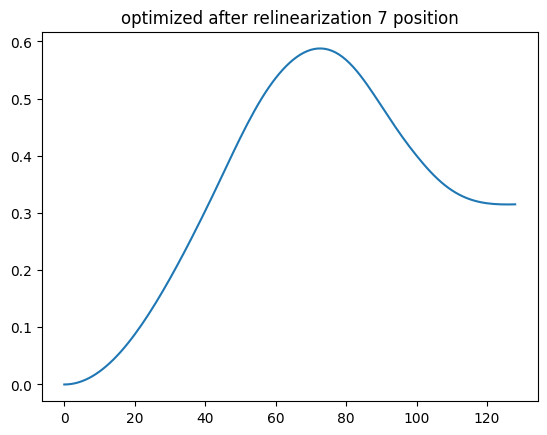

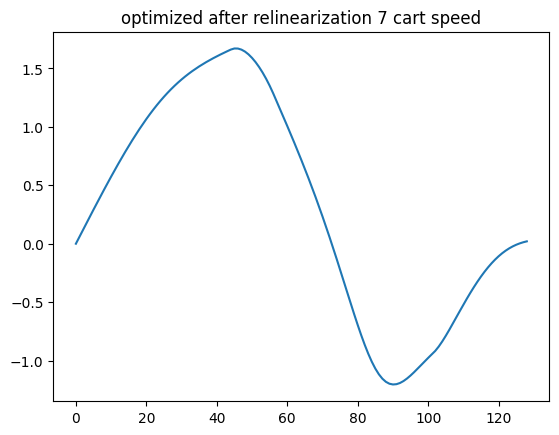

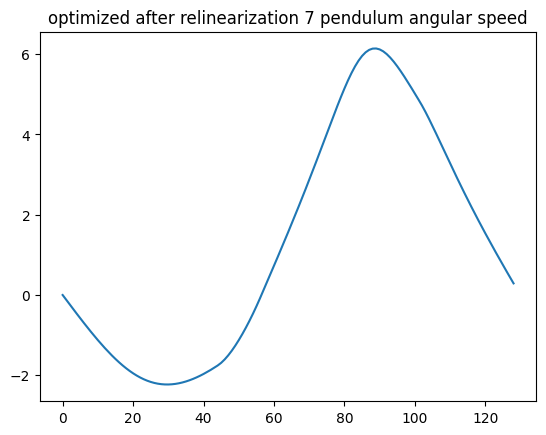

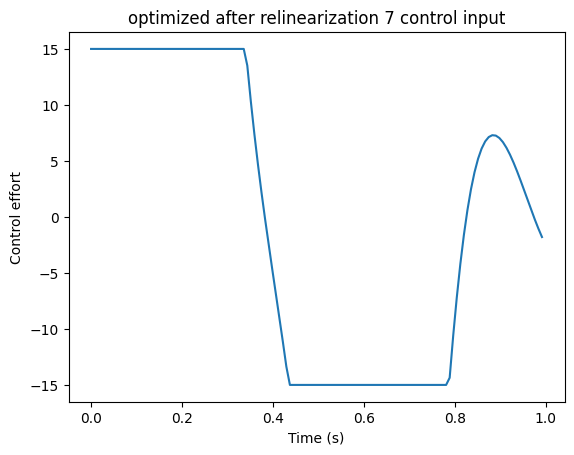

============ step 8 ============
applying control inputs to nonliner dynamics


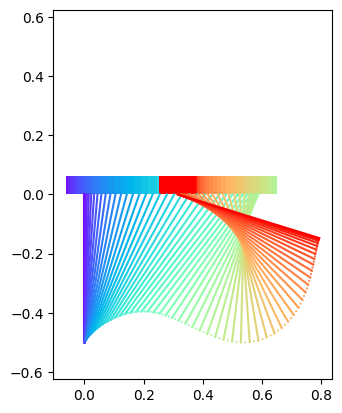

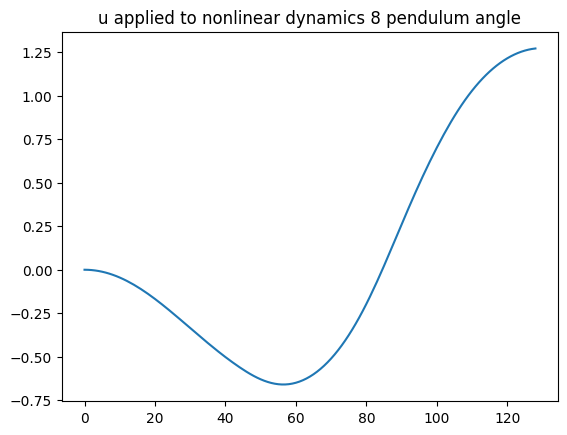

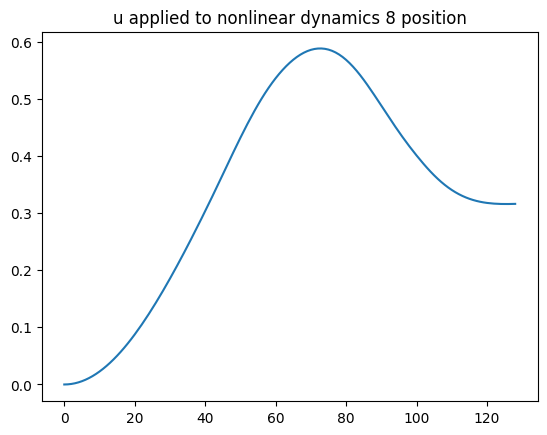

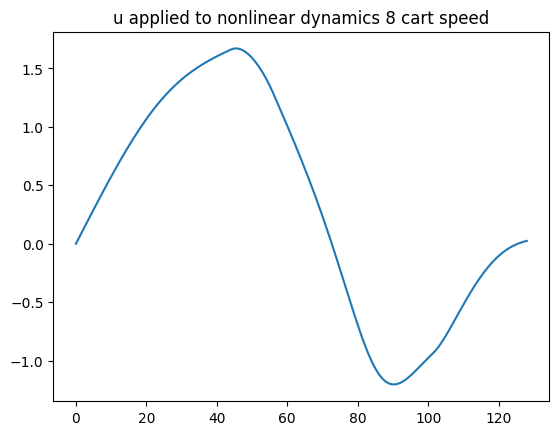

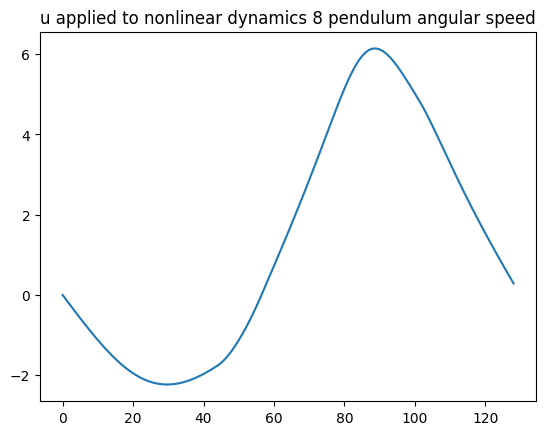

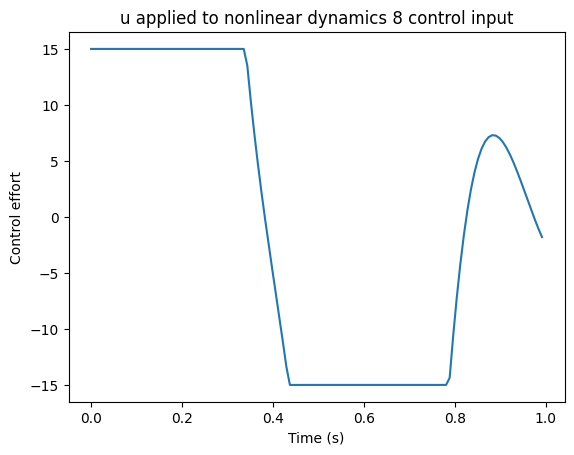

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.4025487382 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 258989.32643401285 line search param: 0.01077526366430583
ifsnm num iters: 2 residual norm: 256954.92199595348 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 255138.34124198215 line search param: 0.007069650490151055
ifsnm num iters: 4 residual norm: 253514.97627657602 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 251901.94052985375 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 250299.1685753207 line search param: 0.00636268544113595
ifsnm num iters: 7 residual norm: 248706.593746904 line search param: 0.00636268544113595
ifsnm num iters: 8 residual norm: 247124.15193499284 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 245377.0705738031 line search param: 0.007069650490

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.27538e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.04715e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 4.18611385524415
nd prev: 4.18611385524415 nd: 0.289786073483963
fsnm num iters: 3 line search: 1.0 newton decrement: 0.289786073483963
nd prev: 0.289786073483963 nd: 0.2455463805046265


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.71195e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.2455463805046265
nd prev: 0.2455463805046265 nd: 0.17555017832542488
fsnm num iters: 5 line search: 1.0 newton decrement: 0.17555017832542488
nd prev: 0.17555017832542488 nd: 0.08136315207358358
fsnm num iters: 6 line search: 1.0 newton decrement: 0.08136315207358358
nd prev: 0.08136315207358358 nd: 0.01451209659094198
fsnm num iters: 7 line search: 1.0 newton decrement: 0.01451209659094198
nd prev: 0.01451209659094198 nd: 0.0004218349336426758
fsnm num iters: 8 line search: 0.0022185312344622636 newton decrement: 0.0004218349336426758
nd prev: 0.0004218349336426758 nd: 4.1238691262823483e-07
fsnm num iters: 9 line search: 0.0011790184577738598 newton decrement: 4.1238691262823483e-07
nd prev: 4.1238691262823483e-07 nd: 4.114699865269161e-07
fsnm num iters: 10 line search: 0.0014555783429306911 newton decrement: 4.114699865269161e-07
nd prev: 4.114699865269161e-07 nd: 4.109854683795921e-07
fsnm num iters: 11 line search: 0.00012900

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32018e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.509e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.09621407661117173
nd prev: 0.09621407661117173 nd: 0.08700856442804432
fsnm num iters: 3 line search: 1.0 newton decrement: 0.08700856442804432
nd prev: 0.08700856442804432 nd: 0.0702286067359532


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.3328e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06855e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0702286067359532
nd prev: 0.0702286067359532 nd: 0.04265156027983251
fsnm num iters: 5 line search: 1.0 newton decrement: 0.04265156027983251
nd prev: 0.04265156027983251 nd: 0.013048116153885042


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93091e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66263e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.81 newton decrement: 0.013048116153885042
nd prev: 0.013048116153885042 nd: 0.0009457011107087037
fsnm num iters: 7 line search: 1.0 newton decrement: 0.0009457011107087037
nd prev: 0.0009457011107087037 nd: 0.00018382060093983127


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.7098e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72118e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 0.00018382060093983127
nd prev: 0.00018382060093983127 nd: 1.6873233767524565e-07
fsnm num iters: 9 line search: 1.0 newton decrement: 1.6873233767524565e-07
nd prev: 1.6873233767524565e-07 nd: 1.9849854961270548e-09


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72119e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.6003166550671554
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.6003166550671554
nd prev: 0.6003166550671554 nd: 39.12209484306207


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32628e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.52814e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 39.12209484306207
nd prev: 39.12209484306207 nd: 0.03057507982125975
fsnm num iters: 2 line search: 1.0 newton decrement: 0.03057507982125975
nd prev: 0.03057507982125975 nd: 0.02782283688147288


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33755e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07606e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.02782283688147288
nd prev: 0.02782283688147288 nd: 0.02260266980577178
fsnm num iters: 4 line search: 1.0 newton decrement: 0.02260266980577178
nd prev: 0.02260266980577178 nd: 0.01391500184426012


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.9362e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6638e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 0.01391500184426012
nd prev: 0.01391500184426012 nd: 0.004361327822488861
fsnm num iters: 6 line search: 1.0 newton decrement: 0.004361327822488861
nd prev: 0.004361327822488861 nd: 0.0003273920470307209


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72131e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0009550049507968265 newton decrement: 0.0003273920470307209
nd prev: 0.0003273920470307209 nd: 1.6391567431061258e-06
fsnm num iters: 8 line search: 8.464149782874061e-05 newton decrement: 1.6391567431061258e-06
nd prev: 1.6391567431061258e-06 nd: 1.6375666440860326e-06
fsnm num iters: 9 line search: 0.0004110983167056973 newton decrement: 1.6375666440860326e-06
nd prev: 1.6375666440860326e-06 nd: 1.637465415579186e-06
fsnm num iters: 10 line search: 9.404610869860067e-05 newton decrement: 1.637465415579186e-06
nd prev: 1.637465415579186e-06 nd: 1.6367653719739316e-06
fsnm num iters: 11 line search: 4.4981962247603756e-05 newton decrement: 1.6367653719739316e-06
nd prev: 1.6367653719739316e-06 nd: 1.6366545922846494e-06
fsnm num iters: 12 line search: 0.0005639208733960181 newton decrement: 1.6366545922846494e-06
nd prev: 1.6366545922846494e-06 nd: 1.6366158845121938e-06
fsnm num iters: 13 line search: 1.742693381014619e-05 newton decrement: 1.636615884

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72161e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 16 line search: 0.0016173092699229901 newton decrement: 1.635654565052579e-06
nd prev: 1.635654565052579e-06 nd: 7.256529067720019e-10
entering fsnm loop
newton decrement: 0.18985334995421188
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72169e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72169e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.18985334995421188
nd prev: 0.18985334995421188 nd: 12.451893137243916


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32692e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.53017e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 12.451893137243916
nd prev: 12.451893137243916 nd: 0.009677228945293556
fsnm num iters: 2 line search: 1.0 newton decrement: 0.009677228945293556
nd prev: 0.009677228945293556 nd: 0.008818254656790533


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33805e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07686e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.008818254656790533
nd prev: 0.008818254656790533 nd: 0.007179576188047525
fsnm num iters: 4 line search: 1.0 newton decrement: 0.007179576188047525
nd prev: 0.007179576188047525 nd: 0.004435083849797318


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93676e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66392e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 0.004435083849797318
nd prev: 0.004435083849797318 nd: 0.00139638927175295
fsnm num iters: 6 line search: 0.0005639208733960181 newton decrement: 0.00139638927175295
nd prev: 0.00139638927175295 nd: 0.00010608997156469894


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66395e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 3.5880511311095166e-06 newton decrement: 0.00010608997156469894
nd prev: 0.00010608997156469894 nd: 0.00010603080245139209
fsnm num iters: 8 line search: 0.00024274944503154723 newton decrement: 0.00010603080245139209
nd prev: 0.00010603080245139209 nd: 0.00010603038223681312


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66396e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.00033298963653161486 newton decrement: 0.00010603038223681312
nd prev: 0.00010603038223681312 nd: 0.00010600473949613858


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66398e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.00010449567633177853 newton decrement: 0.00010600473949613858
nd prev: 0.00010600473949613858 nd: 0.00010596972656450425


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66399e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 11 line search: 4.4981962247603756e-05 newton decrement: 0.00010596972656450425
nd prev: 0.00010596972656450425 nd: 0.00010595875021970232
fsnm num iters: 12 line search: 1.0 newton decrement: 0.00010595875021970232
nd prev: 0.00010595875021970232 nd: 0.00010542357773279213


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72136e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72165e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 13 line search: 1.0 newton decrement: 0.00010542357773279213
nd prev: 0.00010542357773279213 nd: 5.33272222416127e-07
fsnm num iters: 14 line search: 0.0007735540101454295 newton decrement: 5.33272222416127e-07
nd prev: 5.33272222416127e-07 nd: 1.4335222262724421e-09
entering fsnm loop
newton decrement: 0.060037429358572744
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72166e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72166e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.060037429358572744
nd prev: 0.060037429358572744 nd: 3.9417882758595515
fsnm num iters: 1 line search: 1.0 newton decrement: 3.9417882758595515
nd prev: 3.9417882758595515 nd: 0.0030604762195828293


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32698e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.53033e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0030604762195828293
nd prev: 0.0030604762195828293 nd: 0.002789232434439316
fsnm num iters: 3 line search: 1.0 newton decrement: 0.002789232434439316
nd prev: 0.002789232434439316 nd: 0.0022715760897739773


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33809e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07691e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0022715760897739773
nd prev: 0.0022715760897739773 nd: 0.0014042009612366569
fsnm num iters: 5 line search: 1.0 newton decrement: 0.0014042009612366569
nd prev: 0.0014042009612366569 nd: 0.0004427402440809568


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93679e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66393e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0004427402440809568
nd prev: 0.0004427402440809568 nd: 3.3541413474380185e-05
fsnm num iters: 7 line search: 1.0 newton decrement: 3.3541413474380185e-05
nd prev: 3.3541413474380185e-05 nd: 1.7043348922812612e-07


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72136e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72165e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 1.0 newton decrement: 1.7043348922812612e-07
nd prev: 1.7043348922812612e-07 nd: 1.2449266237719802e-09
entering fsnm loop
newton decrement: 0.01898551912775111
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72165e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.01898551912775111
nd prev: 0.01898551912775111 nd: 1.2466472440545506
fsnm num iters: 1 line search: 1.0 newton decrement: 1.2466472440545506
nd prev: 1.2466472440545506 nd: 0.0009678163166023313


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32698e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.53053e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0009678163166023313
nd prev: 0.0009678163166023313 nd: 0.0008820539524701399
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008820539524701399
nd prev: 0.0008820539524701399 nd: 0.0007183749829841224


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33817e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07699e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0007183749829841224
nd prev: 0.0007183749829841224 nd: 0.000444105633686211
fsnm num iters: 5 line search: 1.0 newton decrement: 0.000444105633686211
nd prev: 0.000444105633686211 nd: 0.0001400499550708398


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93681e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66387e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0001400499550708398
nd prev: 0.0001400499550708398 nd: 1.061383041369208e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72138e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72156e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 1.0 newton decrement: 1.061383041369208e-05
nd prev: 1.061383041369208e-05 nd: 5.386076829359862e-08
fsnm num iters: 8 line search: 1.0 newton decrement: 5.386076829359862e-08
nd prev: 5.386076829359862e-08 nd: 4.132348421308125e-09


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72156e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72156e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


entering fsnm loop
newton decrement: 0.006003748654350116
stupid feasible newton termination criteria: inf
fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.006003748654350116
nd prev: 0.006003748654350116 nd: 0.3942248002754202


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32918e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.53766e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 0.3942248002754202
nd prev: 0.3942248002754202 nd: 0.0003060492658188828
fsnm num iters: 2 line search: 9.261387130997904e-06 newton decrement: 0.0003060492658188828
nd prev: 0.0003060492658188828 nd: 0.0004793702664306845
fsnm num iters: 3 line search: 0.0022185312344622636 newton decrement: 0.0004793702664306845
nd prev: 0.0004793702664306845 nd: 0.0004786059602891505
fsnm num iters: 4 line search: 0.22876792454961012 newton decrement: 0.0004786059602891505
nd prev: 0.0004786059602891505 nd: 0.0004114687643476191


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.55294e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.16933e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 0.0004114687643476191
nd prev: 0.0004114687643476191 nd: 0.0002680757119089093
fsnm num iters: 6 line search: 0.6561000000000001 newton decrement: 0.0002680757119089093
nd prev: 0.0002680757119089093 nd: 0.00023231199136908472


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.72361e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.89551e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 1.0 newton decrement: 0.00023231199136908472
nd prev: 0.00023231199136908472 nd: 0.00014952764340400585


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.80821e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.01824800363140075 newton decrement: 0.00014952764340400585
nd prev: 0.00014952764340400585 nd: 5.559617533662701e-05
fsnm num iters: 9 line search: 1.0 newton decrement: 5.559617533662701e-05
nd prev: 5.559617533662701e-05 nd: 5.059692288261936e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.82314e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64537e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0005075287860564164 newton decrement: 5.059692288261936e-05
nd prev: 5.059692288261936e-05 nd: 4.49252612140245e-06
fsnm num iters: 11 line search: 0.00045677590745077476 newton decrement: 4.49252612140245e-06
nd prev: 4.49252612140245e-06 nd: 4.492052362569446e-06
fsnm num iters: 12 line search: 1.1433811272836918e-05 newton decrement: 4.492052362569446e-06
nd prev: 4.492052362569446e-06 nd: 4.491706953903432e-06
fsnm num iters: 13 line search: 1.1433811272836918e-05 newton decrement: 4.491706953903432e-06
nd prev: 4.491706953903432e-06 nd: 4.491706952312115e-06
entering fsnm loop
newton decrement: 0.0018843481108930598
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.64537e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.64537e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0018843481108930598
nd prev: 0.0018843481108930598 nd: 0.08339838415510925
fsnm num iters: 1 line search: 0.5904900000000002 newton decrement: 0.08339838415510925
nd prev: 0.08339838415510925 nd: 0.00011221374286285073


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.8781e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.11603e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.00011221374286285073
nd prev: 0.00011221374286285073 nd: 8.484414803932379e-05
fsnm num iters: 3 line search: 1.0 newton decrement: 8.484414803932379e-05
nd prev: 8.484414803932379e-05 nd: 6.573036567028855e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.70876e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.61131e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 6.573036567028855e-05
nd prev: 6.573036567028855e-05 nd: 3.58678857134328e-05
fsnm num iters: 5 line search: 1.0 newton decrement: 3.58678857134328e-05
nd prev: 3.58678857134328e-05 nd: 8.496160173093526e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.24172e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70116e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 8.496160173093526e-06
nd prev: 8.496160173093526e-06 nd: 3.7938061066785164e-07
fsnm num iters: 7 line search: 1.0 newton decrement: 3.7938061066785164e-07
nd prev: 3.7938061066785164e-07 nd: 3.85408688893245e-08


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71921e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.0014555783429306911 newton decrement: 3.85408688893245e-08
nd prev: 3.85408688893245e-08 nd: 3.854542796983849e-08
fsnm num iters: 9 line search: 2.390525899882879e-05 newton decrement: 3.854542796983849e-08
nd prev: 3.854542796983849e-08 nd: 3.85454817024554e-08
fsnm num iters: 10 line search: 2.390525899882879e-05 newton decrement: 3.85454817024554e-08
nd prev: 3.85454817024554e-08 nd: 3.854548157054767e-08
entering fsnm loop
newton decrement: 0.0006003821651123391
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.71921e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71921e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0006003821651123391
nd prev: 0.0006003821651123391 nd: 0.03952167511543874
fsnm num iters: 1 line search: 1.0 newton decrement: 0.03952167511543874
nd prev: 0.03952167511543874 nd: 3.064918931586359e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.42734e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.6246e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 3.064918931586359e-05
nd prev: 3.064918931586359e-05 nd: 2.7912274095094914e-05
fsnm num iters: 3 line search: 1.0 newton decrement: 2.7912274095094914e-05
nd prev: 2.7912274095094914e-05 nd: 2.2759981584549214e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.37168e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.153e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 2.2759981584549214e-05
nd prev: 2.2759981584549214e-05 nd: 1.4111783819064151e-05
fsnm num iters: 5 line search: 1.0 newton decrement: 1.4111783819064151e-05
nd prev: 1.4111783819064151e-05 nd: 4.4941823319650565e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.96859e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66513e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 4.4941823319650565e-06
nd prev: 4.4941823319650565e-06 nd: 3.6194683541689536e-07
fsnm num iters: 7 line search: 0.0011790184577738598 newton decrement: 3.6194683541689536e-07
nd prev: 3.6194683541689536e-07 nd: 1.3266693874441516e-07
fsnm num iters: 8 line search: 6.170365191715192e-05 newton decrement: 1.3266693874441516e-07
nd prev: 1.3266693874441516e-07 nd: 1.3266691908988095e-07
entering fsnm loop
newton decrement: 0.00018979547762012033
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.66513e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66513e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.00018979547762012033
nd prev: 0.00018979547762012033 nd: 0.012783723411991221


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.42734e-26): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.004638397686588107 newton decrement: 0.012783723411991221
nd prev: 0.012783723411991221 nd: 1.781966334594451e-05
fsnm num iters: 2 line search: 0.0005639208733960181 newton decrement: 1.781966334594451e-05
nd prev: 1.781966334594451e-05 nd: 1.7822410692325278e-05
fsnm num iters: 3 line search: 0.0005639208733960181 newton decrement: 1.7822410692325278e-05
nd prev: 1.7822410692325278e-05 nd: 1.7822410693207957e-05


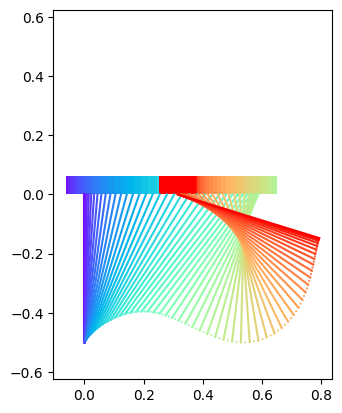

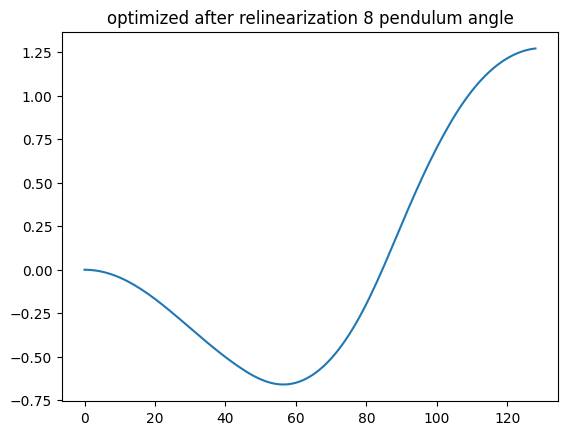

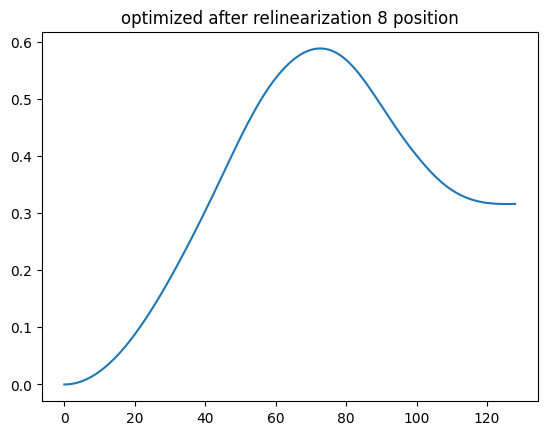

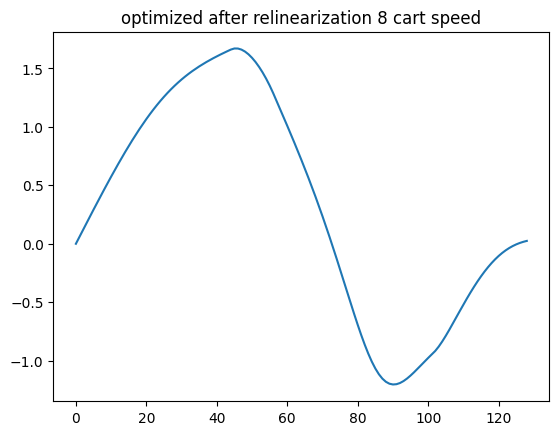

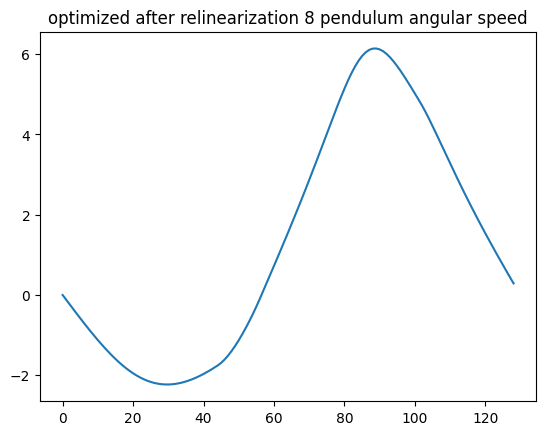

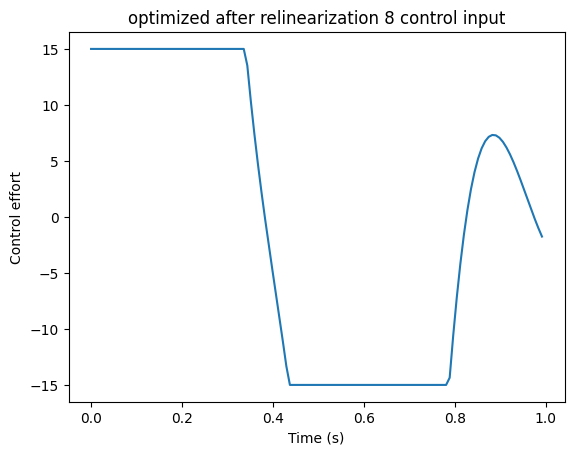

============ step 9 ============
applying control inputs to nonliner dynamics


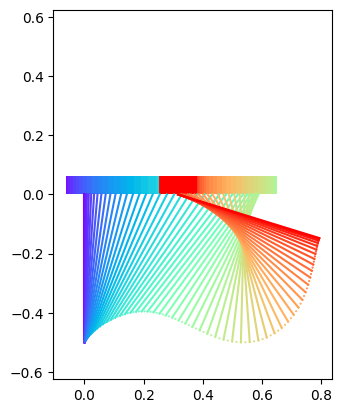

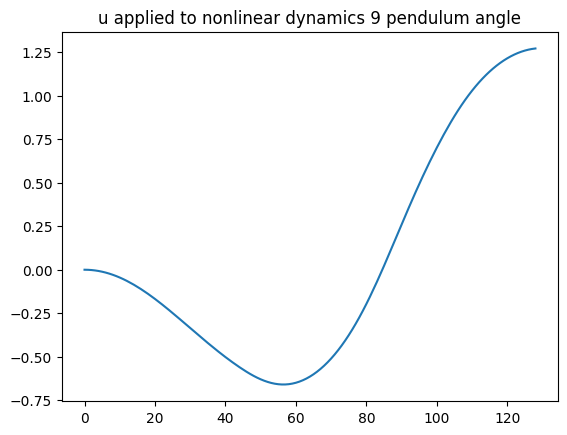

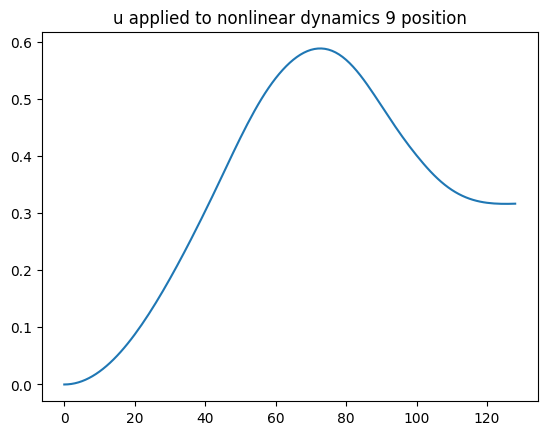

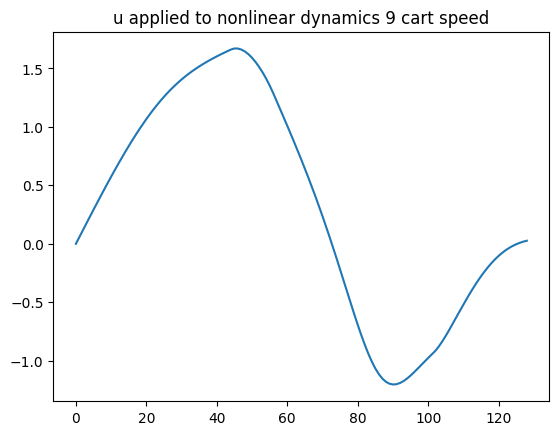

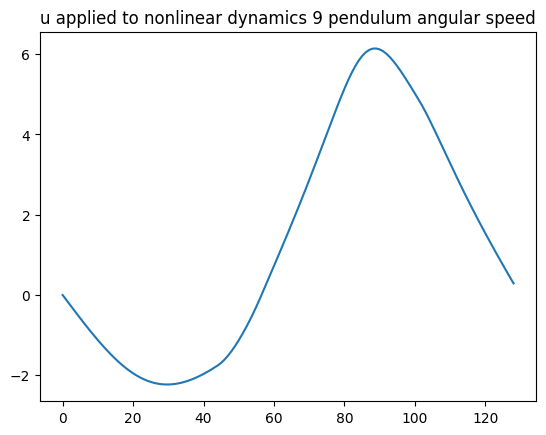

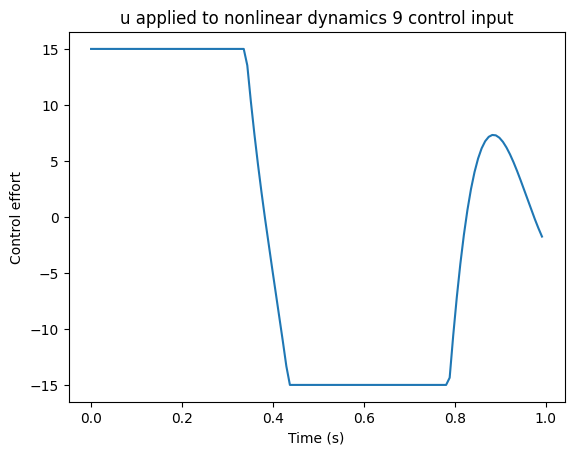

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 261810.40254873957 line search param: 0.2058911320946491
ifsnm num iters: 1 residual norm: 258989.32643464903 line search param: 0.01077526366430583
ifsnm num iters: 2 residual norm: 256954.9220094973 line search param: 0.00785516721127895
ifsnm num iters: 3 residual norm: 255138.34654929547 line search param: 0.007069650490151055
ifsnm num iters: 4 residual norm: 253514.98156621918 line search param: 0.00636268544113595
ifsnm num iters: 5 residual norm: 251901.9465039901 line search param: 0.00636268544113595
ifsnm num iters: 6 residual norm: 250299.27819992226 line search param: 0.00636268544113595
ifsnm num iters: 7 residual norm: 248706.70270881522 line search param: 0.00636268544113595
ifsnm num iters: 8 residual norm: 247124.26020541982 line search param: 0.00636268544113595
ifsnm num iters: 9 residual norm: 245377.1780812426 line search param: 0.0070696504

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.27576e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=2.04777e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.31381059609000017 newton decrement: 338.21921754302855
nd prev: 338.21921754302855 nd: 4.89306369624961
fsnm num iters: 2 line search: 1.0 newton decrement: 4.89306369624961
nd prev: 4.89306369624961 nd: 0.2898111975032724


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.71402e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.2898111975032724
nd prev: 0.2898111975032724 nd: 0.24566906381845013
fsnm num iters: 4 line search: 1.0 newton decrement: 0.24566906381845013
nd prev: 0.24566906381845013 nd: 0.17576952440800755
fsnm num iters: 5 line search: 1.0 newton decrement: 0.17576952440800755
nd prev: 0.17576952440800755 nd: 0.08159635129048415
fsnm num iters: 6 line search: 1.0 newton decrement: 0.08159635129048415
nd prev: 0.08159635129048415 nd: 0.014582310501367553
fsnm num iters: 7 line search: 0.0014555783429306911 newton decrement: 0.014582310501367553
nd prev: 0.014582310501367553 nd: 0.0004242981657048442
fsnm num iters: 8 line search: 1.0 newton decrement: 0.0004242981657048442
nd prev: 0.0004242981657048442 nd: 0.00042328502081122213
fsnm num iters: 9 line search: 1.0 newton decrement: 0.00042328502081122213
nd prev: 0.00042328502081122213 nd: 4.1218285375457374e-07
fsnm num iters: 10 line search: 1.0 newton decrement: 4.1218285375457374e-07
nd p

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32055e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.51031e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 1.0 newton decrement: 120.42992648166386
nd prev: 120.42992648166386 nd: 0.0962964507313232
fsnm num iters: 2 line search: 1.0 newton decrement: 0.0962964507313232
nd prev: 0.0962964507313232 nd: 0.08701135305503917


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.3332e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.0695e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 3 line search: 1.0 newton decrement: 0.08701135305503917
nd prev: 0.08701135305503917 nd: 0.07022738061737215
fsnm num iters: 4 line search: 1.0 newton decrement: 0.07022738061737215
nd prev: 0.07022738061737215 nd: 0.04264945511679418


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93251e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 0.04264945511679418
nd prev: 0.04264945511679418 nd: 0.013047285496438216


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.66453e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.71698e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.9 newton decrement: 0.013047285496438216
nd prev: 0.013047285496438216 nd: 0.0009452729222946353
fsnm num iters: 7 line search: 4.048376602284338e-05 newton decrement: 0.0009452729222946353
nd prev: 0.0009452729222946353 nd: 9.895077307131027e-05
fsnm num iters: 8 line search: 0.00021847450052839252 newton decrement: 9.895077307131027e-05
nd prev: 9.895077307131027e-05 nd: 9.89467570174562e-05
fsnm num iters: 9 line search: 4.048376602284338e-05 newton decrement: 9.89467570174562e-05
nd prev: 9.89467570174562e-05 nd: 9.892515390715137e-05
fsnm num iters: 10 line search: 3.279185047850314e-05 newton decrement: 9.892515390715137e-05
nd prev: 9.892515390715137e-05 nd: 9.892114861672709e-05
fsnm num iters: 11 line search: 0.00026972160559060804 newton decrement: 9.892114861672709e-05
nd prev: 9.892114861672709e-05 nd: 9.891789925651944e-05
fsnm num iters: 12 line search: 1.1433811272836918e-05 newton decrement: 9.891789925651944e-05
nd prev: 9.8917899256519

/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.42947e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.84996e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.030477641249799837
nd prev: 0.030477641249799837 nd: 0.02763222205791003
fsnm num iters: 3 line search: 1.0 newton decrement: 0.02763222205791003
nd prev: 0.02763222205791003 nd: 0.022252729614862903


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.41636e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.19763e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.022252729614862903
nd prev: 0.022252729614862903 nd: 0.013404346303211358
fsnm num iters: 5 line search: 1.0 newton decrement: 0.013404346303211358
nd prev: 0.013404346303211358 nd: 0.003991956351589885


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.0167e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.67706e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72335e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.003991956351589885
nd prev: 0.003991956351589885 nd: 0.0002709652963737394
fsnm num iters: 7 line search: 0.00026972160559060804 newton decrement: 0.0002709652963737394
nd prev: 0.0002709652963737394 nd: 1.1174962689815502e-06
fsnm num iters: 8 line search: 8.464149782874061e-05 newton decrement: 1.1174962689815502e-06
nd prev: 1.1174962689815502e-06 nd: 1.1172336170828112e-06
fsnm num iters: 9 line search: 8.464149782874061e-05 newton decrement: 1.1172336170828112e-06
nd prev: 1.1172336170828112e-06 nd: 1.1171539594314627e-06
fsnm num iters: 10 line search: 0.0006961986091308866 newton decrement: 1.1171539594314627e-06
nd prev: 1.1171539594314627e-06 nd: 1.117073775005306e-06
fsnm num iters: 11 line search: 5.5533286725436733e-05 newton decrement: 1.117073775005306e-06
nd prev: 1.117073775005306e-06 nd: 1.1162905270708734e-06
fsnm num iters: 12 line search: 2.1514733098945913e-05 newton decrement: 1.1162905270708734e-06
nd prev: 1

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72342e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72342e-17): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.18984977996526683
nd prev: 0.18984977996526683 nd: 12.436351076781822
fsnm num iters: 1 line search: 1.0 newton decrement: 12.436351076781822
nd prev: 12.436351076781822 nd: 0.009676078534377061


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33048e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.54145e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.009676078534377061
nd prev: 0.009676078534377061 nd: 0.00881600255905235
fsnm num iters: 3 line search: 1.0 newton decrement: 0.00881600255905235
nd prev: 0.00881600255905235 nd: 0.0071754234539356835


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.34091e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.08166e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.94096e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0071754234539356835
nd prev: 0.0071754234539356835 nd: 0.004428957559007386
fsnm num iters: 5 line search: 0.81 newton decrement: 0.004428957559007386
nd prev: 0.004428957559007386 nd: 0.0014095344091652863


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.52459e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.0014095344091652863
nd prev: 0.0014095344091652863 nd: 0.00036214451103636243


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72006e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.0022185312344622636 newton decrement: 0.00036214451103636243
nd prev: 0.00036214451103636243 nd: 6.443118188043982e-06
fsnm num iters: 8 line search: 1.0 newton decrement: 6.443118188043982e-06
nd prev: 6.443118188043982e-06 nd: 6.426855056620995e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72358e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 0.001996678111016037 newton decrement: 6.426855056620995e-06
nd prev: 6.426855056620995e-06 nd: 2.0601367789478176e-09
entering fsnm loop
newton decrement: 0.06003742108863457
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72358e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72358e-18): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.06003742108863457
nd prev: 0.06003742108863457 nd: 3.9417439519678763
fsnm num iters: 1 line search: 1.0 newton decrement: 3.9417439519678763
nd prev: 3.9417439519678763 nd: 0.0030604728158328404


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32746e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.53196e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0030604728158328404
nd prev: 0.0030604728158328404 nd: 0.0027892261023489415
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0027892261023489415
nd prev: 0.0027892261023489415 nd: 0.0022715642612361653


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.33857e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.07799e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0022715642612361653
nd prev: 0.0022715642612361653 nd: 0.0014041835652591355
fsnm num iters: 5 line search: 0.34867844010000015 newton decrement: 0.0014041835652591355
nd prev: 0.0014041835652591355 nd: 0.00046273000641615337


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.93848e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.18642e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.00046273000641615337
nd prev: 0.00046273000641615337 nd: 0.0003059073208478474


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.69715e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 0.00024274944503154723 newton decrement: 0.0003059073208478474
nd prev: 0.0003059073208478474 nd: 1.5409293852456776e-05
fsnm num iters: 8 line search: 4.4981962247603756e-05 newton decrement: 1.5409293852456776e-05
nd prev: 1.5409293852456776e-05 nd: 1.540588297025506e-05
fsnm num iters: 9 line search: 9.261387130997904e-06 newton decrement: 1.540588297025506e-05
nd prev: 1.540588297025506e-05 nd: 1.5405519276395913e-05
fsnm num iters: 10 line search: 1.2704234747596576e-05 newton decrement: 1.5405519276395913e-05
nd prev: 1.5405519276395913e-05 nd: 1.5405499345608945e-05
fsnm num iters: 11 line search: 1.0290430145553226e-05 newton decrement: 1.5405499345608945e-05
nd prev: 1.5405499345608945e-05 nd: 1.5405466487179704e-05
fsnm num iters: 12 line search: 1.0290430145553226e-05 newton decrement: 1.5405466487179704e-05
nd prev: 1.5405466487179704e-05 nd: 1.5405443037236125e-05
fsnm num iters: 13 line search: 1.5684240429131574e-05 newton decrement: 1.5405

/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.69715e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.69715e-19): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.018936803770882266
nd prev: 0.018936803770882266 nd: 1.0664947826655595
fsnm num iters: 1 line search: 1.0 newton decrement: 1.0664947826655595
nd prev: 1.0664947826655595 nd: 0.0009522466528834506


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.79649e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.96929e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 0.0009522466528834506
nd prev: 0.0009522466528834506 nd: 0.0008516602014609653
fsnm num iters: 3 line search: 1.0 newton decrement: 0.0008516602014609653
nd prev: 0.0008516602014609653 nd: 0.0006630897349984439


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.67883e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.57088e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 0.0006630897349984439
nd prev: 0.0006630897349984439 nd: 0.0003663496359914924


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.22933e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 0.00019662705047555326 newton decrement: 0.0003663496359914924
nd prev: 0.0003663496359914924 nd: 9.317454471779082e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.2295e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 0.0005075287860564164 newton decrement: 9.317454471779082e-05
nd prev: 9.317454471779082e-05 nd: 9.31542985252886e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.22968e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 3.279185047850314e-05 newton decrement: 9.31542985252886e-05
nd prev: 9.31542985252886e-05 nd: 9.311084242365208e-05
fsnm num iters: 8 line search: 1.0 newton decrement: 9.311084242365208e-05
nd prev: 9.311084242365208e-05 nd: 8.917283923853237e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.70134e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72356e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 9 line search: 1.0 newton decrement: 8.917283923853237e-05
nd prev: 8.917283923853237e-05 nd: 4.101809093412287e-06
fsnm num iters: 10 line search: 0.0022185312344622636 newton decrement: 4.101809093412287e-06
nd prev: 4.101809093412287e-06 nd: 8.754550454090512e-09
entering fsnm loop
newton decrement: 0.0060037235233538246
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72356e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72356e-20): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0060037235233538246
nd prev: 0.0060037235233538246 nd: 0.3941276893978309
fsnm num iters: 1 line search: 1.0 newton decrement: 0.3941276893978309
nd prev: 0.3941276893978309 nd: 0.0003060420557290622


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.3271e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.52978e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 0.34867844010000015 newton decrement: 0.0003060420557290622
nd prev: 0.0003060420557290622 nd: 0.00038329883802203487
fsnm num iters: 3 line search: 0.5314410000000002 newton decrement: 0.00038329883802203487
nd prev: 0.00038329883802203487 nd: 0.00032155213292316956


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.08254e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.28013e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.36883e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 0.06461081889226679 newton decrement: 0.00032155213292316956
nd prev: 0.00032155213292316956 nd: 0.00033986242308570435
fsnm num iters: 5 line search: 1.0 newton decrement: 0.00033986242308570435
nd prev: 0.00033986242308570435 nd: 0.00022551319894587696


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.12514e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.96942e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 6 line search: 1.0 newton decrement: 0.00022551319894587696
nd prev: 0.00022551319894587696 nd: 0.000137997510908251
fsnm num iters: 7 line search: 0.001310020508637622 newton decrement: 0.000137997510908251
nd prev: 0.000137997510908251 nd: 4.5376341031101986e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.9711e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 8 line search: 0.0011790184577738598 newton decrement: 4.5376341031101986e-05
nd prev: 4.5376341031101986e-05 nd: 4.531666967408169e-05
fsnm num iters: 9 line search: 1.0 newton decrement: 4.531666967408169e-05
nd prev: 4.531666967408169e-05 nd: 4.239078492822685e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.6698e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 10 line search: 0.0024650347049580707 newton decrement: 4.239078492822685e-05
nd prev: 4.239078492822685e-05 nd: 3.0715588953376003e-06
fsnm num iters: 11 line search: 0.00017696434542799794 newton decrement: 3.0715588953376003e-06
nd prev: 3.0715588953376003e-06 nd: 3.06726660222508e-06
fsnm num iters: 12 line search: 0.00015926791088519815 newton decrement: 3.06726660222508e-06
nd prev: 3.06726660222508e-06 nd: 3.0672365671145106e-06
fsnm num iters: 13 line search: 0.0008595044557171439 newton decrement: 3.0672365671145106e-06
nd prev: 3.0672365671145106e-06 nd: 3.0672056627919996e-06
fsnm num iters: 14 line search: 1.0 newton decrement: 3.0672056627919996e-06
nd prev: 3.0672056627919996e-06 nd: 3.052574232172002e-06


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72392e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72392e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 15 line search: 0.0009550049507968265 newton decrement: 3.052574232172002e-06
nd prev: 3.052574232172002e-06 nd: 1.6848763689707415e-08
entering fsnm loop
newton decrement: 0.001898512054856962
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72392e-21): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.31611e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.001898512054856962
nd prev: 0.001898512054856962 nd: 0.12449523482320965
fsnm num iters: 1 line search: 1.0 newton decrement: 0.12449523482320965
nd prev: 0.12449523482320965 nd: 9.676731292043992e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.47399e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.32846e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 9.676731292043992e-05
nd prev: 9.676731292043992e-05 nd: 8.817976102467136e-05
fsnm num iters: 3 line search: 0.0010611166119964739 newton decrement: 8.817976102467136e-05
nd prev: 8.817976102467136e-05 nd: 0.00010878371782057858
fsnm num iters: 4 line search: 1.0 newton decrement: 0.00010878371782057858
nd prev: 0.00010878371782057858 nd: 7.177248144656702e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.06133e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.92068e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 7.177248144656702e-05
nd prev: 7.177248144656702e-05 nd: 4.4314775233260524e-05
fsnm num iters: 6 line search: 1.0 newton decrement: 4.4314775233260524e-05
nd prev: 4.4314775233260524e-05 nd: 1.3934239656203437e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.668e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72211e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 7 line search: 1.0 newton decrement: 1.3934239656203437e-05
nd prev: 1.3934239656203437e-05 nd: 1.0471775269527256e-06
fsnm num iters: 8 line search: 1.0 newton decrement: 1.0471775269527256e-06
nd prev: 1.0471775269527256e-06 nd: 4.1585852356378344e-08
fsnm num iters: 9 line search: 1.0 newton decrement: 4.1585852356378344e-08
nd prev: 4.1585852356378344e-08 nd: 4.09162297002733e-08
fsnm num iters: 10 line search: 1.0 newton decrement: 4.09162297002733e-08
nd prev: 4.09162297002733e-08 nd: 4.091618138401746e-08
fsnm num iters: 11 line search: 1.0 newton decrement: 4.091618138401746e-08
nd prev: 4.091618138401746e-08 nd: 4.091616531422528e-08
entering fsnm loop
newton decrement: 0.0006003822123905322
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.72211e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.72211e-22): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.0006003822123905322
nd prev: 0.0006003822123905322 nd: 0.03950394059623618
fsnm num iters: 1 line search: 1.0 newton decrement: 0.03950394059623618
nd prev: 0.03950394059623618 nd: 3.065170614415869e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.42807e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.62694e-25): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 2 line search: 1.0 newton decrement: 3.065170614415869e-05
nd prev: 3.065170614415869e-05 nd: 2.7910605161754823e-05
fsnm num iters: 3 line search: 1.0 newton decrement: 2.7910605161754823e-05
nd prev: 2.7910605161754823e-05 nd: 2.2753392062698984e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.37237e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=3.1546e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 4 line search: 1.0 newton decrement: 2.2753392062698984e-05
nd prev: 2.2753392062698984e-05 nd: 1.4101366794320924e-05


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=4.9711e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')
/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=5.668e-24): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 5 line search: 1.0 newton decrement: 1.4101366794320924e-05
nd prev: 1.4101366794320924e-05 nd: 4.4839085408926715e-06
fsnm num iters: 6 line search: 1.0 newton decrement: 4.4839085408926715e-06
nd prev: 4.4839085408926715e-06 nd: 3.5794513001964176e-07
fsnm num iters: 7 line search: 0.2058911320946491 newton decrement: 3.5794513001964176e-07
nd prev: 3.5794513001964176e-07 nd: 1.3157832427409052e-07
fsnm num iters: 8 line search: 0.0022185312344622636 newton decrement: 1.3157832427409052e-07
nd prev: 1.3157832427409052e-07 nd: 1.3157832328598855e-07
entering fsnm loop
newton decrement: 0.00018978465887599188
stupid feasible newton termination criteria: inf


/home/jg/traj_opt/solvers.py:130: LinAlgWarning: Ill-conditioned matrix (rcond=5.668e-23): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 0 line search: 0.10941898913151243 newton decrement: 0.00018978465887599188
nd prev: 0.00018978465887599188 nd: 0.012689163054103227


/home/jg/traj_opt/solvers.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=1.42807e-26): result may not be accurate.
  delta_x_v = scipy.linalg.solve(K, np.hstack([-grad, np.zeros((self.qp.M,))]), assume_a='sym')


fsnm num iters: 1 line search: 0.0005075287860564164 newton decrement: 0.012689163054103227
nd prev: 0.012689163054103227 nd: 1.7790019050961713e-05
fsnm num iters: 2 line search: 0.0011790184577738598 newton decrement: 1.7790019050961713e-05
nd prev: 1.7790019050961713e-05 nd: 1.7789713889688875e-05
fsnm num iters: 3 line search: 1.742693381014619e-05 newton decrement: 1.7789713889688875e-05
nd prev: 1.7789713889688875e-05 nd: 1.7789964013972194e-05
fsnm num iters: 4 line search: 1.742693381014619e-05 newton decrement: 1.7789964013972194e-05
nd prev: 1.7789964013972194e-05 nd: 1.7789964013896306e-05


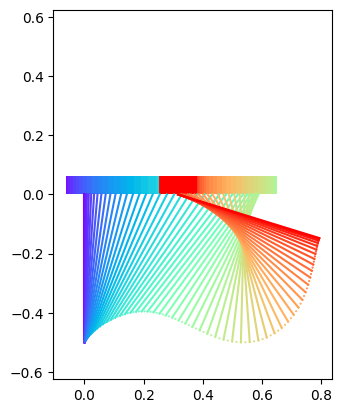

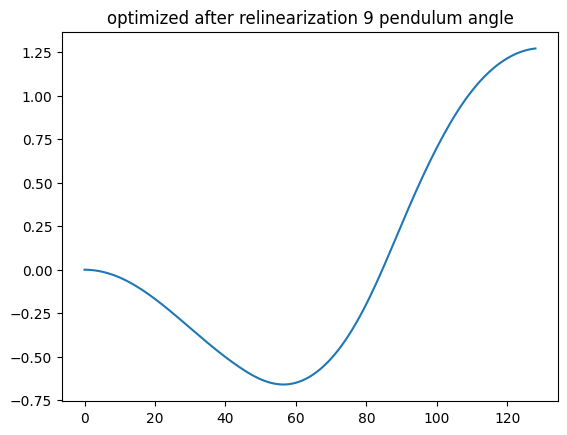

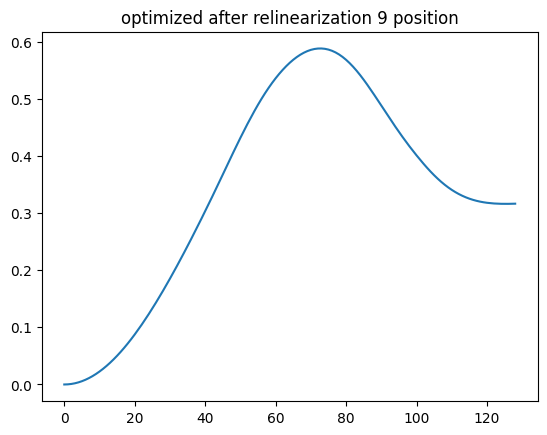

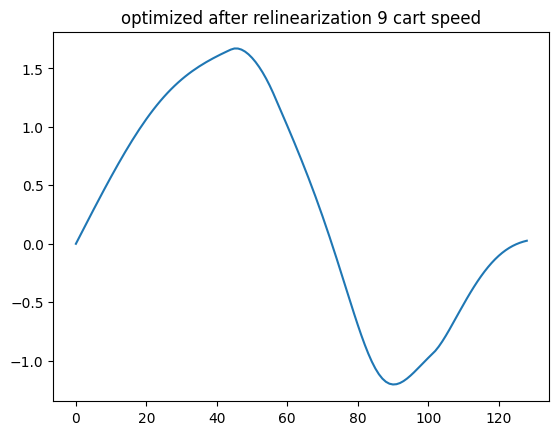

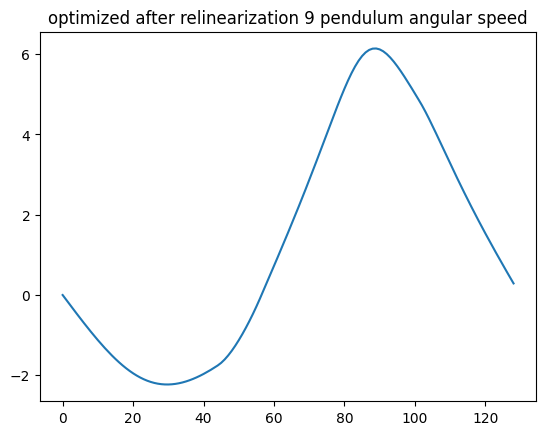

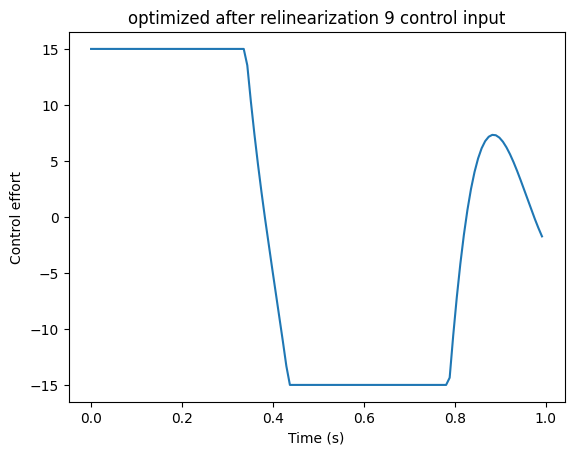

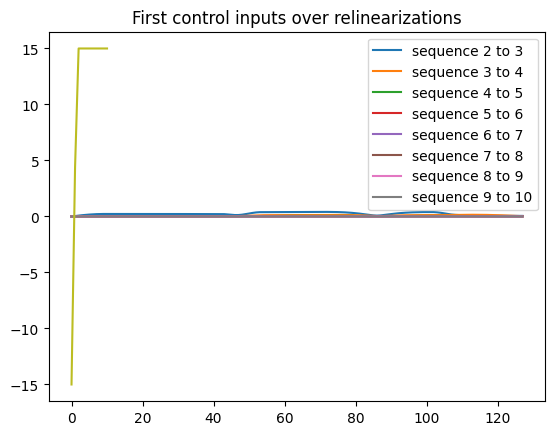

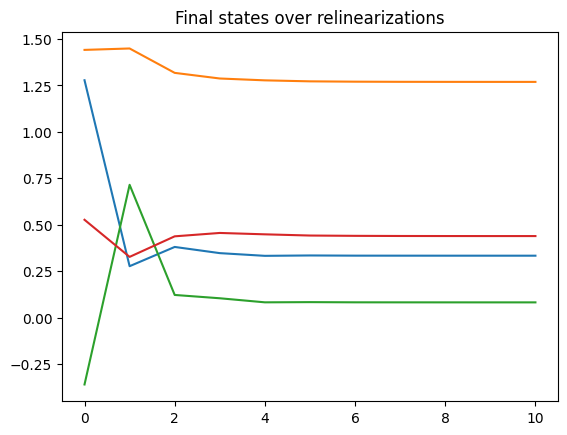

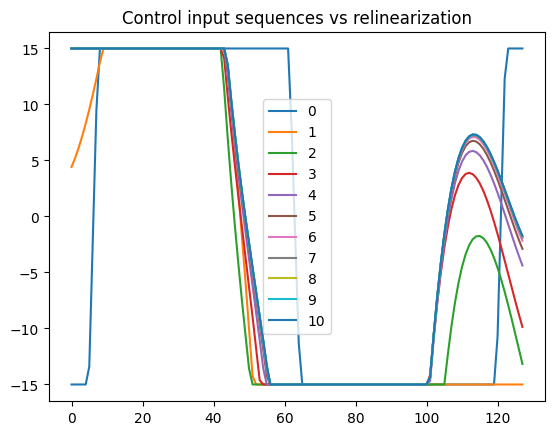

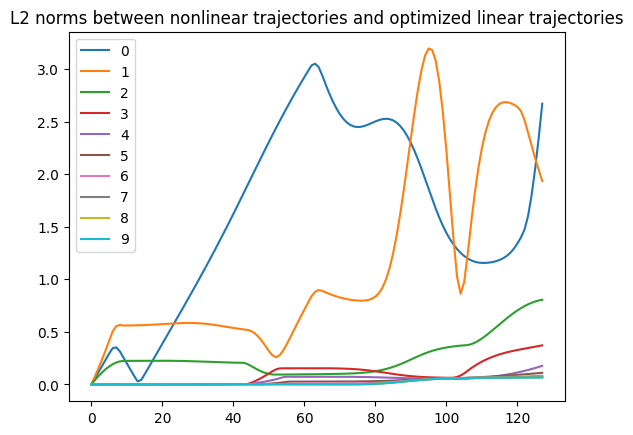

In [24]:
optimized_trajectories: List[List[Tuple[np.ndarray, np.ndarray]]] = []
nonlinear_trajectories: List[List[Tuple[np.ndarray, np.ndarray]]] = []

plot_stuff = True
filename = None
dense_zs, dense_us, feasible = cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_final, z_f_penalty=100000.0)
trajectory = [state_control for state_control in zip(dense_zs, dense_us)]
optimized_trajectories.append(trajectory)

if not feasible:
   print("not feasible")

print("last control input:", dense_us[-1])

if plot_stuff:
   plot_pendulum_time_sequence(dense_zs, dynamics._l_pend, 2)
   plot_control_input(dense_us, T / N)

num_relinearizations = 10
for step in range(num_relinearizations):
   print("============ step", step, "============")
   print("applying control inputs to nonliner dynamics")

   nonlinear_states = [z_0]
   dt = T / N
   num_substeps = 100
   temp_state = nonlinear_states[-1]
   for control_input in dense_us:
      for i in range(num_substeps):
         # print("temp state:", temp_state)
         temp_state = dynamics.step(
            temp_state, control_input, dt / num_substeps, 0.0
         )

      nonlinear_states.append(temp_state)

   nonlinear_trajectory = [state_control for state_control in zip(nonlinear_states, dense_us)]
   nonlinear_trajectories.append(nonlinear_trajectory)

   if plot_stuff:
      plot_pendulum_time_sequence(nonlinear_states, dynamics._l_pend, 2, title_prefix="u applied to nonlinear dynamics " + str(step))
      plot_control_input(dense_us, T / N, title_prefix="u applied to nonlinear dynamics " + str(step))

   relin_seq = [state_control for state_control in zip(nonlinear_states, dense_us)]
   dense_zs, dense_us, feasible = cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_final, z_f_penalty=100000.0, relinearization_sequence=relin_seq)
   trajectory = [state_control for state_control in zip(dense_zs, dense_us)]
   optimized_trajectories.append(trajectory)

   if not feasible:
      print("not feasible")
      break

   if plot_stuff:
      plot_pendulum_time_sequence(nonlinear_states, dynamics._l_pend, 2, title_prefix="optimized after relinearization " + str(step))
      plot_control_input(dense_us, T / N, title_prefix="optimized after relinearization " + str(step))

len(optimized_trajectories)
for i in range(2, len(optimized_trajectories) - 1):
   states = [state for state, _ in optimized_trajectories[i]]
   states_prime = [state for state, _ in optimized_trajectories[i + 1]]

   deltas = [np.linalg.norm(state - state_prime) for state, state_prime in zip(states, states_prime)]

   plt.plot(deltas, label="sequence " + str(i) + " to " + str(i + 1))
plt.legend()
first_control_inputs = []
for i in range(len(optimized_trajectories)):
   first_input = optimized_trajectories[i][0][1]
   first_control_inputs.append(first_input)

plt.title("First control inputs over relinearizations")
plt.plot(first_control_inputs)
plt.show()
final_states = []
for i in range(len(optimized_trajectories)):
   final_state = optimized_trajectories[i][-1][0]
   final_states.append(final_state)

plt.title("Final states over relinearizations")
plt.plot(final_states)
plt.show()

plt.title("Control input sequences vs relinearization")
for i, trajectory in enumerate(optimized_trajectories):
   inputs = [state_control[1] for state_control in trajectory]
   plt.plot(inputs, label=str(i))
plt.legend()
plt.show()
len(optimized_trajectories)
len(nonlinear_trajectories)
plt.title("L2 norms between nonlinear trajectories and optimized linear trajectories")
i = 0
for opt_traj, nl_traj in zip(optimized_trajectories, nonlinear_trajectories):
   deltas = [np.linalg.norm(opt_state_control[0] - nl_state_control[0]) for opt_state_control, nl_state_control in zip(opt_traj, nl_traj)]
   plt.plot(deltas, label=str(i))
   i += 1
plt.legend()
plt.show()

In [25]:
%prun cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_final, z_f_penalty=100000.0)

z_0:  [0. 0. 0. 0.]
z_f:  [0. 0. 0. 0.]
stupid infeasible newton termination criteria: inf
ifsnm num iters: 0 residual norm: 214734.73811599024 line search param: 0.34867844010000015
ifsnm num iters: 1 residual norm: 211560.76912216627 line search param: 0.014780882941434608
ifsnm num iters: 2 residual norm: 208433.71485336282 line search param: 0.014780882941434608
ifsnm num iters: 3 residual norm: 205938.23908230884 line search param: 0.011972515182562033
ifsnm num iters: 4 residual norm: 203472.64086243007 line search param: 0.011972515182562033
ifsnm num iters: 5 residual norm: 201036.56187624278 line search param: 0.011972515182562033
ifsnm num iters: 6 residual norm: 198629.64885809232 line search param: 0.011972515182562033
ifsnm num iters: 7 residual norm: 196489.36206320304 line search param: 0.01077526366430583
ifsnm num iters: 8 residual norm: 194136.8942791399 line search param: 0.011972515182562033
ifsnm num iters: 9 residual norm: 192045.01837310885 line search param: 0.0

         75265 function calls (74489 primitive calls) in 21.582 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      172   16.699    0.097   16.872    0.098 _basic.py:51(solve)
      336    1.315    0.004    1.315    0.004 quadratic_program.py:251(gradient)
      184    0.839    0.005    0.839    0.005 quadratic_program.py:232(objective)
      142    0.815    0.006    1.493    0.011 solvers.py:14(residual)
      172    0.483    0.003    0.820    0.005 quadratic_program.py:306(kkt_matrix)
       10    0.379    0.038   12.630    1.263 solvers.py:105(solve)
      392    0.242    0.001    0.242    0.001 {method '__deepcopy__' of 'numpy.ndarray' objects}
     1048    0.177    0.000    0.177    0.000 {built-in method numpy.zeros}
        1    0.151    0.151    0.151    0.151 linalg.py:1499(svd)
      344    0.120    0.000    0.140    0.000 function_base.py:564(asarray_chkfinite)
      366    0.119    0.000    0.367    0.001 quad

In [26]:
# %prun cartpole_trajectory_optimizer_linear(N, T, dynamics, z_0, z_f=z_final, z_f_penalty=100000.0)